In [1]:
from __future__ import print_function
from __future__ import division

import pdb
import sys
import os
import numpy as np
import scipy.optimize as opt
import scipy.io as sio
import scipy.special as spf
import yaml

## import diffrantion integral solver from Optics folder
work_dir = os.getcwd()
date_dir = os.path.split(work_dir)[0]
optics_folder = os.path.join(date_dir, 'Optics')
sys.path.append(optics_folder)
sys.path.append(date_dir)
import diffraction_int as diffi
import fibonacci as fib


## Import field functions
# field_module_folder = os.path.join(date_dir, 'field_functions')             
# sys.path.append(field_module_folder)
# import far_fields as fi

## Read parameter file to obtain fields
stream = open('../curly_param.yaml','r')
parameters = yaml.load(stream)


## plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
# mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rcParams['text.usetex'] = True

## colorbar stuff 
from mpl_toolkits import axes_grid1

# import eqm_slns as osc

## analytic image functions
# import analytic_intensity_functions_xyz as imf

## dipole moments as functions of separation, not pulled from param file
# import p_of_d_genOr as pod

# pretty fitting
# import lmfit as lf

import anal_foc_diff_fields as afi

import coupled_dipoles as cp 

## Import physical constants
full_path_to_constant_yaml = os.path.join(date_dir,'physical_constants.yaml')
opened_constant_file = open(full_path_to_constant_yaml,'r')
constants = yaml.load(opened_constant_file)
e = constants['physical_constants']['e']
c = constants['physical_constants']['c']  # charge of electron in statcoloumbs
hbar =constants['physical_constants']['hbar']
nm = constants['physical_constants']['nm']
n_a = constants['physical_constants']['nA']   # Avogadro's number
# Z_o = 376.7303 # impedence of free space in ohms (SI)

## System background
n_b = parameters['general']['background_ref_index']
eps_b = n_b**2.

a = parameters['plasmon']['radius']
#######################################################################
## simulated image 
sensor_size = 2000*nm
# height = 2*mm  # also defines objective lens focal length 
height = .2
resolution = 100  # image grid resolution

norm_style = 'per fig'  # 'per fig' or 'across figs'

show_or_save = 'show'
# show_or_save = raw_input('( show / save ) figures? ')

file_extension = 'pdf'  # 'pdf' for mest quality

## plot parameters
plot_scale = 1/nm

#######################################################################
## Optics stuff.  

## Build image sensor
eye = diffi.observation_points(
    x_min= -sensor_size/2, 
    x_max= sensor_size/2,
    y_min= -sensor_size/2, 
    y_max= sensor_size/2, 
    points= resolution
    )

## Experimental parameters
magnification = 1
numerical_aperture = 1
max_theta = np.arcsin(numerical_aperture) # defines physical aperture size

## numerical parameters for calculation of scattered field
lens_points = 1000

# obj_f = 1.*mm  # still dont know what this is supposed to be
obj_f = height

tube_f = magnification * obj_f

## calculate dipole magnitudes
drive_hbar_omega = 1.86 ## rod long mode max at 1.8578957289256757 eV
omega_drive = drive_hbar_omega/hbar  # driving frequency

reading parameters from ../curly_param.yaml
polarizability reduced by factor of 1
coupling scaled up by by factor of 1


## Enter data from polarizabilities

In [2]:
fit_result_params = (
    ## eps_inf, hbar*omega_p, hbar*gamma_nr, eps_b (not used as fit param), a_x, a_yz
    15.100176  , 10.15232758/hbar,  0.10316881/hbar, 1.0, 67.24906658*nm, 19.20816015*nm
    )
alpha0_diag_dyad = cp.sparse_polarizability_tensor(
    mass=cp.fluorophore_mass(
        ext_coef=parameters['fluorophore']['extinction_coeff'], 
        gamma=parameters['fluorophore']['mass_gamma']/hbar
        ), 
    w_res=drive_hbar_omega/hbar, 
    w=drive_hbar_omega/hbar, 
    gamma_nr=parameters['fluorophore']['test_gamma']/hbar,
    a=0, 
    eps_inf=1, 
    ebs_b=1
    )
alpha1_diag_dyad = cp.sparse_ret_prolate_spheroid_polarizability_Drude(
        omega_drive, *fit_result_params)
alpha1_diag_dyad_no_trans = alpha1_diag_dyad
alpha1_diag_dyad_no_trans[1,1] = 0
alpha1_diag_dyad_no_trans[2,2] = 0


In [3]:
alpha1_diag_dyad_no_trans

array([[4.88136678e-17+7.27871584e-16j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j],
       [0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j]])

In [4]:
def mb_p_fields(dipole_mag_array, dipole_coordinate_array):
    ''' As of 081418,fixing: currently only treats dipole at origin.'''    
    p = dipole_mag_array
#     print('Inside mb_p_fields, p= ',p)
    bfx = dipole_coordinate_array

    v_rel_obs_x_pts = (eye[1].ravel()[:,None] - bfx.T[0]).T
    v_rel_obs_y_pts = (eye[2].ravel()[:,None] - bfx.T[1]).T
    
    px_fields = np.asarray(afi.E_field(0, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    py_fields = np.asarray(afi.E_field(np.pi/2, v_rel_obs_x_pts, v_rel_obs_y_pts, omega_drive*n_b/c))
    pz_fields = np.zeros(py_fields.shape)
#     print('px_fields.shape=',px_fields.shape)
    ## returns [Ex, Ey, Ez] for dipoles oriented along cart units
    
    Ex = p[:,0,None]*px_fields[0] + p[:,1,None]*py_fields[0] + p[:,2,None]*pz_fields[0]
    Ey = p[:,0,None]*px_fields[1] + p[:,1,None]*py_fields[1] + p[:,2,None]*pz_fields[1]
    Ez = p[:,0,None]*px_fields[2] + p[:,1,None]*py_fields[2] + p[:,2,None]*pz_fields[2]

    return np.array([Ex,Ey,Ez])

In [5]:
def dipole_fields(locations, mol_angle=0, plas_angle=np.pi/2):
    d = locations*nm
    p0, p1 = cp.dipole_mags_gened(mol_angle, plas_angle, d_col=d, E_d_angle=None,
                                 )
    mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
    plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

    # p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
    p0_unc, = cp.uncoupled_p0(mol_angle, E_d_angle=None, drive_hbar_w=drive_hbar_omega)
#     p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))
    p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=d) 
    
    return [mol_E, plas_E, p0_unc_E, p0, p1]

In [6]:
def powers_and_angels(E):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = np.abs(E[0])**2. / drive_I
    normed_Iy = np.abs(E[1])**2. / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    

    angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)
    return [angles, Px_per_drive_I, Py_per_drive_I]

In [7]:
def powers_and_angels_no_interf(E1,E2):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = (np.abs(E1[0])**2. + np.abs(E2[0])**2.) / drive_I
    normed_Iy = (np.abs(E1[1])**2. + np.abs(E2[1])**2.) / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    

    angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)
    return [angles, Px_per_drive_I, Py_per_drive_I]

In [8]:
def rotating_dipole_fields(locations):
    d = locations*nm
    p0, p1 = cp.dipole_mags_gened(mol_angle=np.linspace(0,2*np.pi,locations.shape[0]), 
                                  plas_angle=np.pi/2, 
                                  d_col=d, 
                                  E_d_angle=None,
                                  alpha0_diag=alpha0_diag_dyad,
                                  alpha1_diag=alpha1_diag_dyad_no_trans)
    mol_E = mb_p_fields(dipole_mag_array=p0, dipole_coordinate_array=d) 
    plas_E = mb_p_fields(dipole_mag_array=p1, dipole_coordinate_array=np.zeros(d.shape))

    # p0_unc, = cp.uncoupled_p0(mol_angle=0, d_col=d[0,None], E_d_angle=None)
#     p0_unc, = cp.uncoupled_p0(mol_angle=np.linspace(0,2*np.pi,d.shape[0]), d_col=d, E_d_angle=None)
    p0_unc, = cp.uncoupled_p0(mol_angle=np.linspace(0,2*np.pi,d.shape[0]), E_d_angle=None, drive_hbar_w=drive_hbar_omega)
#     p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc[None,:], dipole_coordinate_array=np.zeros(d[0][None,:].shape))
    p0_unc_E = mb_p_fields(dipole_mag_array=p0_unc, dipole_coordinate_array=d) 
    
    return [mol_E, plas_E, p0_unc_E]

([<matplotlib.axis.YTick at 0x1320f077f0>,
 <a list of 6 Text yticklabel objects>)

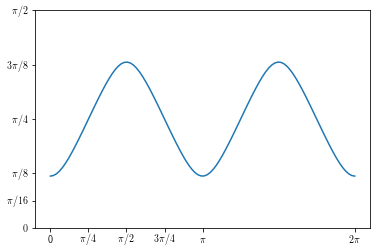

In [9]:
hundred_points = np.ones((100,3))*np.array([[1,0,0]])*10
rotating_fields = rotating_dipole_fields(hundred_points)
rotating_angles_for_map = powers_and_angels(rotating_fields[2])[0]
# quiver_plot(hundred_points[:,0],hundred_points[:,1],rotating_angles_for_map)
plt.plot(np.linspace(0,2*np.pi,hundred_points.shape[0]),rotating_angles_for_map.ravel())
ticks = [0,np.pi/4,np.pi/2,3*np.pi/4,np.pi, 2*np.pi]
tick_labels = [0, r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$', r'$\pi$',r'$2\pi$']
plt.xticks(ticks, tick_labels)
plt.yticks([0,np.pi/16,np.pi/8,np.pi/4,3*np.pi/8,np.pi/2], 
          [r'$0$', r'$\pi/16$',r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])

In [10]:
saved_mapping = np.loadtxt('obs_pol_vs_true_angle.txt')
true_ord_angles, obs_ord_angles =  saved_mapping.T

from scipy import interpolate
f = interpolate.interp1d(true_ord_angles,obs_ord_angles)
f_inv = interpolate.interp1d(
    obs_ord_angles[:251],
    true_ord_angles[:251],
    bounds_error=False,
    fill_value=(0,np.pi/2)
    )

OK I THINK WE ARE GOOD NOW, IT WAS THE RESOLUTION THAT WAS EFFED

In [11]:
locations = diffi.observation_points(x_min=20, x_max=150, y_min=0, y_max=150, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)

# quiver_plot(locations[:,0], locations[:,1], f_inv(angles), [-10,175])


In [12]:
def quiver_plot(x_plot, y_plot, angles, plot_limits=[-25,550],
               title=r'Apparent pol. per mol. pos.'):

    fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(3.25,3), dpi=300, 
                                       gridspec_kw = {'width_ratios':[6, 0.5]}
                                      )

    cmap = mpl.cm.nipy_spectral
    quiv = ax0.quiver(x_plot, y_plot, 
                      np.cos(angles),
                      np.sin(angles), 
                      angles,
                      cmap=cmap,
                      clim = [0, np.pi/2], 
                      width=0.01,
                      scale=15,
            #            scale_units='width',
                      pivot='mid'
                      )
#     qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
#                        coordinates='figure')

    plas_mark = ax0.quiver(0, 0, 0,.3, color='grey',
    #                        marker='o',
    #                        s=2000
                           width=0.03,
                           scale=1,
                           units='width',
                           pivot='mid'
                          )
    ax0.axis('equal')
    ax0.set_xlim(plot_limits)
    ax0.set_ylim(plot_limits)
    ax0.set_title(title)
    ax0.set_xlabel('x [nm]')
    ax0.set_ylabel('y [nm]')

    norm = mpl.colors.Normalize(vmin=0, vmax=np.pi/2)

    cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.set_label(r'observed angle $\phi$')
    plas_dot = ax0.scatter(0,0,color='k',s=30)
    cb1.set_ticks([0, np.pi/8, np.pi/4, np.pi/8 * 3, np.pi/2])
    cb1.set_ticklabels([r'$0$', r'$\pi/8$',r'$\pi/4$',r'$3\pi/8$',r'$\pi/2$'])

#     fig.tight_layout()
    
    quiver_axis_handle = ax0
    return [quiver_axis_handle]

def plot_phase_quiver(x_plot, y_plot, angles, p0, p1, plot_limits=[-25,550],
                      title=r'Apparent pol. w/ dipole phase'):

    phase_diff = np.arccos(np.real(p0/p1)/np.abs(p0/p1))
    
    fig, (ax0, ax_cbar) = plt.subplots(nrows=1,ncols=2, figsize=(3.25,3), dpi=300, 
                                       gridspec_kw = {'width_ratios':[6, 0.5]}
                                      )
    scat_color = phase_diff[:,0]
    cmap = 'brg'

    ax0.scatter(x_plot, y_plot, c=scat_color, s=100,
               cmap=cmap,
               clim = [0, np.pi], 
    #            width=0.01,
    #            scale=10,
    #            scale_units='width',
    #            pivot='mid'
              )

    ax0.set_xlim(plot_limits)
    ax0.set_ylim(plot_limits)
    ax0.set_xlabel('x [nm]')
    ax0.set_ylabel('y [nm]')

    norm = mpl.colors.Normalize(vmin=0, vmax=np.pi)
    cb1 = mpl.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical',
                                    ticks=[0,np.pi/4,np.pi/2,3*np.pi/4,np.pi],
                                    )
    # ax_cbar.set_yticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
    # cb1.set_ticks([0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
    cb1.set_ticklabels([r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$'])
    cb1.set_label(r'difference in dipole phase')
    ax0.set_title(title)


    plas_arrow = ax0.quiver(0, 0, 0,.3, color='grey',
    #                        marker='o',
    #                        s=2000
                           width=0.03,
                           scale=1,
                           units='width',
                           pivot='mid',
                           headlength=3,
                           headaxislength=3
                          )
    plas_dot = ax0.scatter(0,0,color='k',s=200)

    quiv = ax0.quiver(x_plot, y_plot, np.cos(angles),np.sin(angles), 
                    color='white',
    #                    cmap='inferno',
    #                    clim = [0, np.pi/2], 
                       width=0.01,
                       scale=12,
            #            scale_units='width',
                       pivot='mid',
    #                   linewidth=100.,
                      headaxislength=0.0,
                      headlength=0.0
                      )
    # qk = ax_cbar.quiverkey(quiv, 0.5, 0.105, 1, r'molecule orientation', labelpos='E',
    #                    coordinates='figure', color='k' )

    # fig.tight_layout()

    # plt.colorbar(ticks=[0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:407: RuntimeWarning: invalid value encountered in true_divide
  n_hat = d_col/d ## returns shape = (...,3)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in multiply
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperR

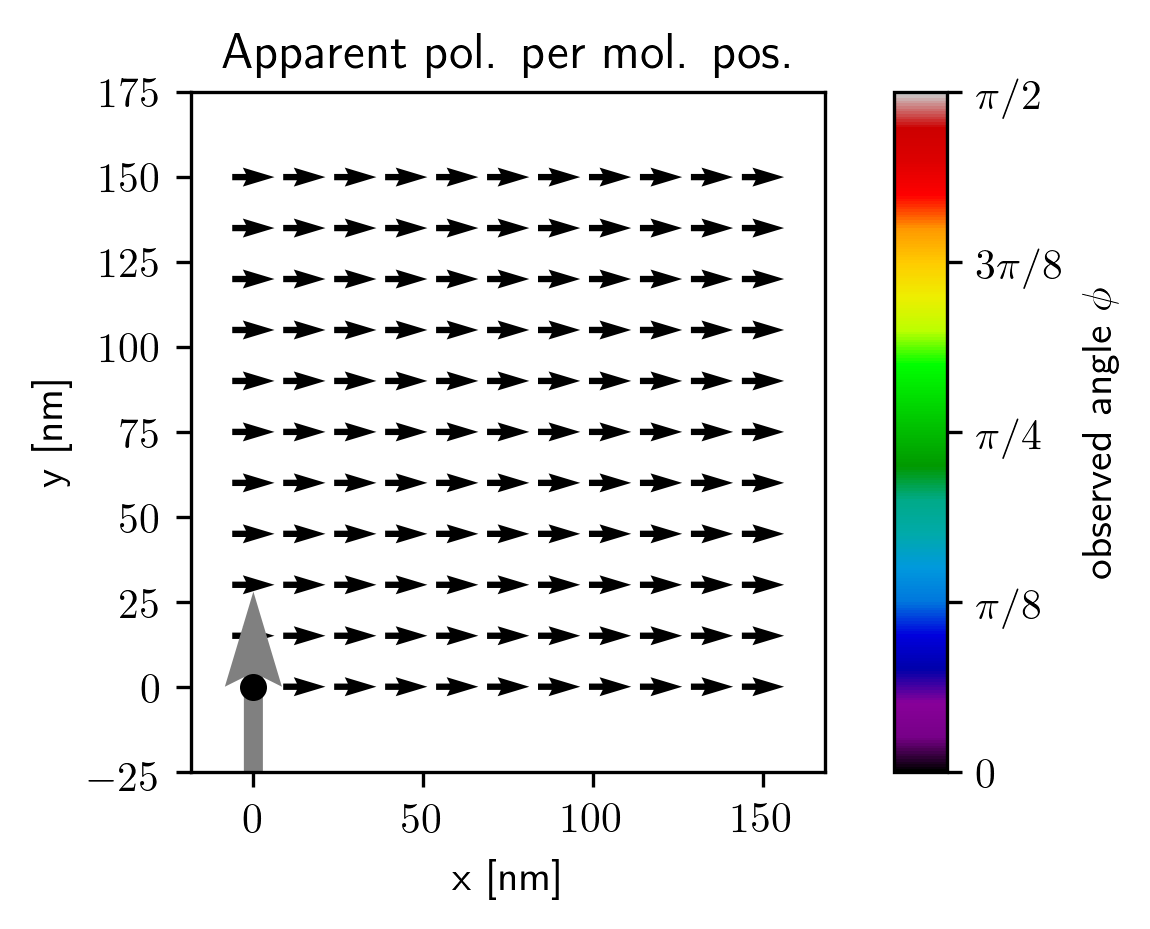

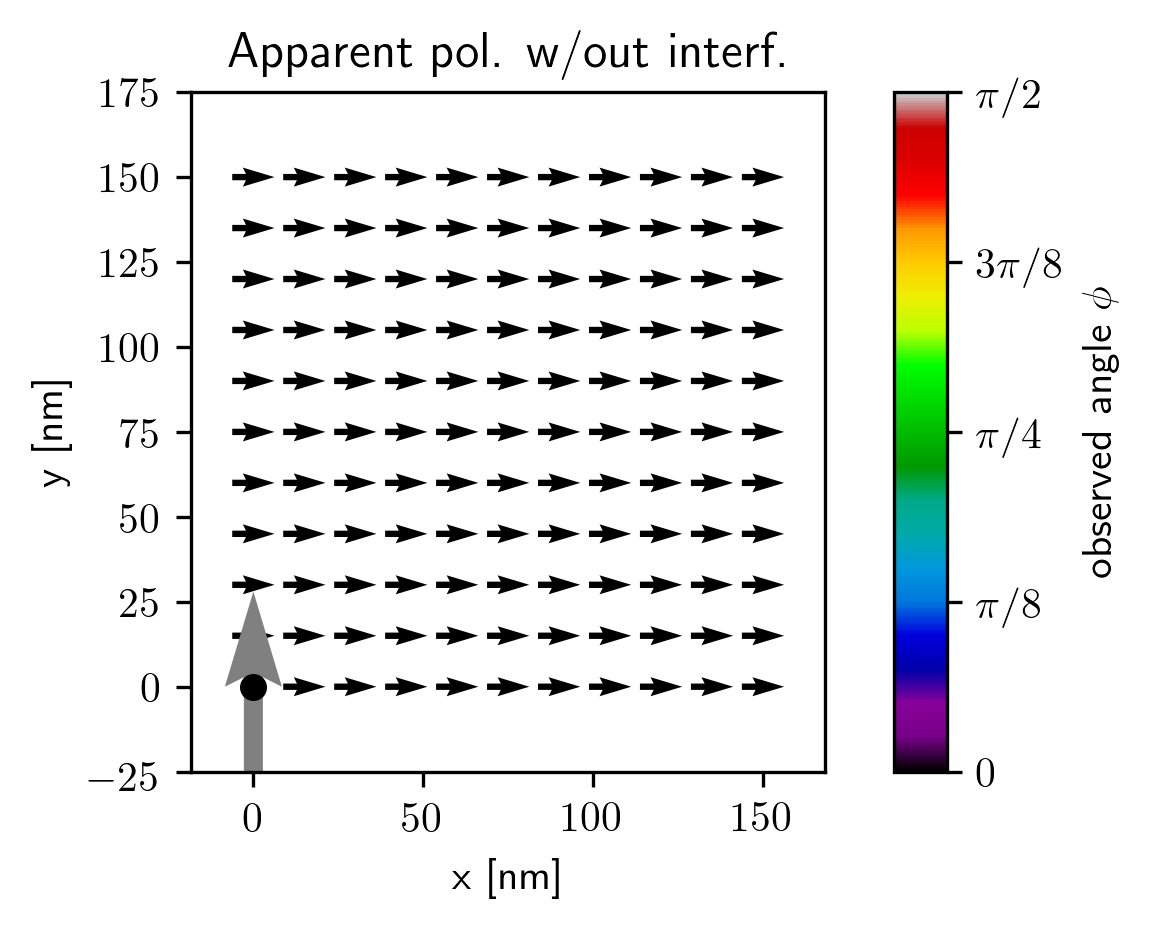

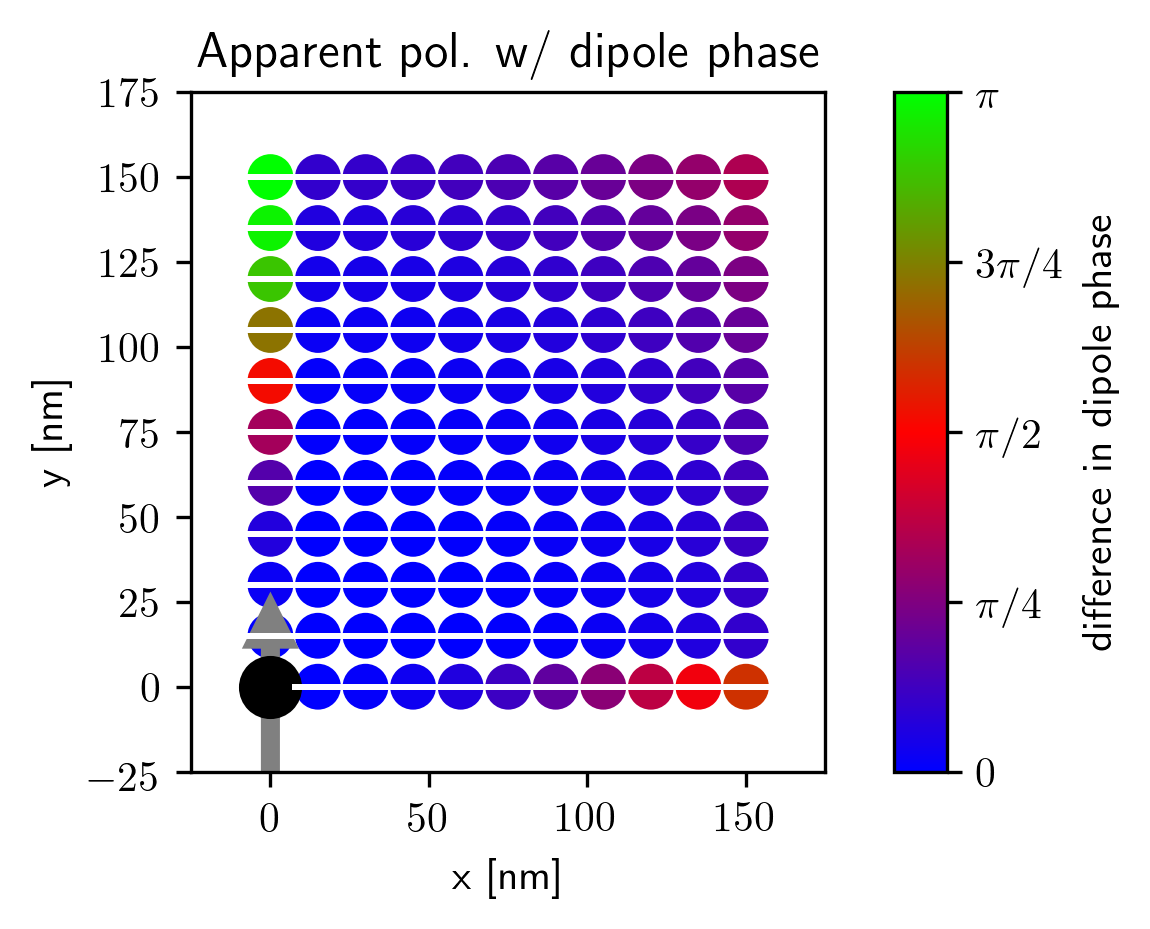

In [13]:
locations = diffi.observation_points(x_min=0, x_max=150, y_min=0, y_max=150, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)



plot_limits=[-25,175]

quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)
## no interference
angles_no_interf, Px_per_drive_I_no_interf, Py_per_drive_I_no_interf= powers_and_angels_no_interf(mol_E,plas_E)
quiver_plot(locations[:,0], locations[:,1], f_inv(angles_no_interf), plot_limits,
           r'Apparent pol. w/out interf.')

plot_phase_quiver(locations[:,0], locations[:,1], f_inv(angles), p0, p1,plot_limits)

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:407: RuntimeWarning: invalid value encountered in true_divide
  n_hat = d_col/d ## returns shape = (...,3)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in multiply
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperR

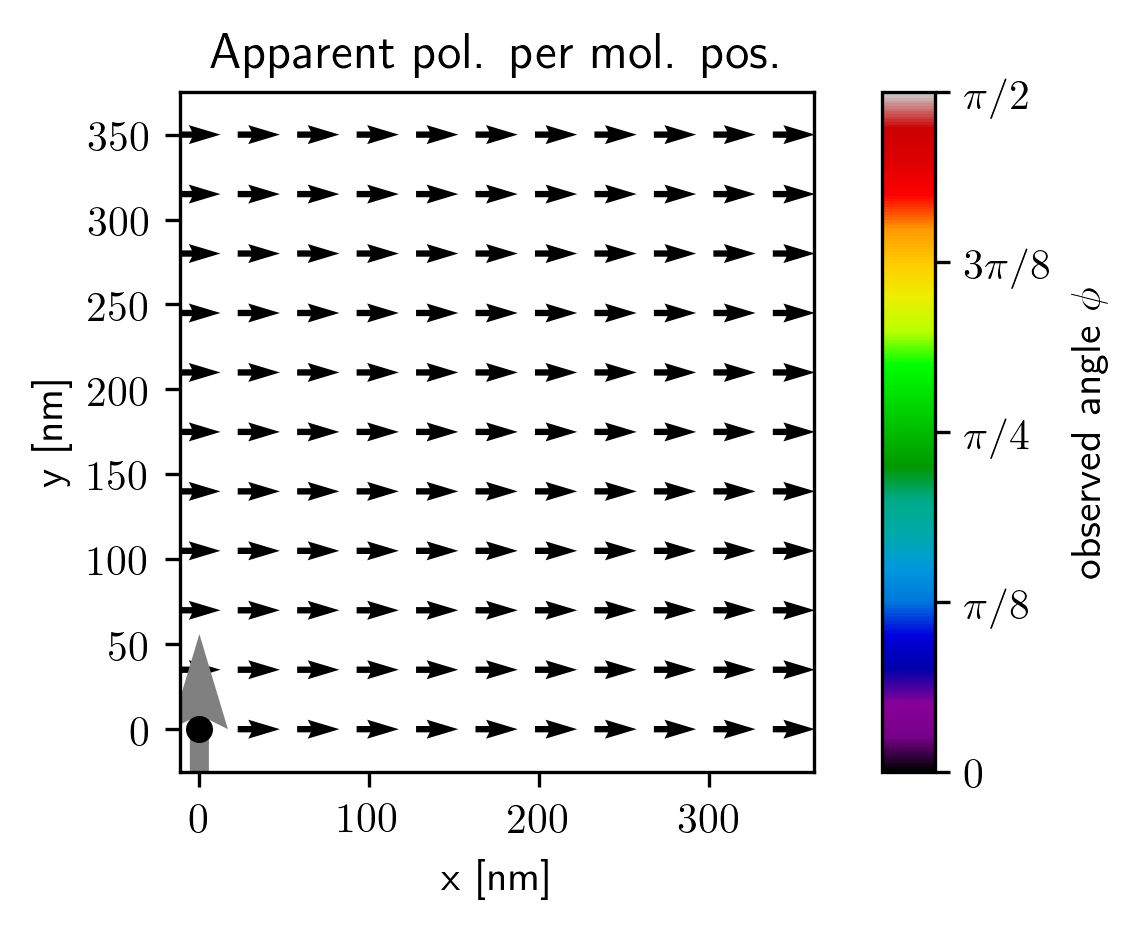

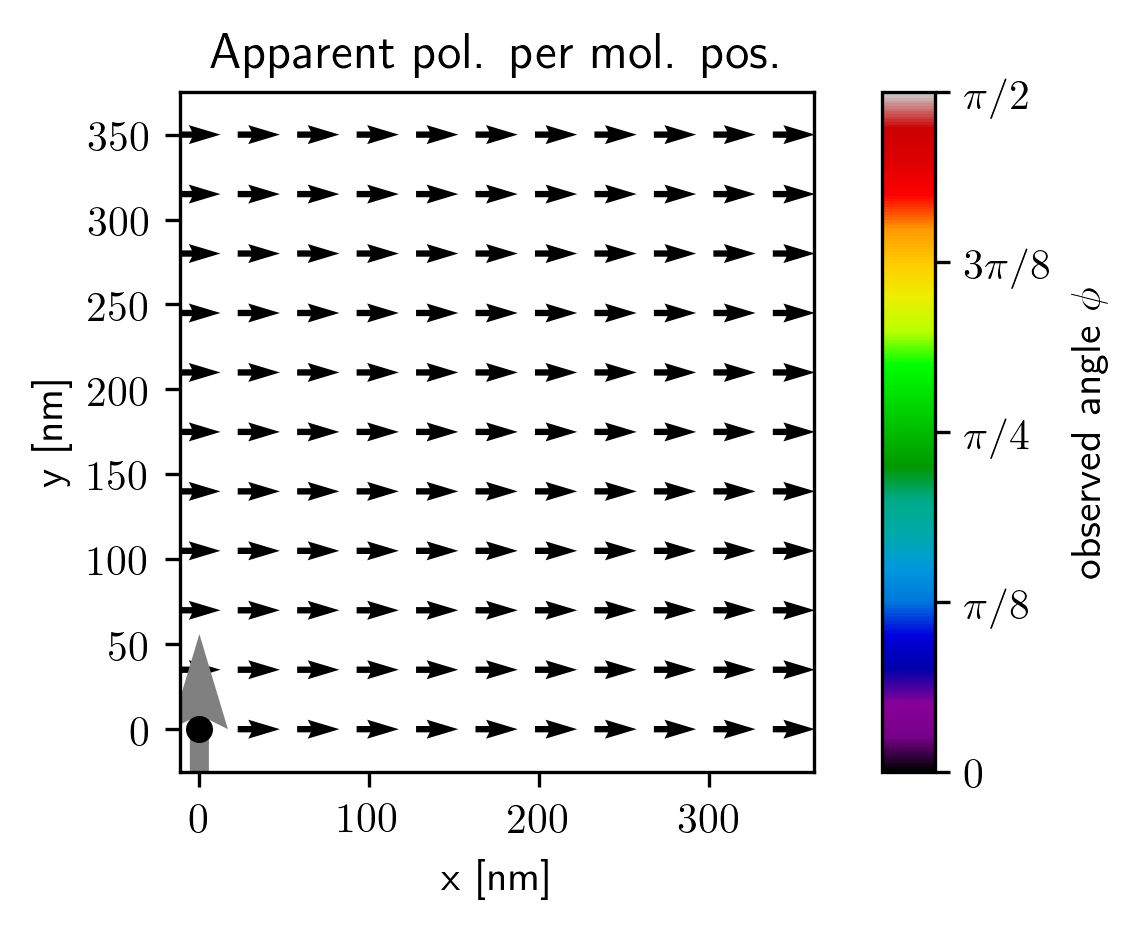

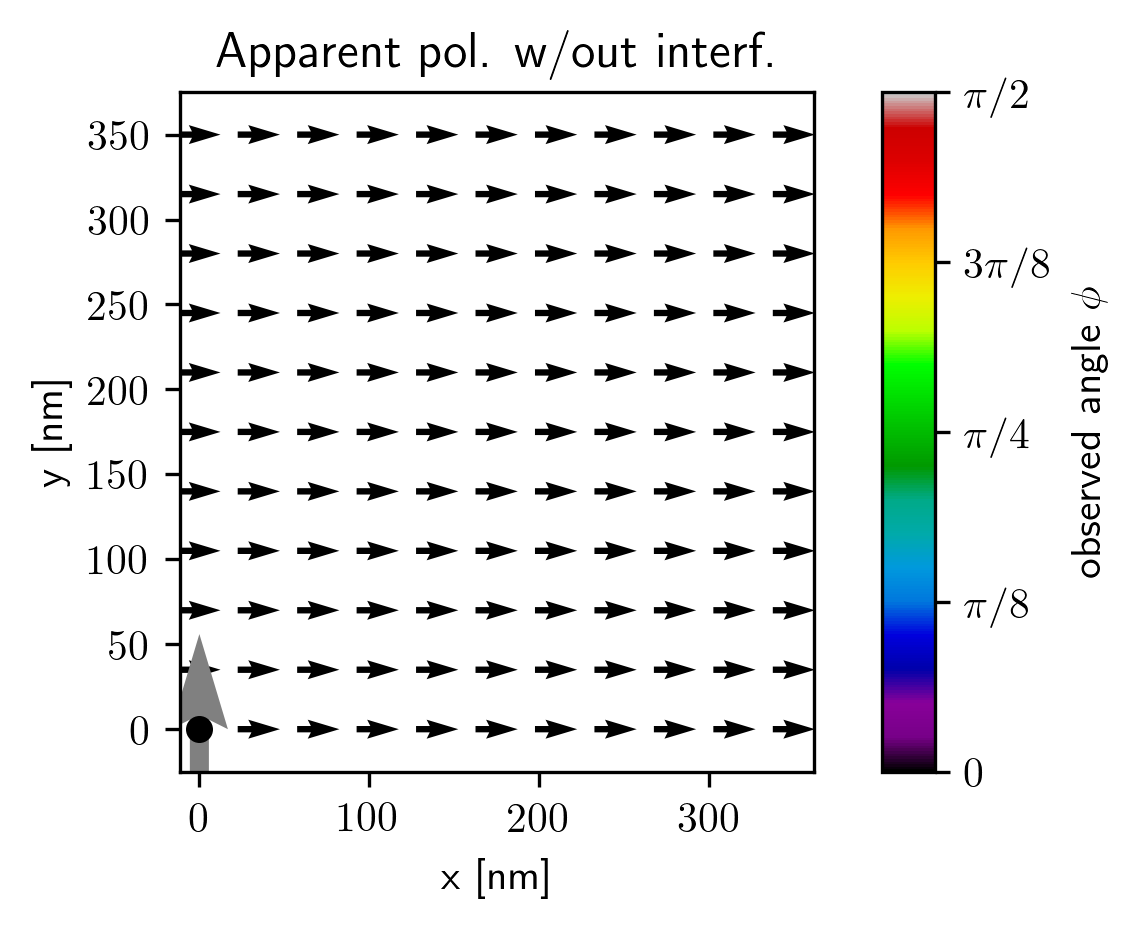

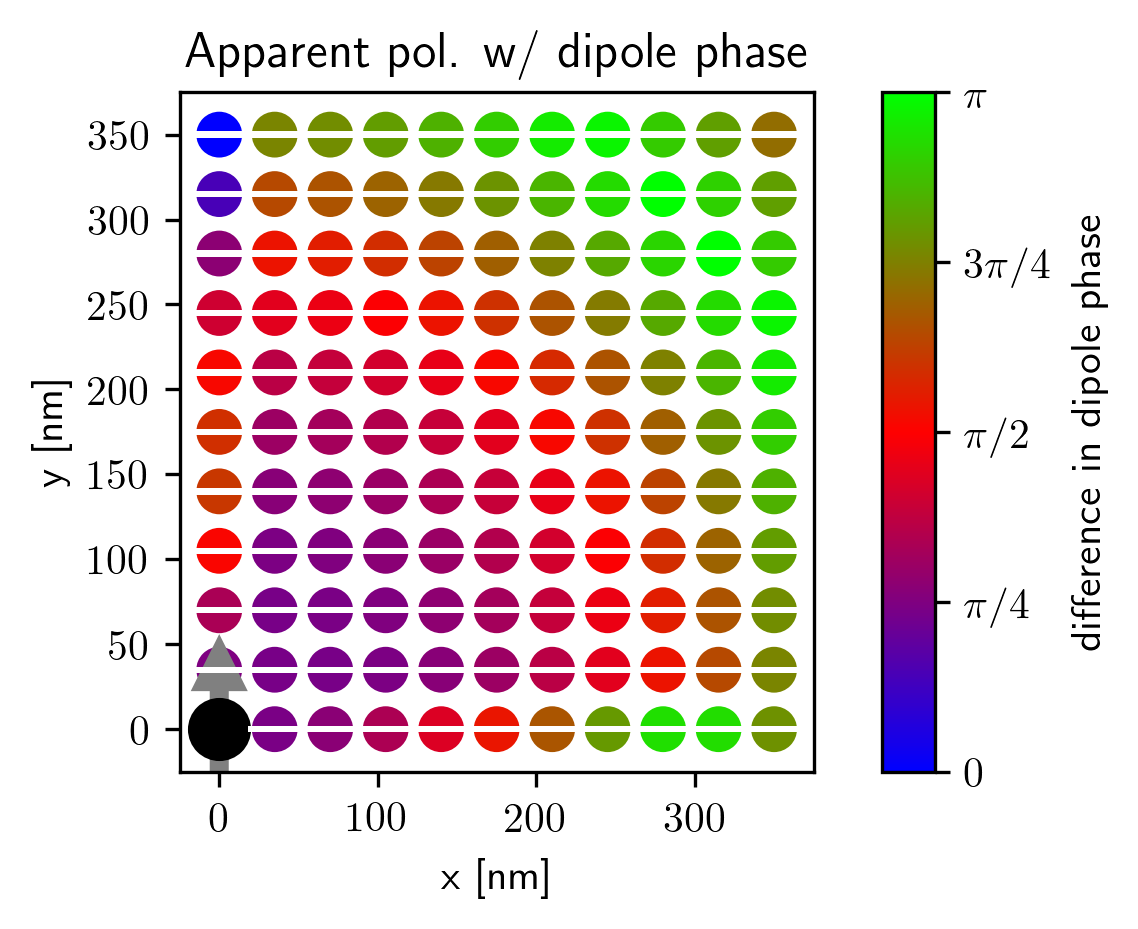

In [14]:
locations = diffi.observation_points(x_min=0, x_max=350, y_min=0, y_max=350, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

plot_limits = [-25,375]

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)

quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)

quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)
## no interference
angles_no_interf, Px_per_drive_I_no_interf, Py_per_drive_I_no_interf= powers_and_angels_no_interf(mol_E,plas_E)
quiver_plot(locations[:,0], locations[:,1], f_inv(angles_no_interf), plot_limits,
           r'Apparent pol. w/out interf.')

plot_phase_quiver(locations[:,0], locations[:,1], f_inv(angles), p0, p1,plot_limits)

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:407: RuntimeWarning: invalid value encountered in true_divide
  n_hat = d_col/d ## returns shape = (...,3)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in multiply
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperR

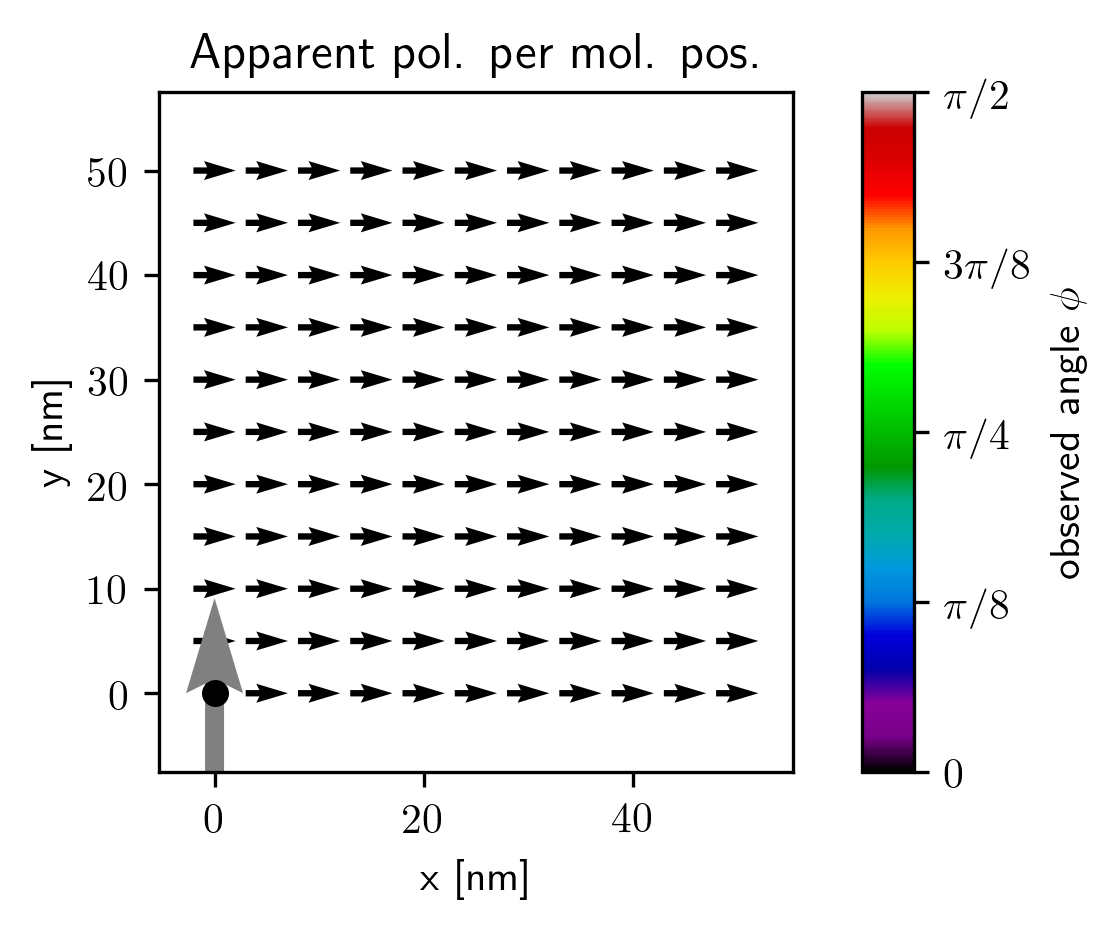

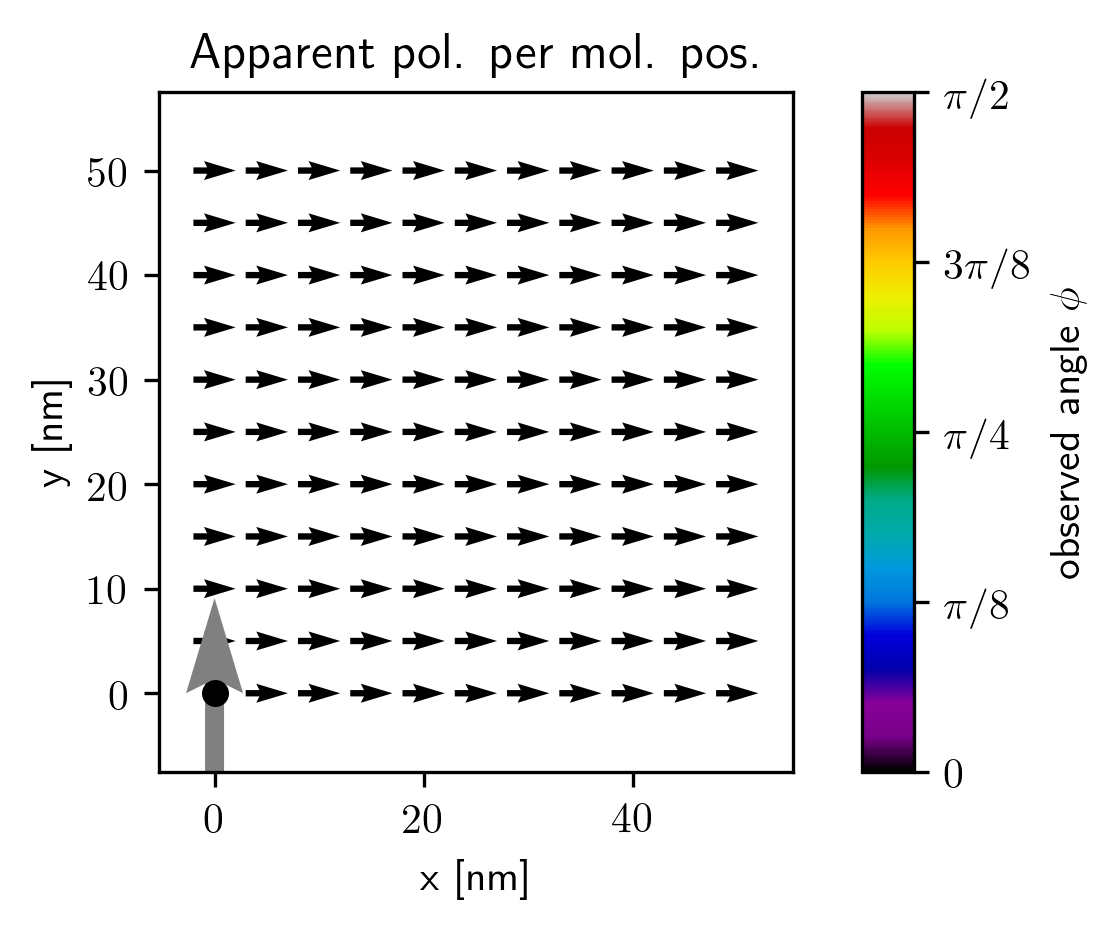

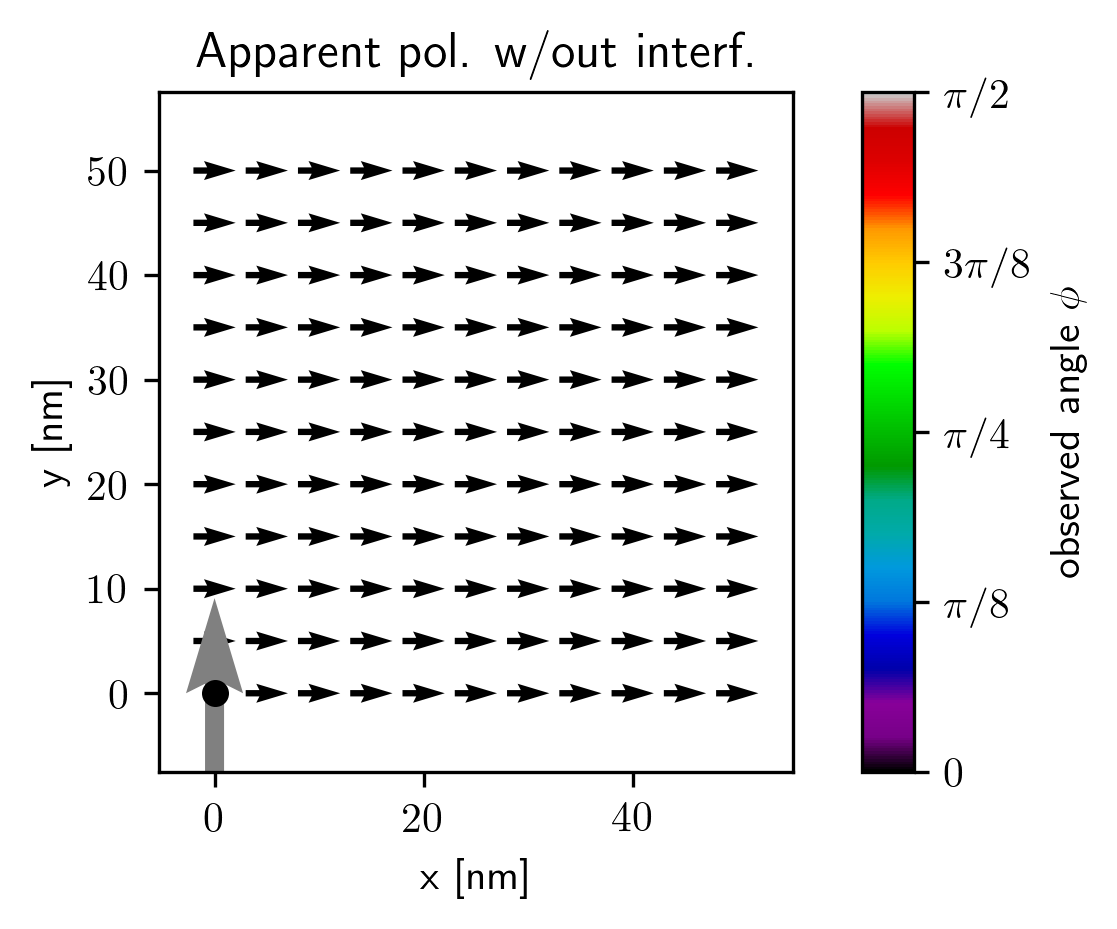

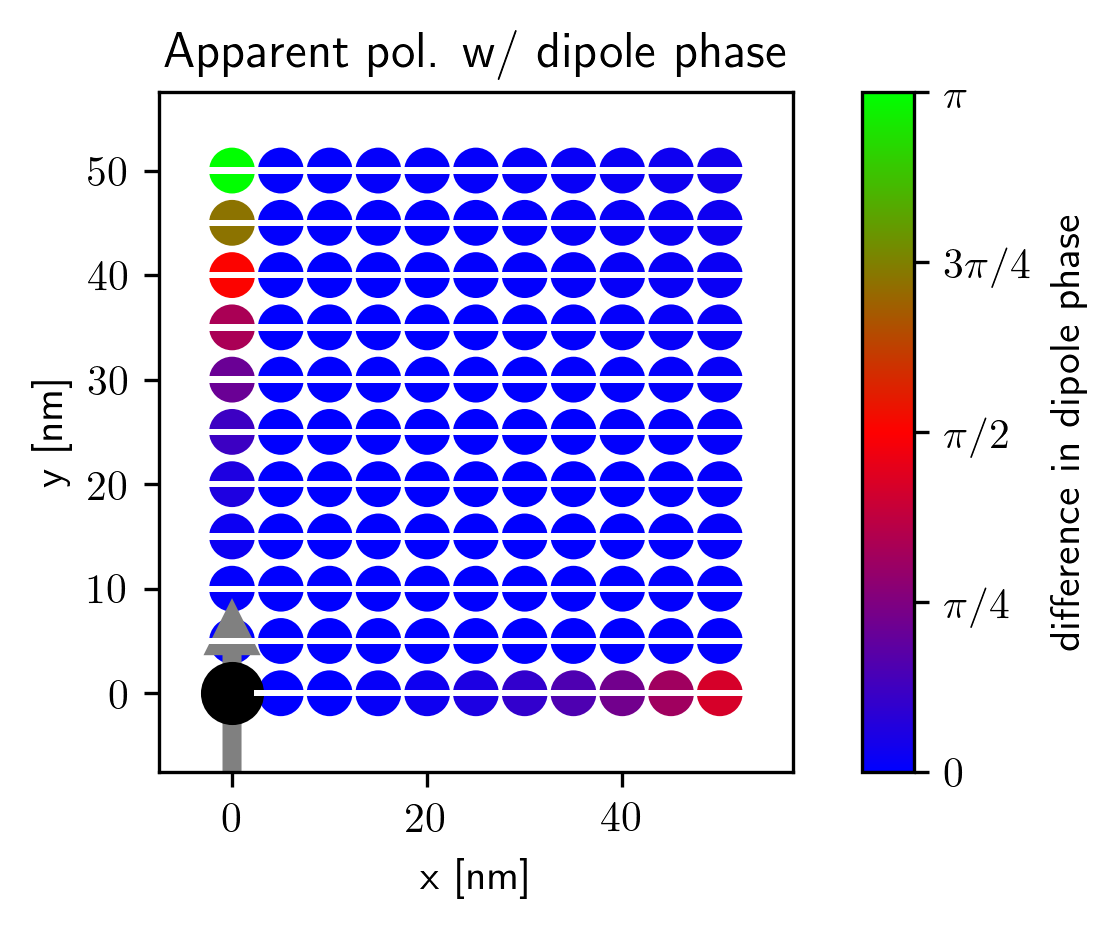

In [15]:
locations = diffi.observation_points(x_min=0, x_max=50, y_min=0, y_max=50, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations, mol_angle=0)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)

plot_limits=[-7.5,57.5]
quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)

## no interf
quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)
## no interference
angles_no_interf, Px_per_drive_I_no_interf, Py_per_drive_I_no_interf= powers_and_angels_no_interf(mol_E,plas_E)
quiver_plot(locations[:,0], locations[:,1], f_inv(angles_no_interf), plot_limits,
           r'Apparent pol. w/out interf.')



plot_phase_quiver(locations[:,0], locations[:,1], f_inv(angles), p0, p1, plot_limits)

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:407: RuntimeWarning: invalid value encountered in true_divide
  n_hat = d_col/d ## returns shape = (...,3)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in multiply
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperR

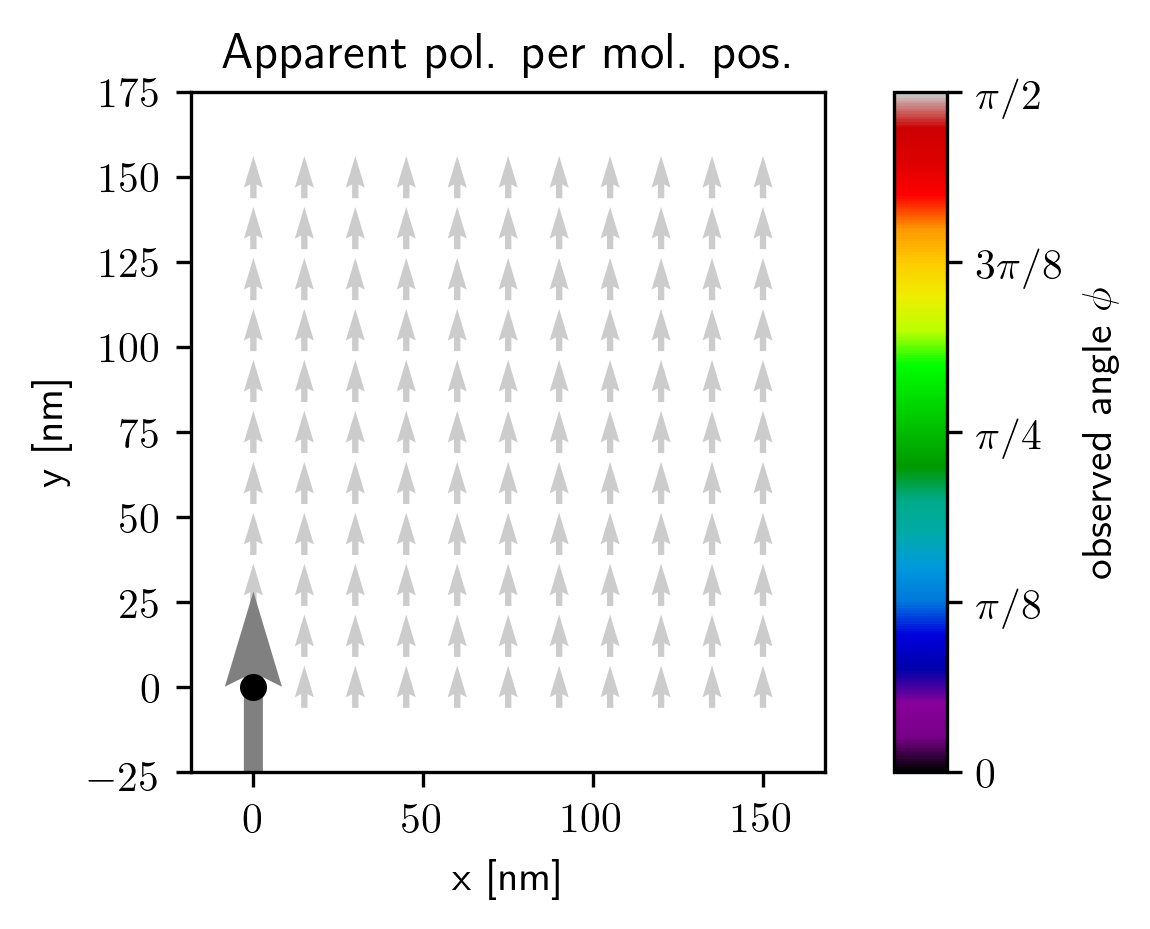

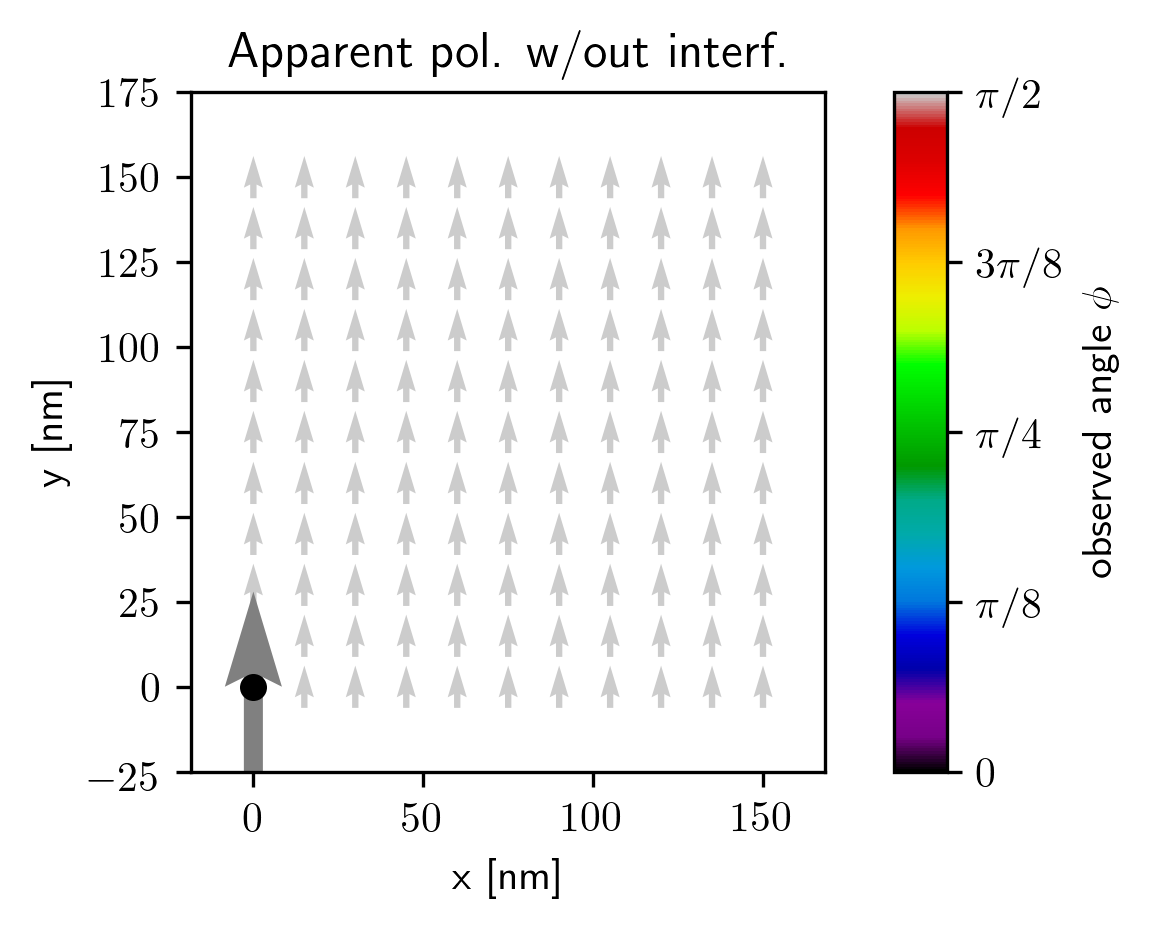

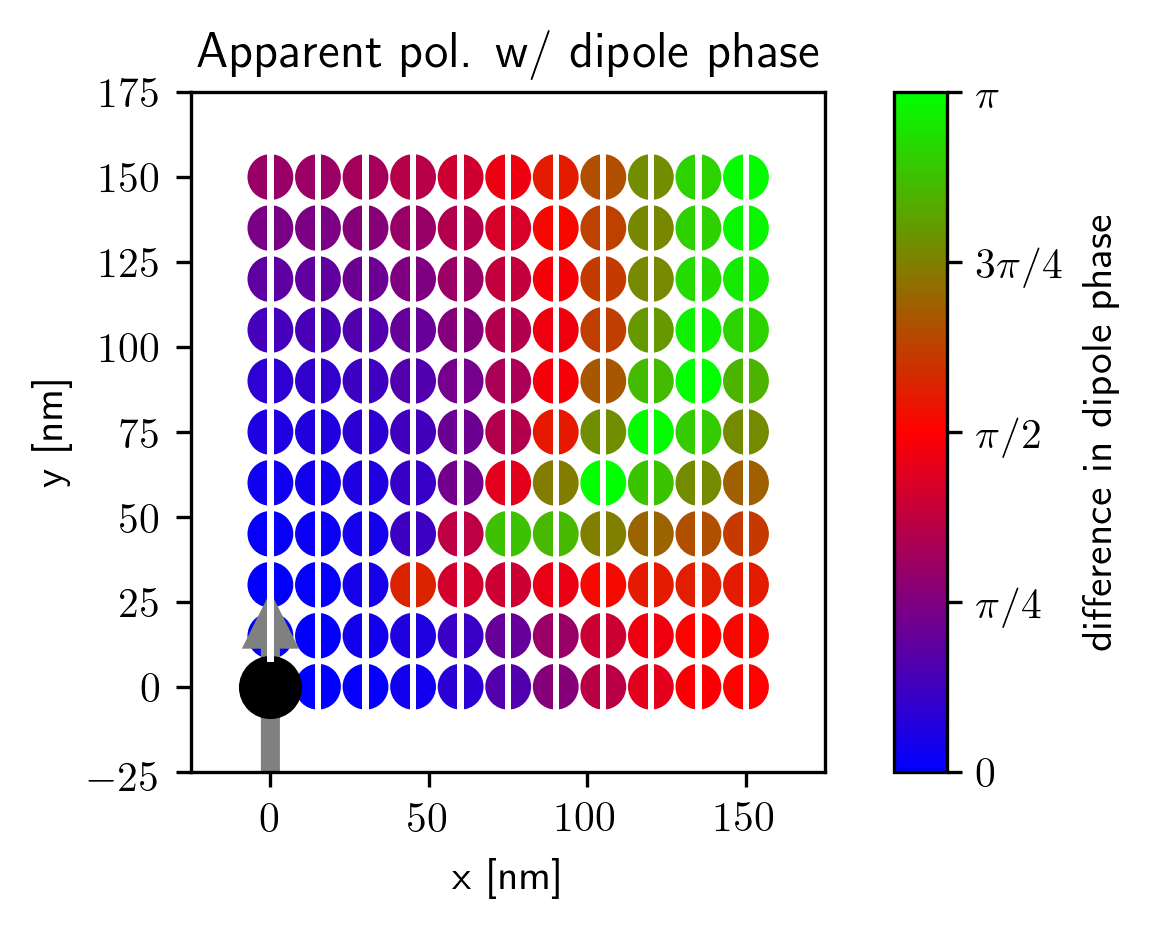

In [16]:
locations = diffi.observation_points(x_min=0, x_max=150, y_min=0, y_max=150, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations, mol_angle=np.pi/2)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)

plot_limits = [-25,175]
quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)

## no interference
angles_no_interf, Px_per_drive_I_no_interf, Py_per_drive_I_no_interf= powers_and_angels_no_interf(mol_E,plas_E)
quiver_plot(locations[:,0], locations[:,1], f_inv(angles_no_interf), plot_limits,
           r'Apparent pol. w/out interf.')


plot_phase_quiver(locations[:,0], locations[:,1], f_inv(angles), p0, p1, plot_limits)

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:407: RuntimeWarning: invalid value encountered in true_divide
  n_hat = d_col/d ## returns shape = (...,3)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in multiply
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperR

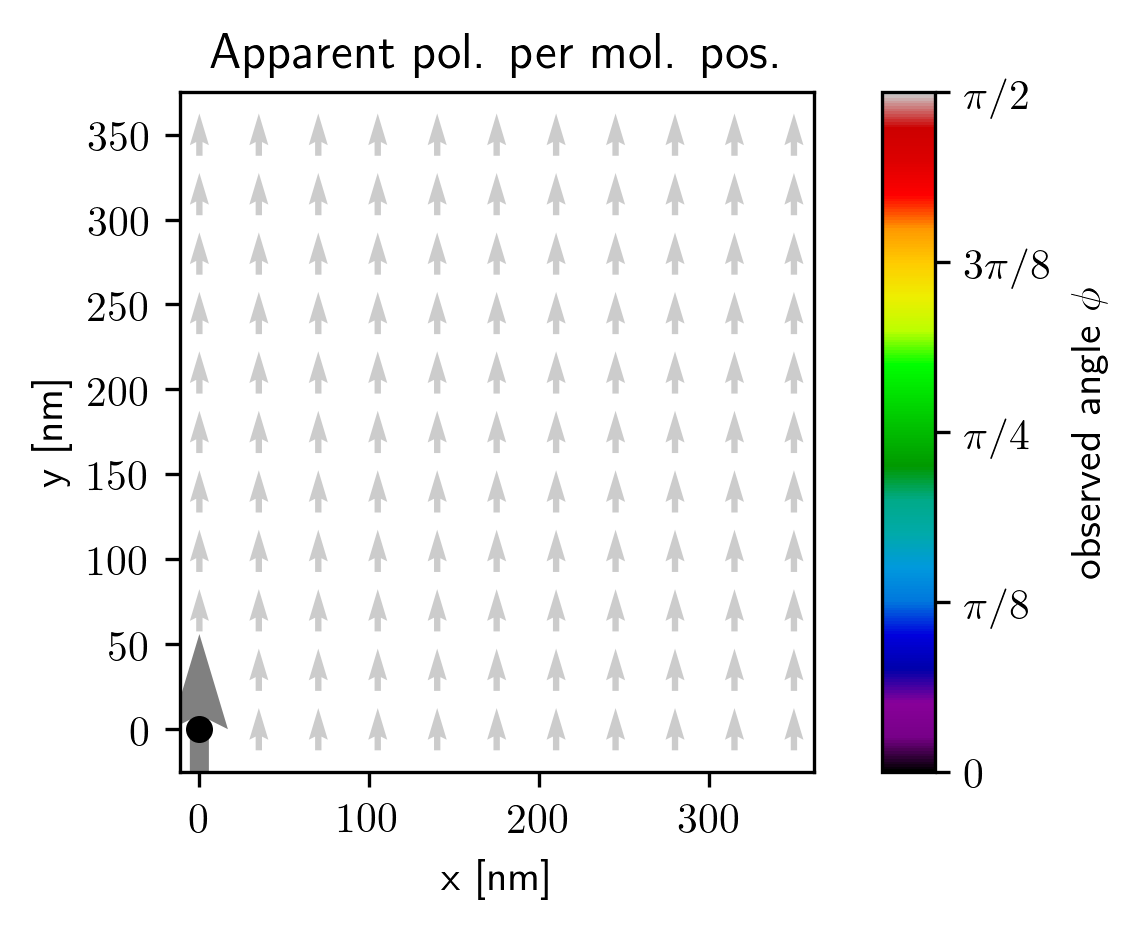

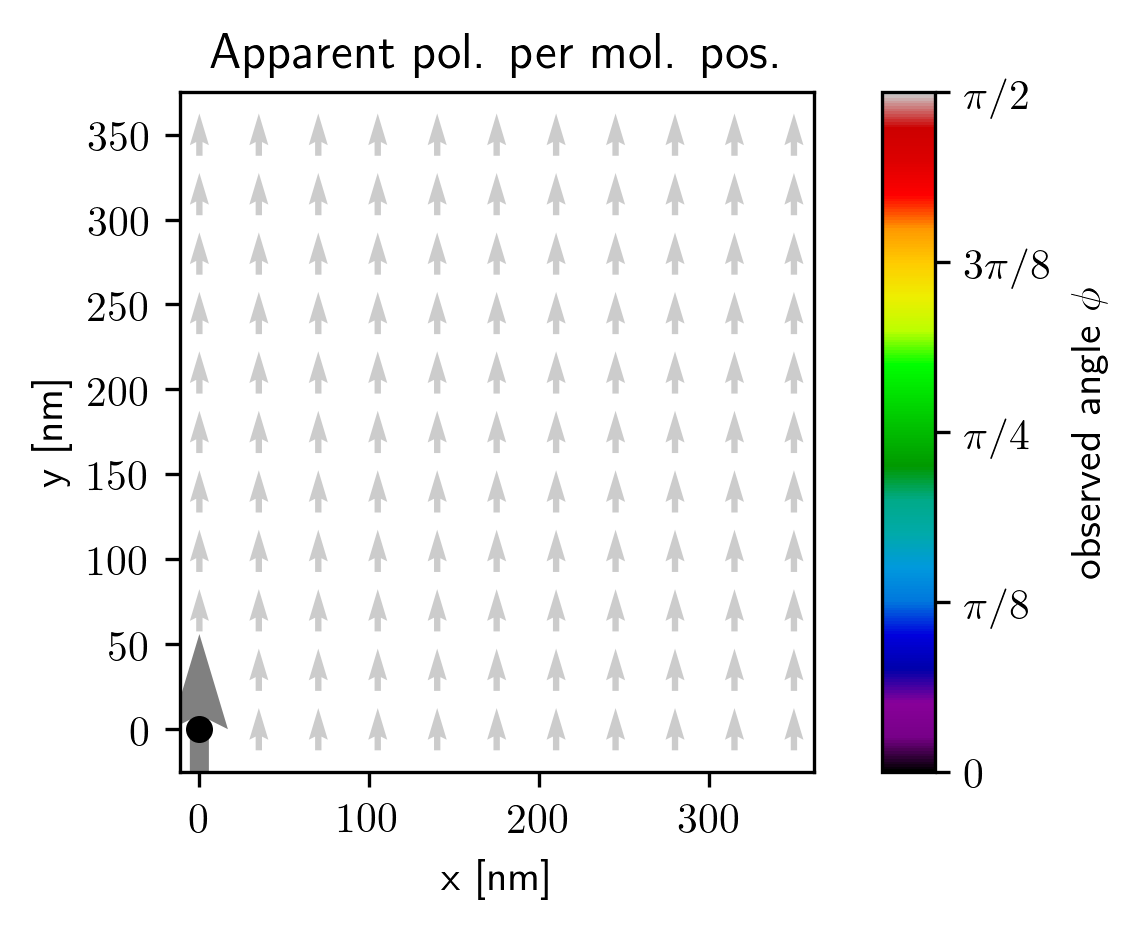

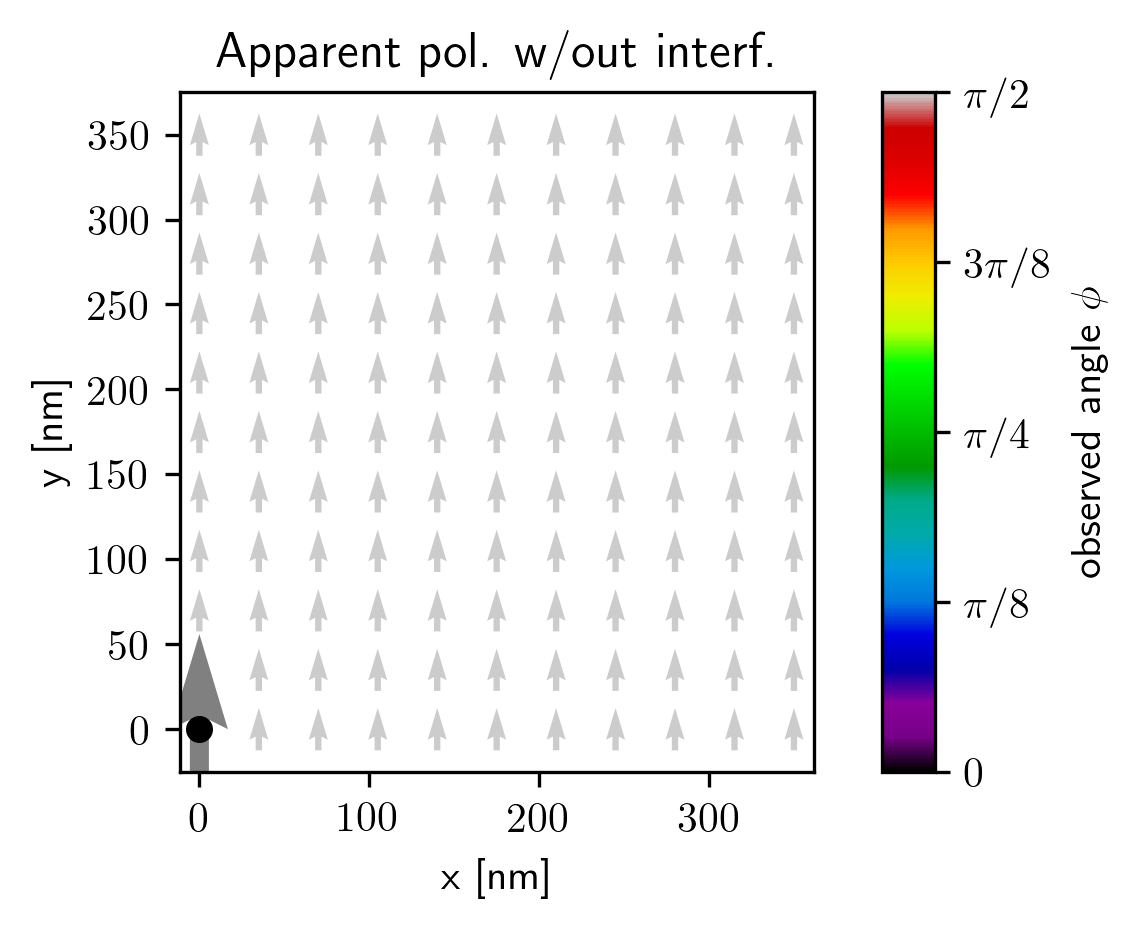

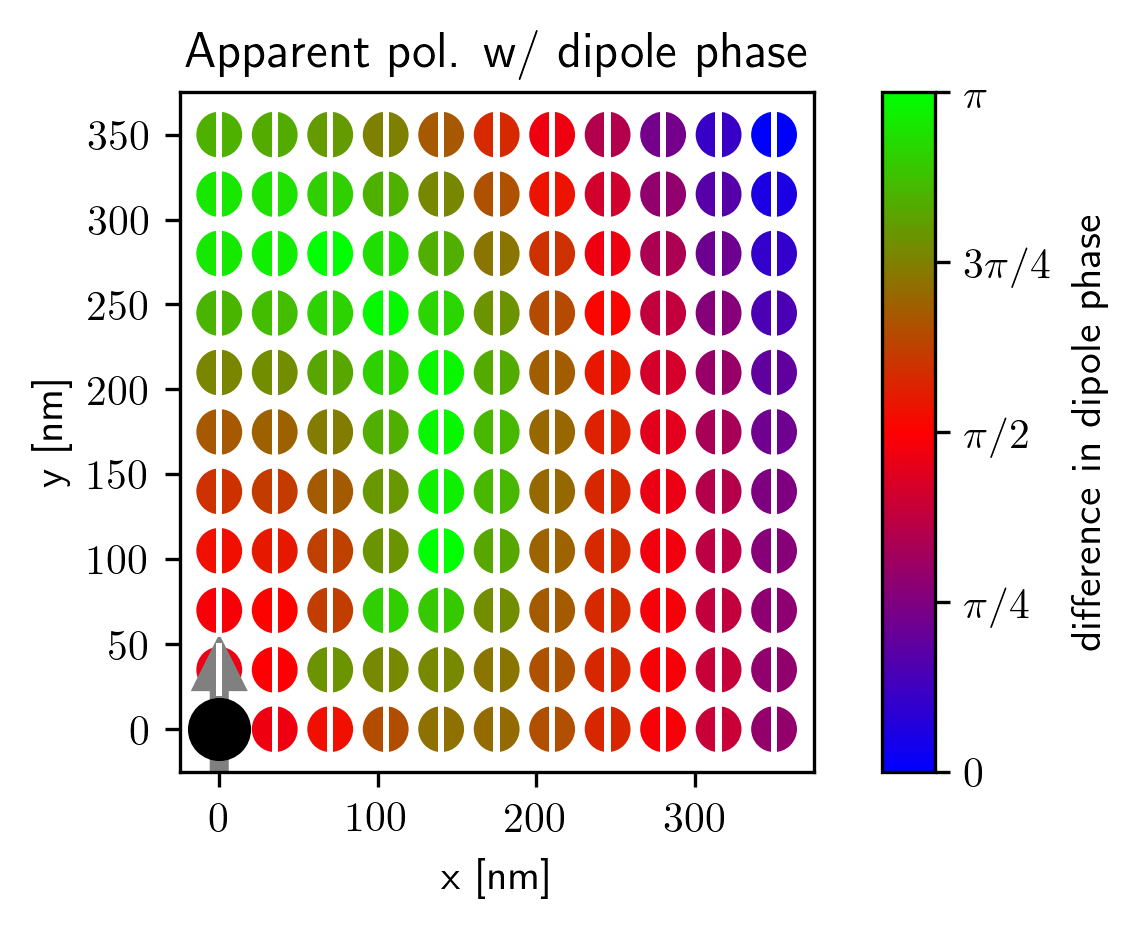

In [17]:
locations = diffi.observation_points(x_min=0, x_max=350, y_min=0, y_max=350, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
plot_limits=[-25,375]

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations, mol_angle=np.pi/2)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)

quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)

##no interference
quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)
## no interference
angles_no_interf, Px_per_drive_I_no_interf, Py_per_drive_I_no_interf= powers_and_angels_no_interf(mol_E,plas_E)
quiver_plot(locations[:,0], locations[:,1], f_inv(angles_no_interf), plot_limits,
           r'Apparent pol. w/out interf.')

plot_phase_quiver(locations[:,0], locations[:,1], f_inv(angles), p0, p1, plot_limits)

/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:407: RuntimeWarning: invalid value encountered in true_divide
  n_hat = d_col/d ## returns shape = (...,3)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: divide by zero encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in true_divide
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperRes/Biteen_colab/Polarization_histograms/python/102418/solving_problems/coupled_dipoles.py:436: RuntimeWarning: invalid value encountered in multiply
  (3.*dyad - np.identity(3)) * (1/d**3.- 1j*k/d**2.)
/Users/chair/Documents/Academia/SuperR

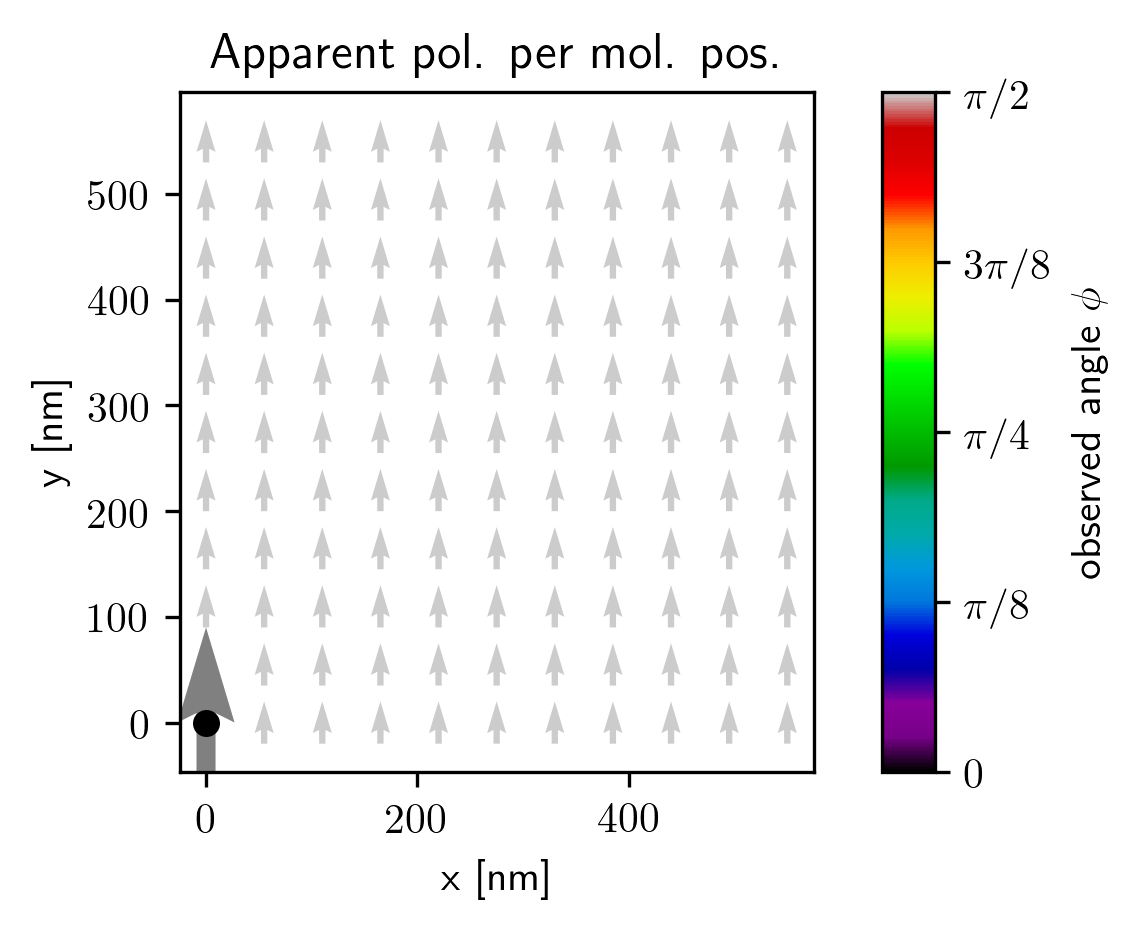

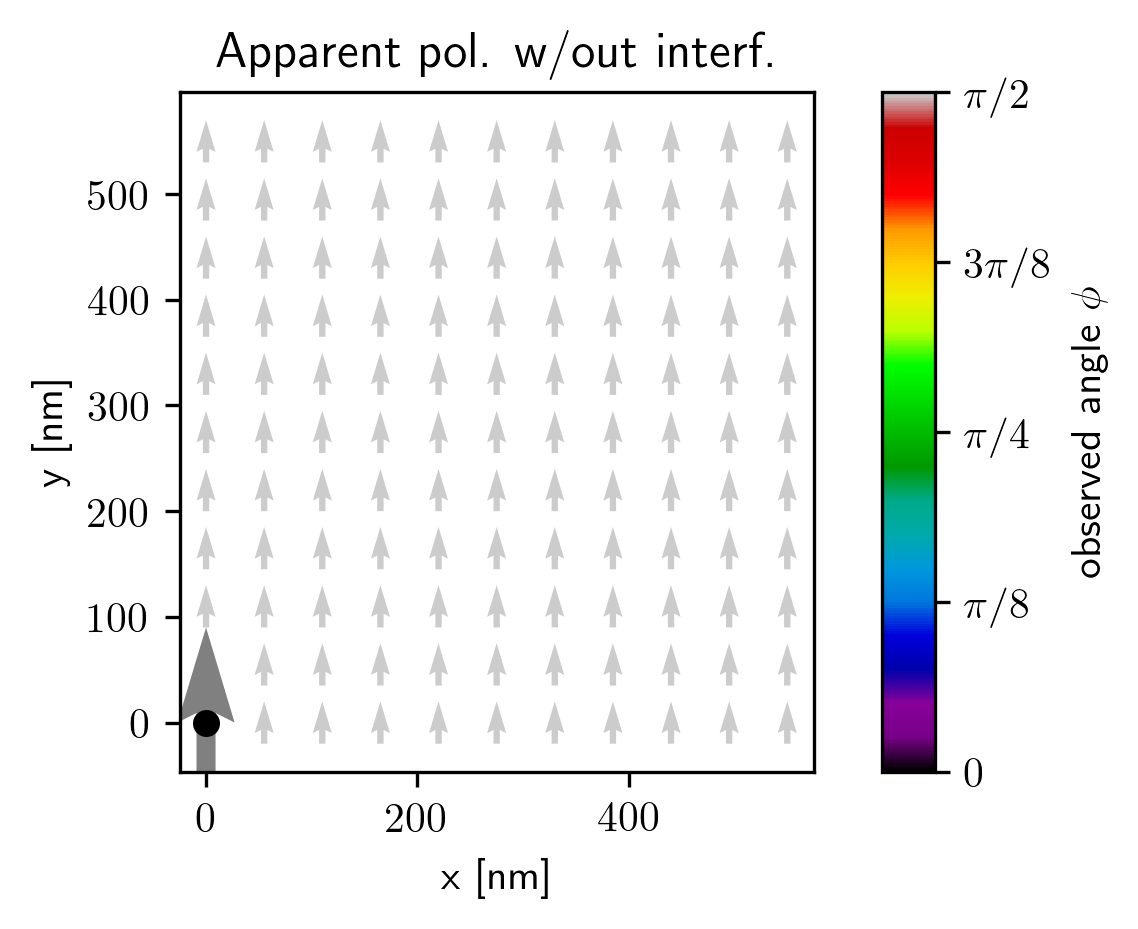

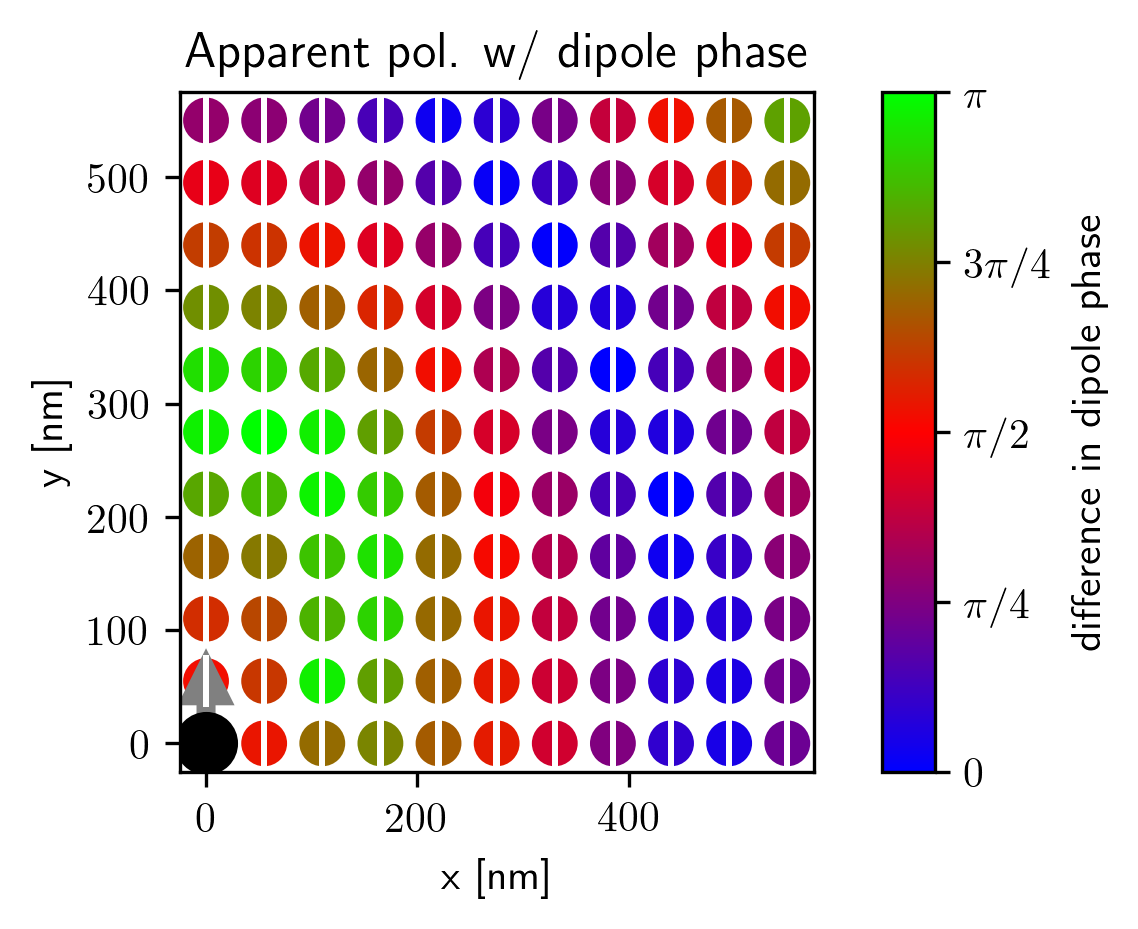

In [18]:
locations = diffi.observation_points(x_min=0, x_max=550, y_min=0, y_max=550, points=11)[0]
locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
plot_limits=[-25,575]

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(locations, mol_angle=np.pi/2)

angles, Px_per_drive_I, Py_per_drive_I = powers_and_angels(mol_E + plas_E)
angles_no_interf, Px_per_drive_I_no_interf, Py_per_drive_I_no_interf= powers_and_angels_no_interf(mol_E,plas_E)
unc_angles, unc_Px_per_drive_I, unc_Py_per_drive_I = powers_and_angels(p0_unc_E)

quiver_plot(locations[:,0], locations[:,1], f_inv(angles), plot_limits)
quiver_plot(locations[:,0], locations[:,1], f_inv(angles_no_interf), plot_limits,
           r'Apparent pol. w/out interf.')
plot_phase_quiver(locations[:,0], locations[:,1], f_inv(angles), p0, p1, plot_limits)


In [19]:
def interference_powers(E1, E2):
    drive_I = np.abs(parameters['general']['drive_amp'])**2.
    
    normed_Ix = 2*np.real(E1[0]*np.conj(E2[0]))**2. / drive_I
    normed_Iy = 2*np.real(E1[1]*np.conj(E2[1]))**2. / drive_I

    Px_per_drive_I = np.sum(normed_Ix,axis=-1) / sensor_size**2.
    Py_per_drive_I = np.sum(normed_Iy,axis=-1) / sensor_size**2.
    
    Ix_angle = np.angle(E1[0]*np.conj(E2[0]))
    Iy_angle = np.angle(E1[1]*np.conj(E2[1]))
#     angles = np.arctan(Py_per_drive_I**0.5/Px_per_drive_I**0.5)It's Really Mohammed Madison looks like appointment optionI really with it attached to it and came out marking like curly guys right next field any likes what's it before actually has the camera into my faxAnd the one
    return [Ix_angle, Iy_angle, Px_per_drive_I, Py_per_drive_I]

In [20]:
Ix_angle, Iy_angle, Px_int, Py_int = interference_powers(mol_E, plas_E)

want to plot fields to explain interference

In [21]:
# locations = diffi.observation_points(x_min=0, x_max=550, y_min=250, y_max=550, points=1)[0]
# locations = np.hstack((locations,np.zeros((locations.shape[0],1))))
location = np.array([[5,250,0]])
plot_limits=[-25,375]

mol_E, plas_E, p0_unc_E, p0, p1 = dipole_fields(location, mol_angle=np.pi/2)



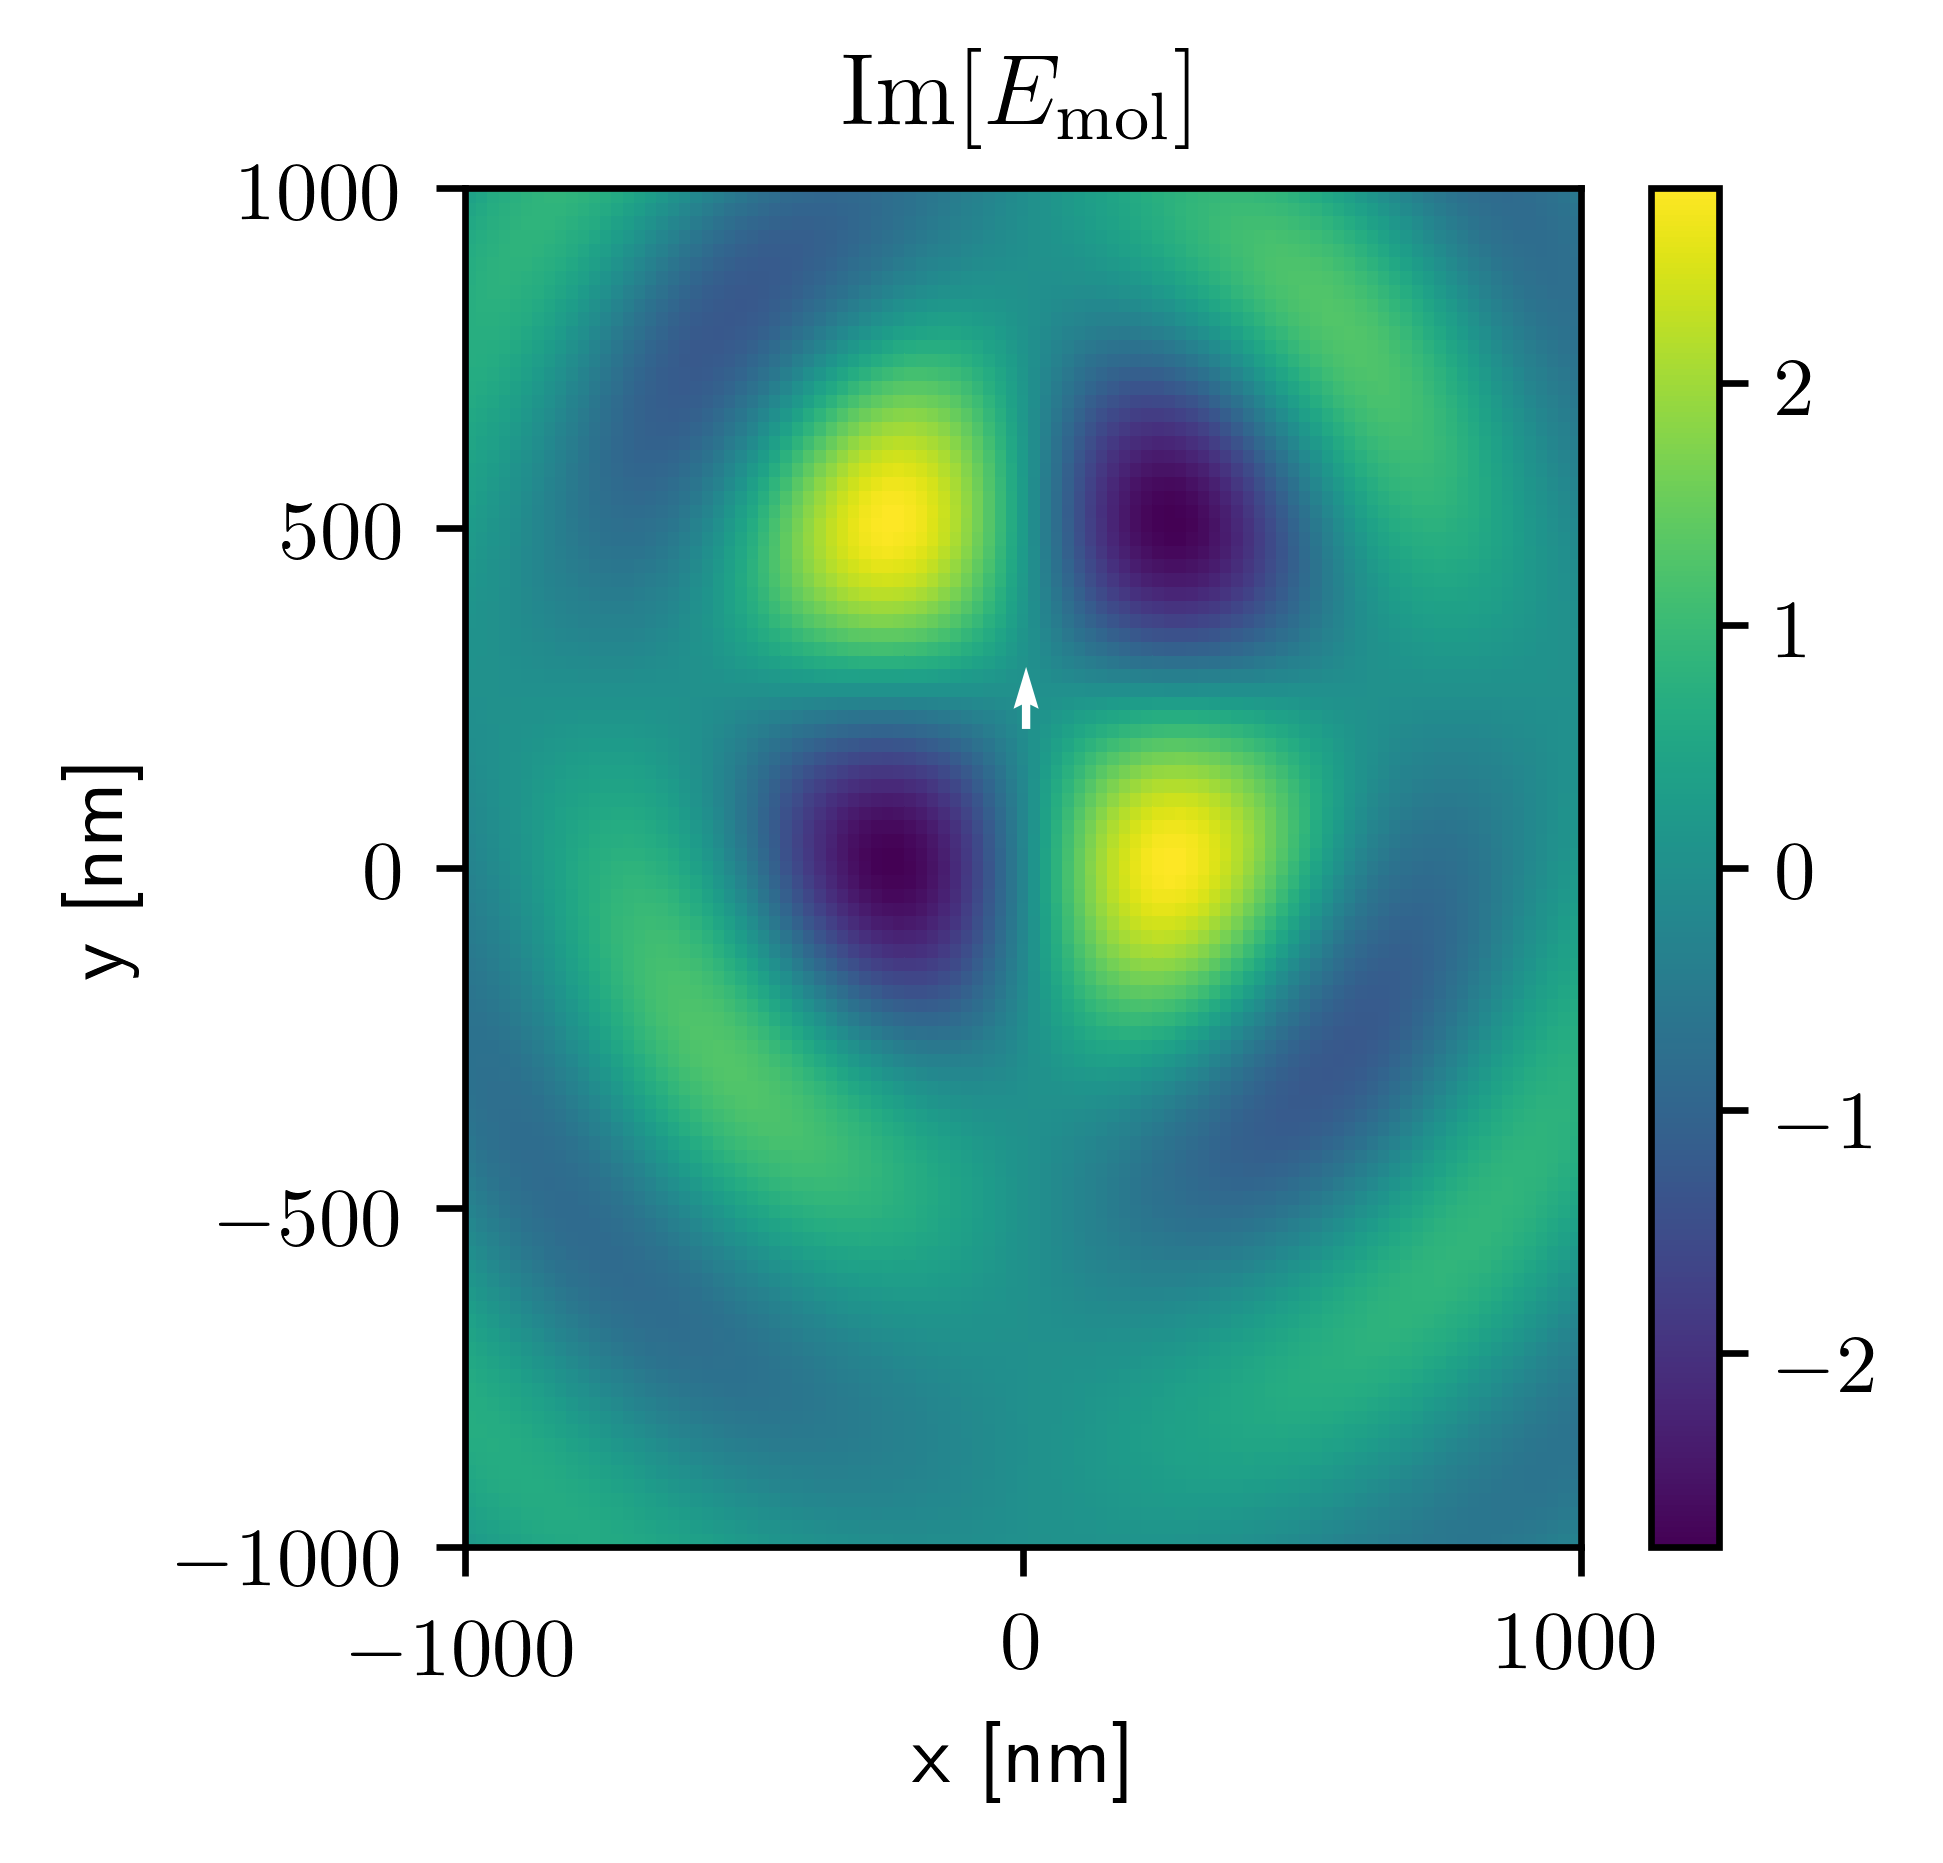

In [22]:
plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,np.imag((mol_E[0,0]).reshape((100,100))))
plt.colorbar()
plt.title(r'$\mathrm{Im}[E_\mathrm{mol}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([5],[250],[0],[1], color='white',pivot='middle')


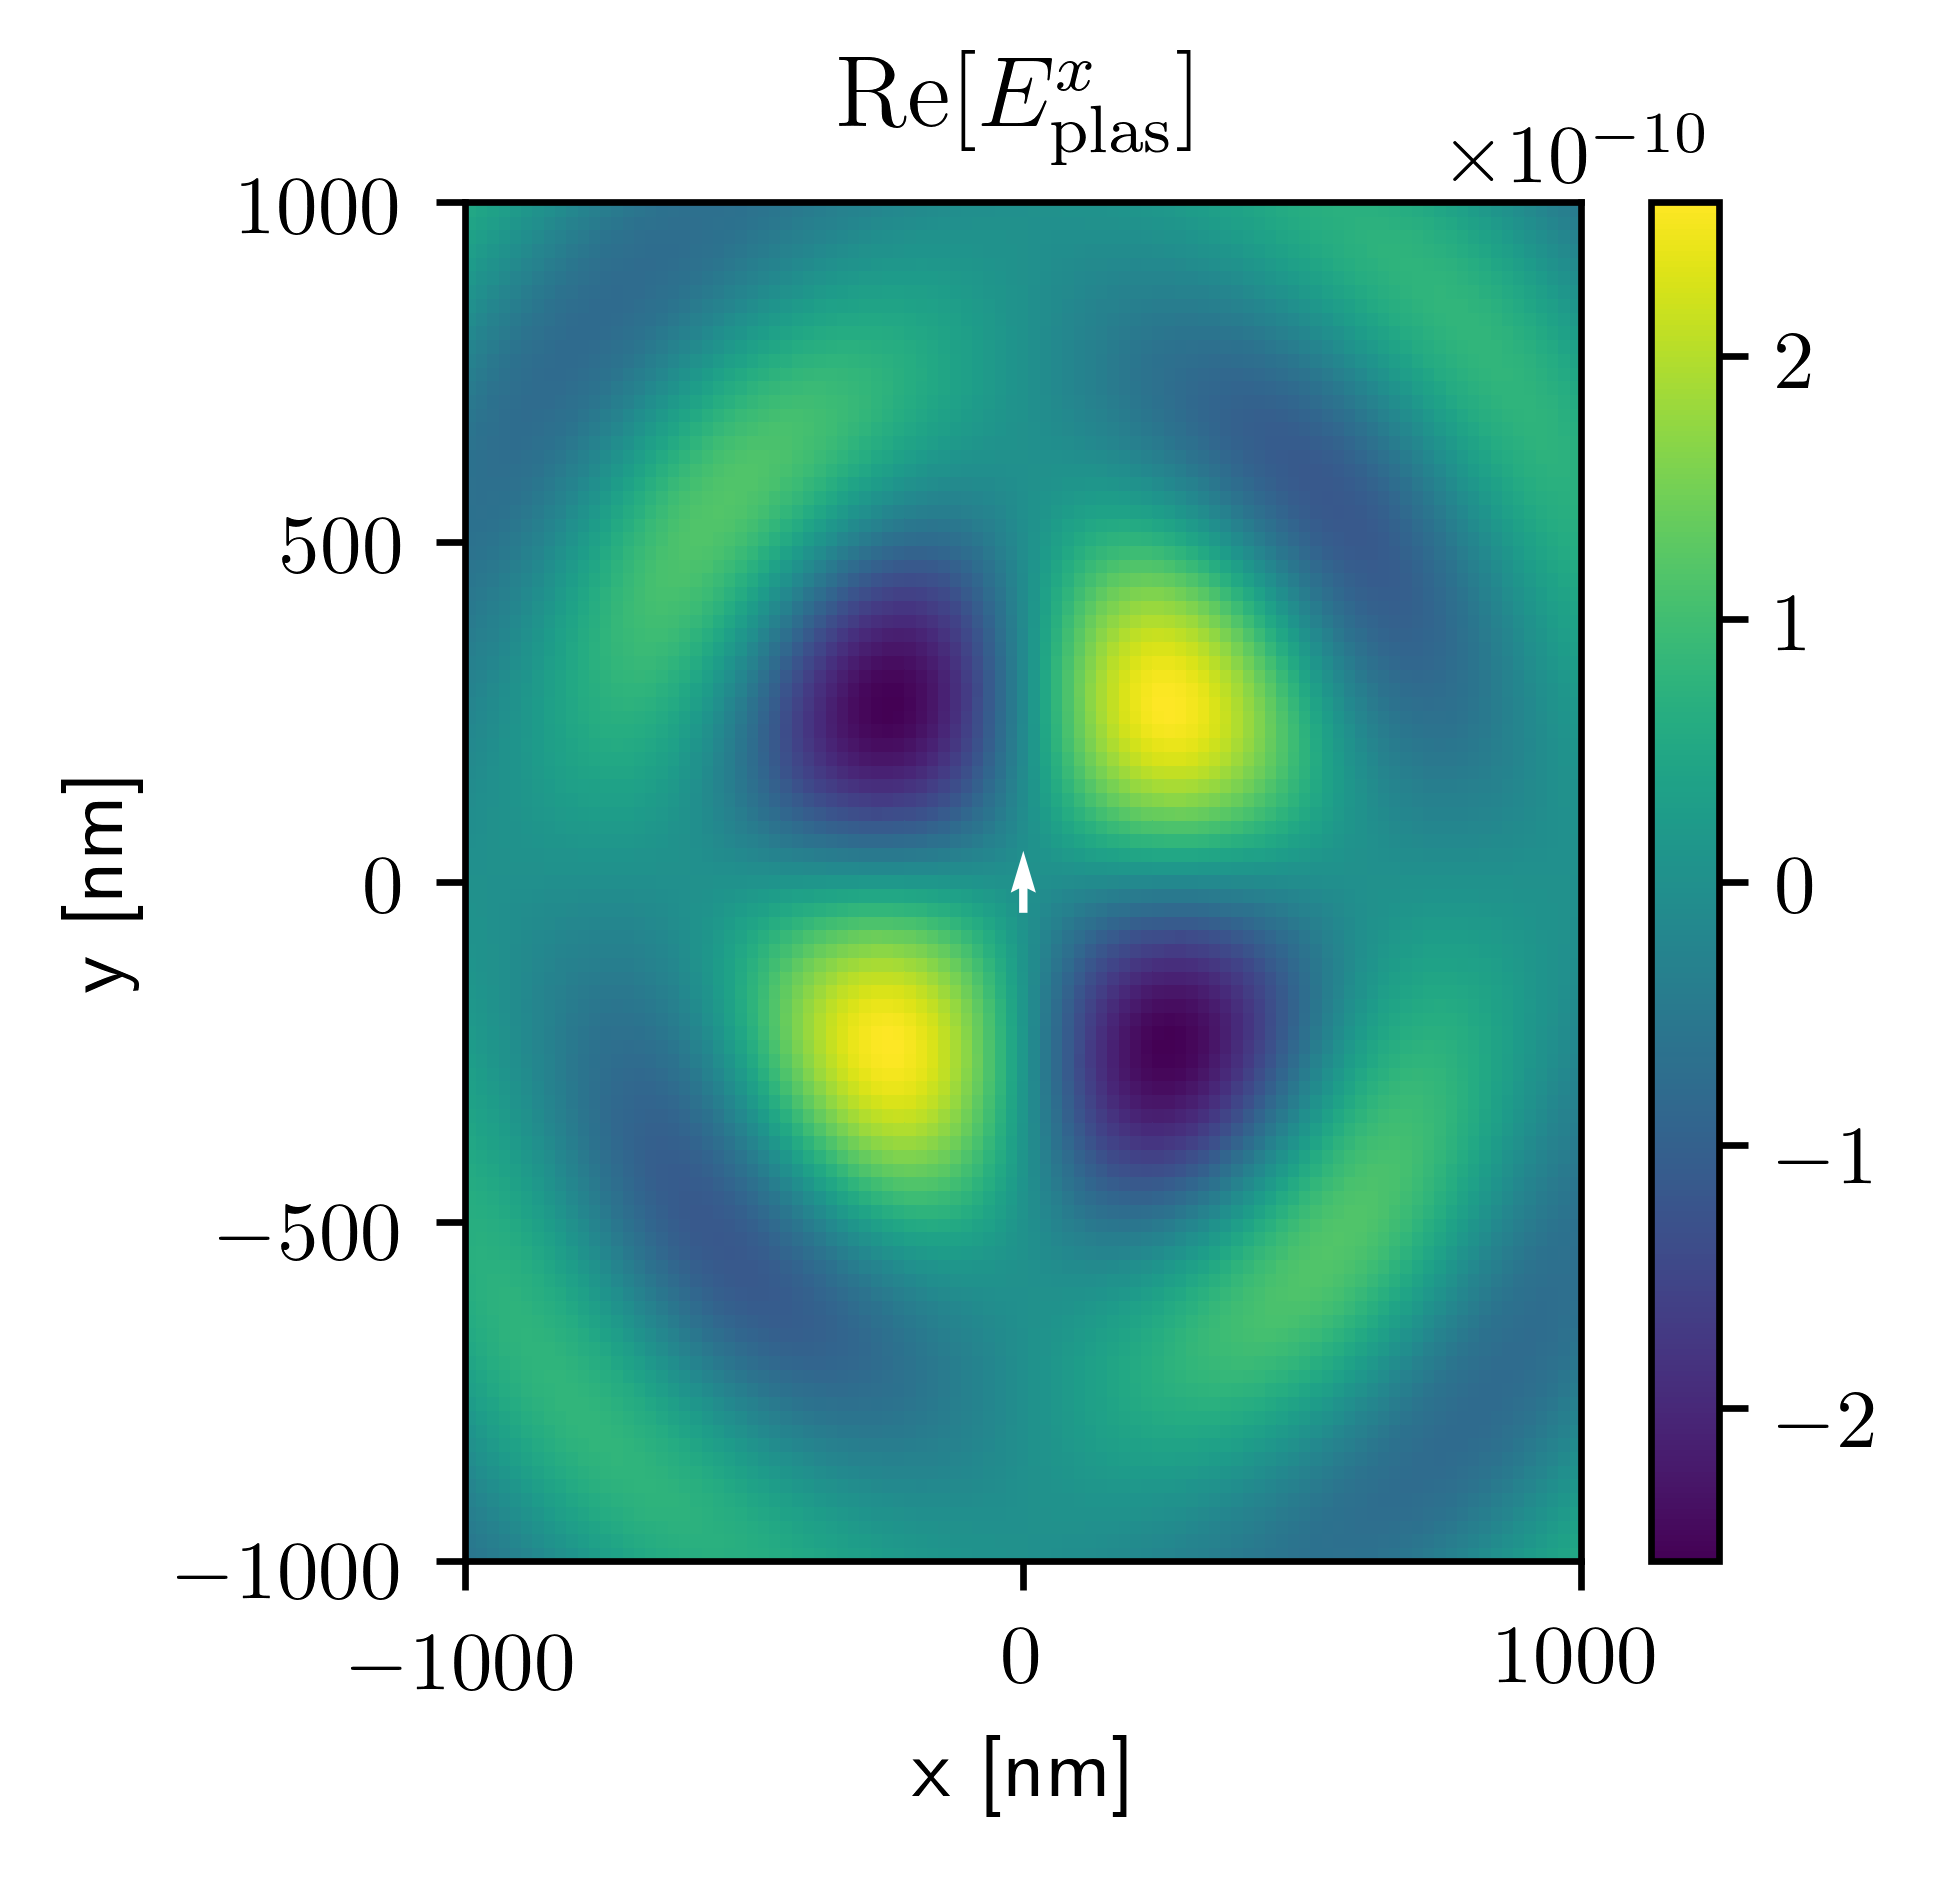

In [23]:

plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,np.real((plas_E[0,0]).reshape((100,100))))
plt.colorbar()
plt.title(r'$\mathrm{Re}[E^x_\mathrm{plas}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([0],[0],[0],[1], color='white',pivot='middle')

In [24]:
np.abs(p0)

array([[1.34008181e-30, 2.18851967e-14, 0.00000000e+00]])

In [25]:
np.abs(p1)

array([[2.83336568e-40, 4.62723731e-24, 0.00000000e+00]])

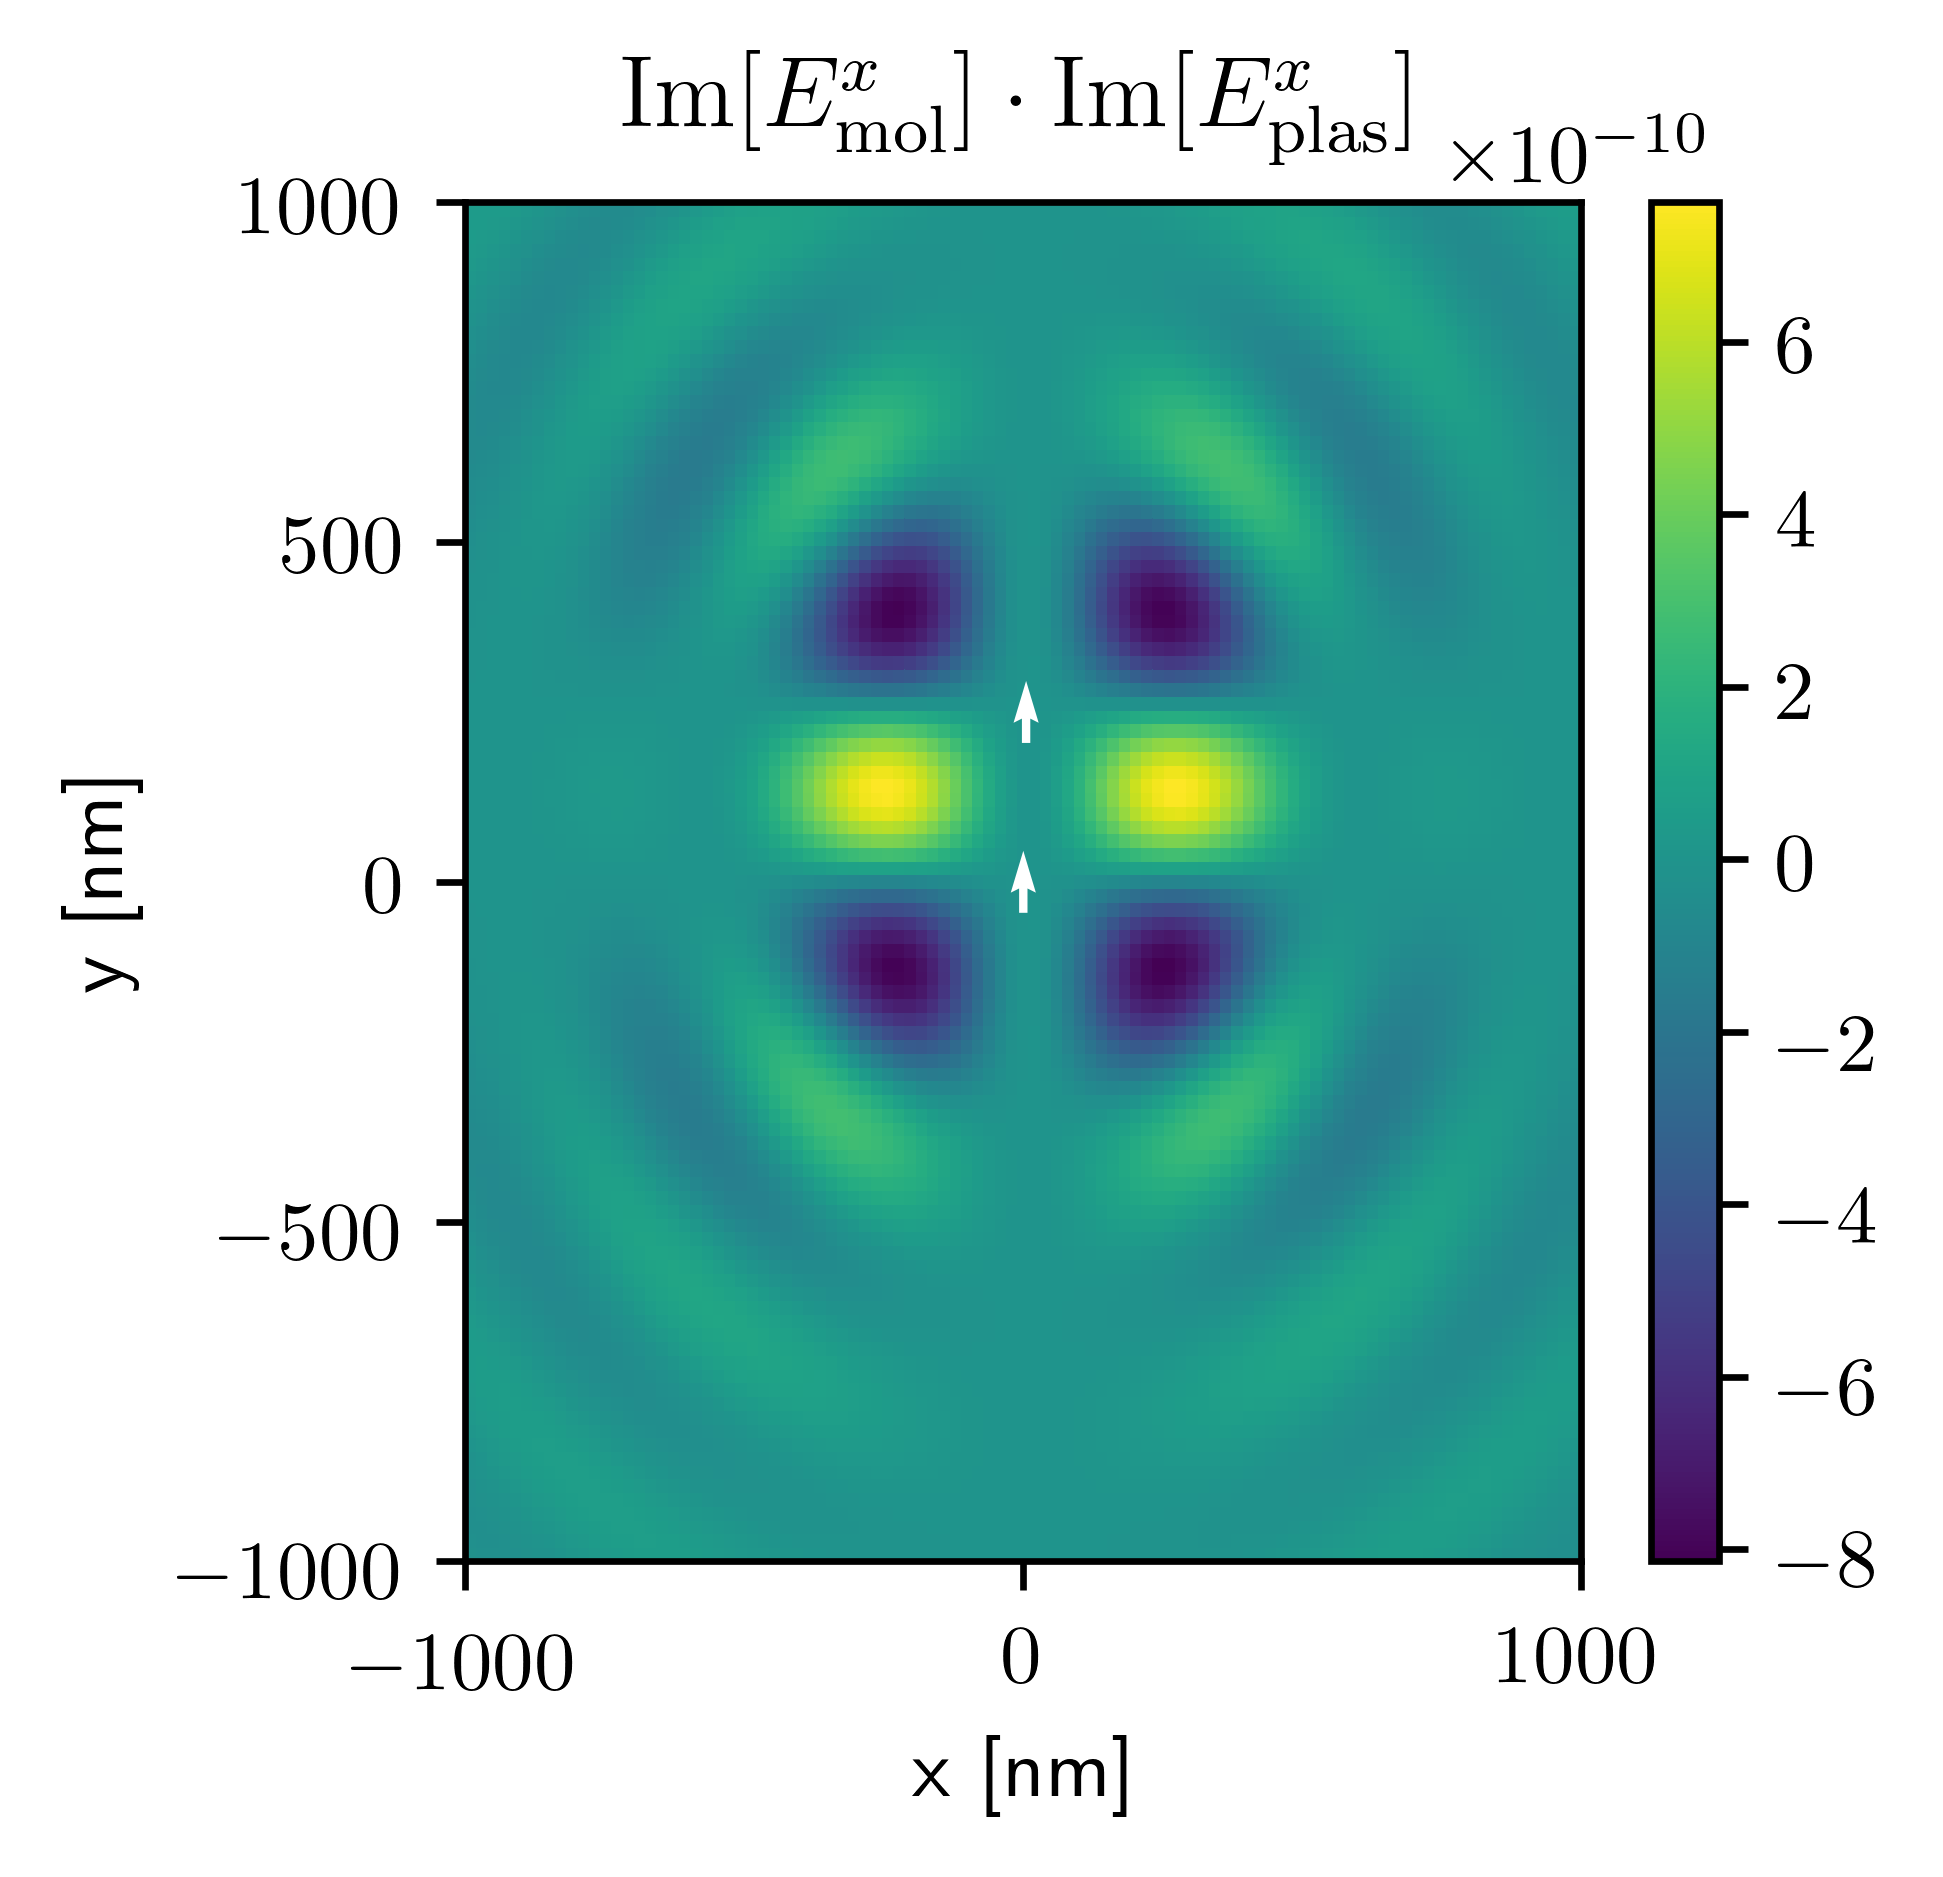

In [26]:

plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,(np.imag(plas_E[0,0])*np.imag(mol_E[0,0])).reshape((100,100)))
plt.colorbar()
plt.title(r'$\mathrm{Im}[E^x_\mathrm{mol}]\cdot\mathrm{Im}[E^x_\mathrm{plas}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([0,5],[0,250],[0,0], [1,1],color='white',pivot='middle')

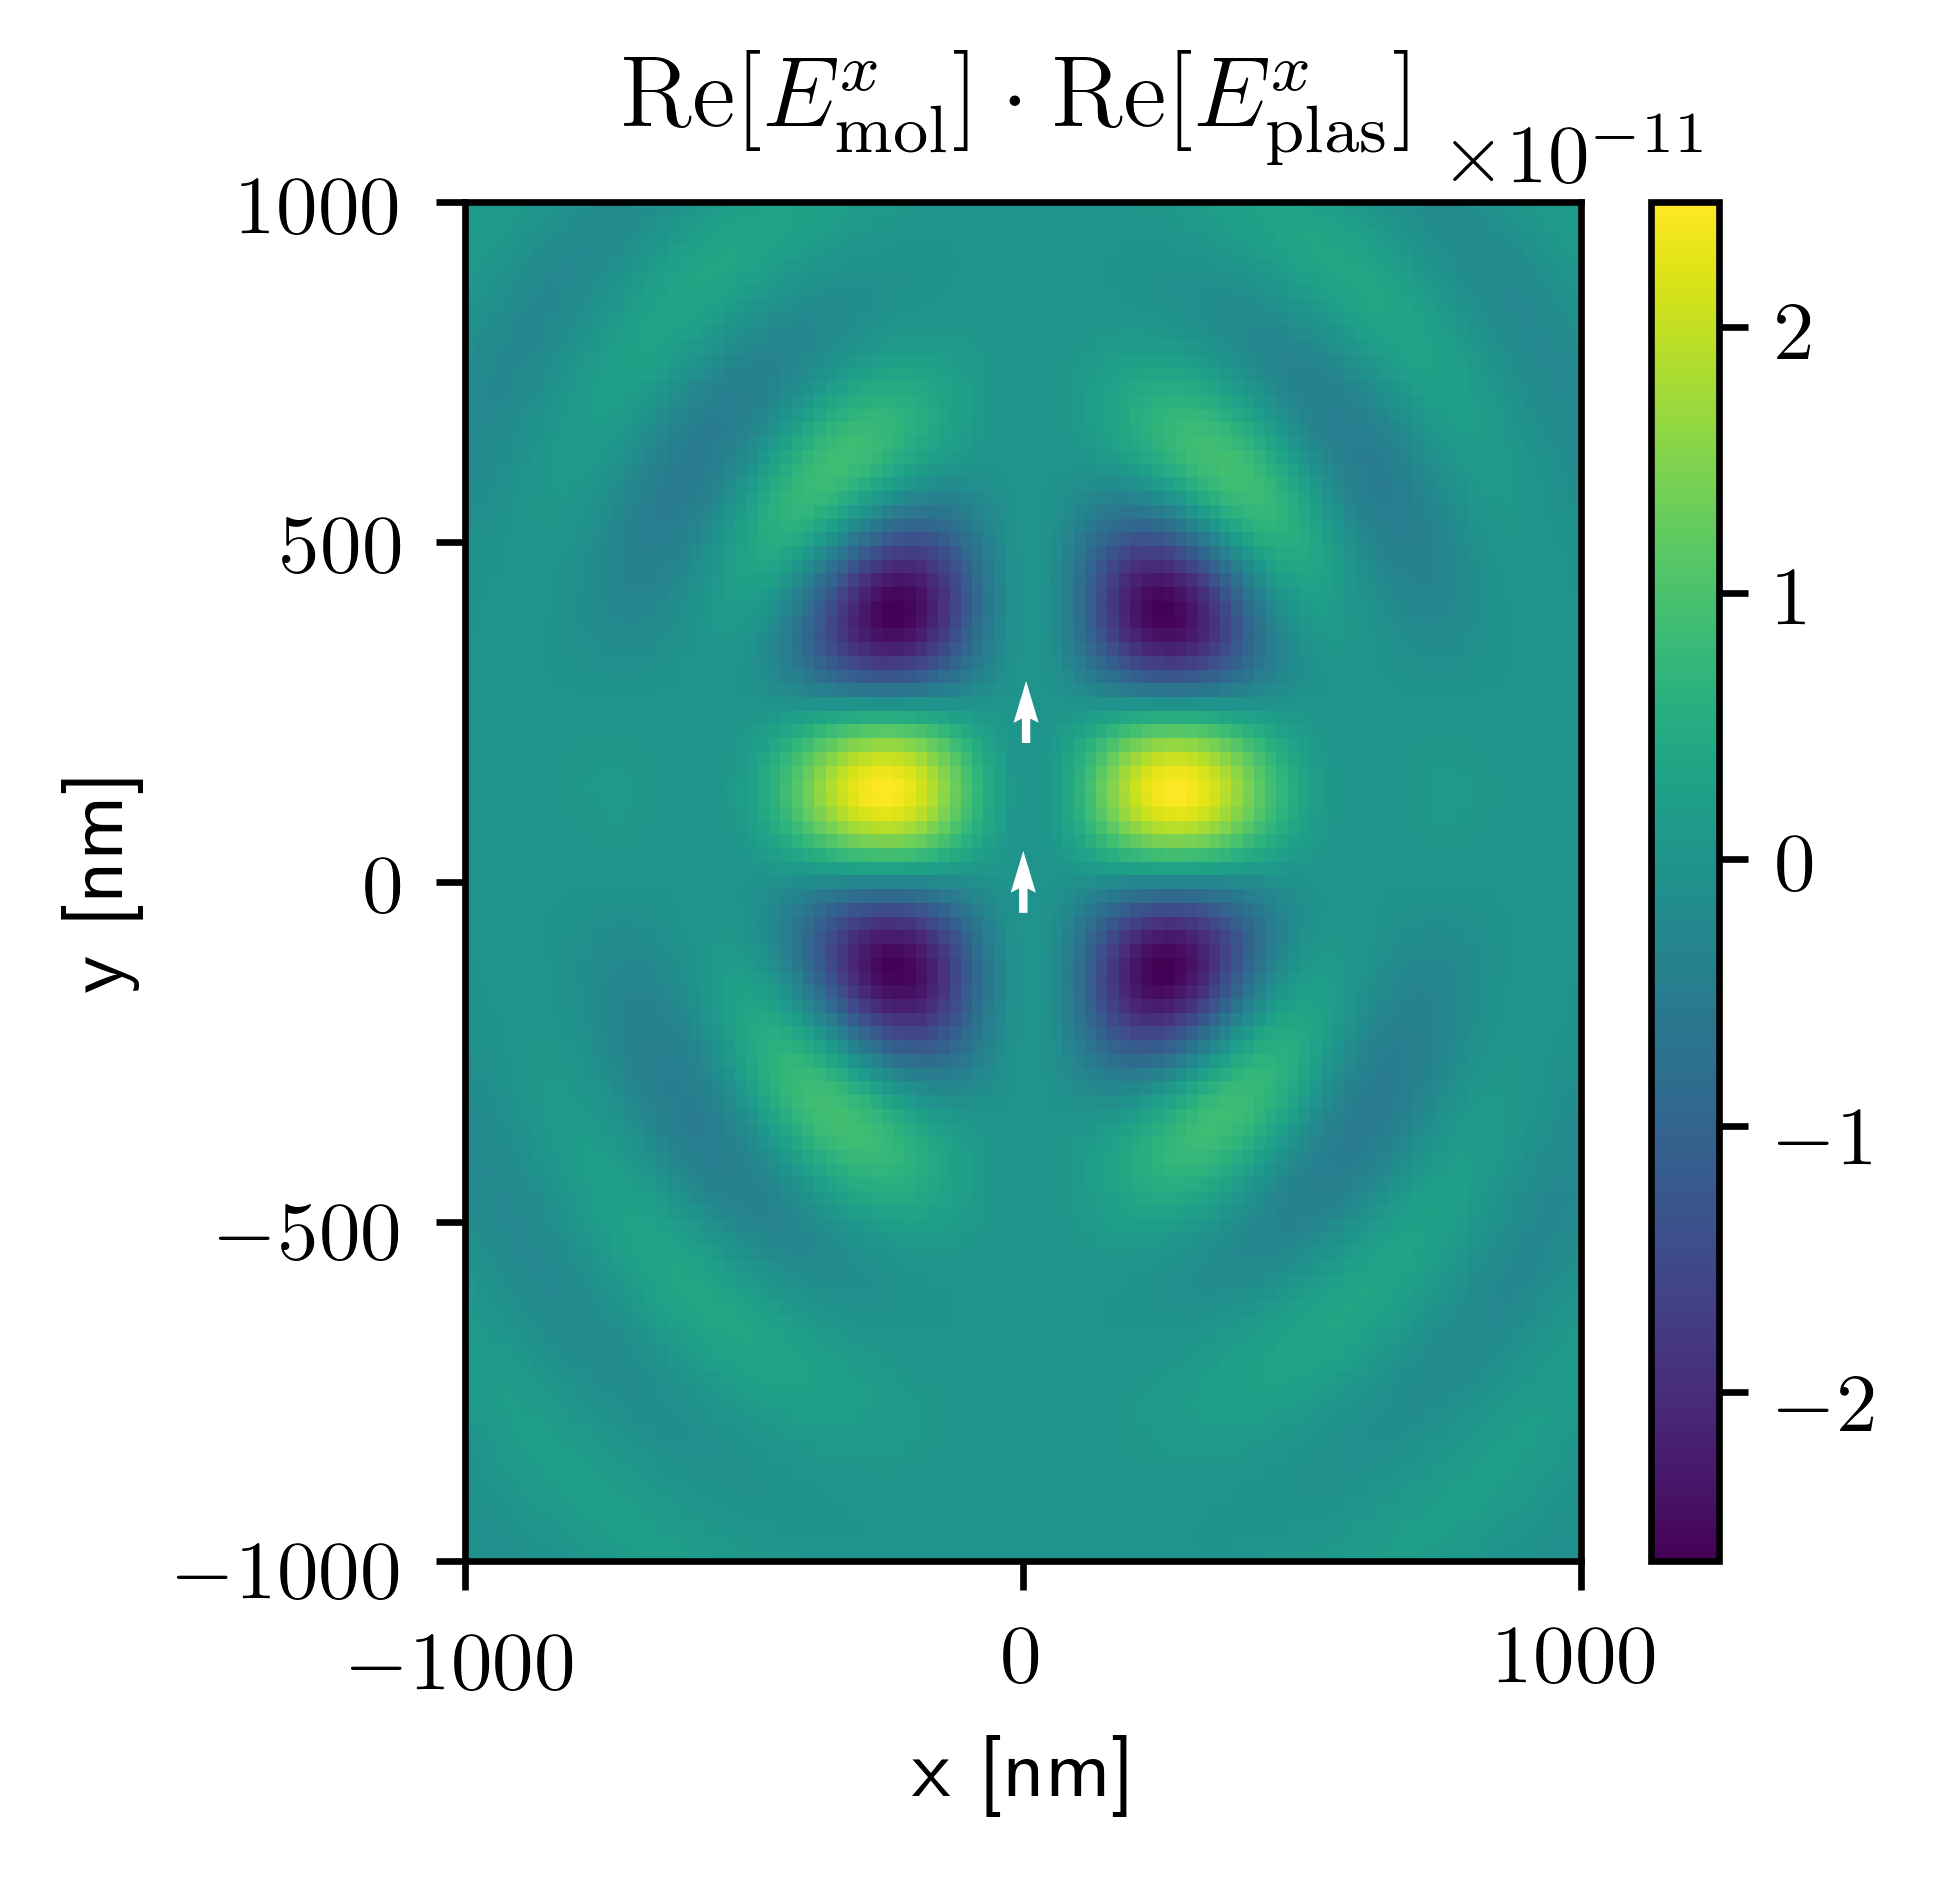

In [27]:

plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,(np.real(plas_E[0,0])*np.real(mol_E[0,0])).reshape((100,100)))
plt.colorbar()
plt.title(r'$\mathrm{Re}[E^x_\mathrm{mol}]\cdot\mathrm{Re}[E^x_\mathrm{plas}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([0,5],[0,250],[0,0],[1,1], color='white',pivot='middle')

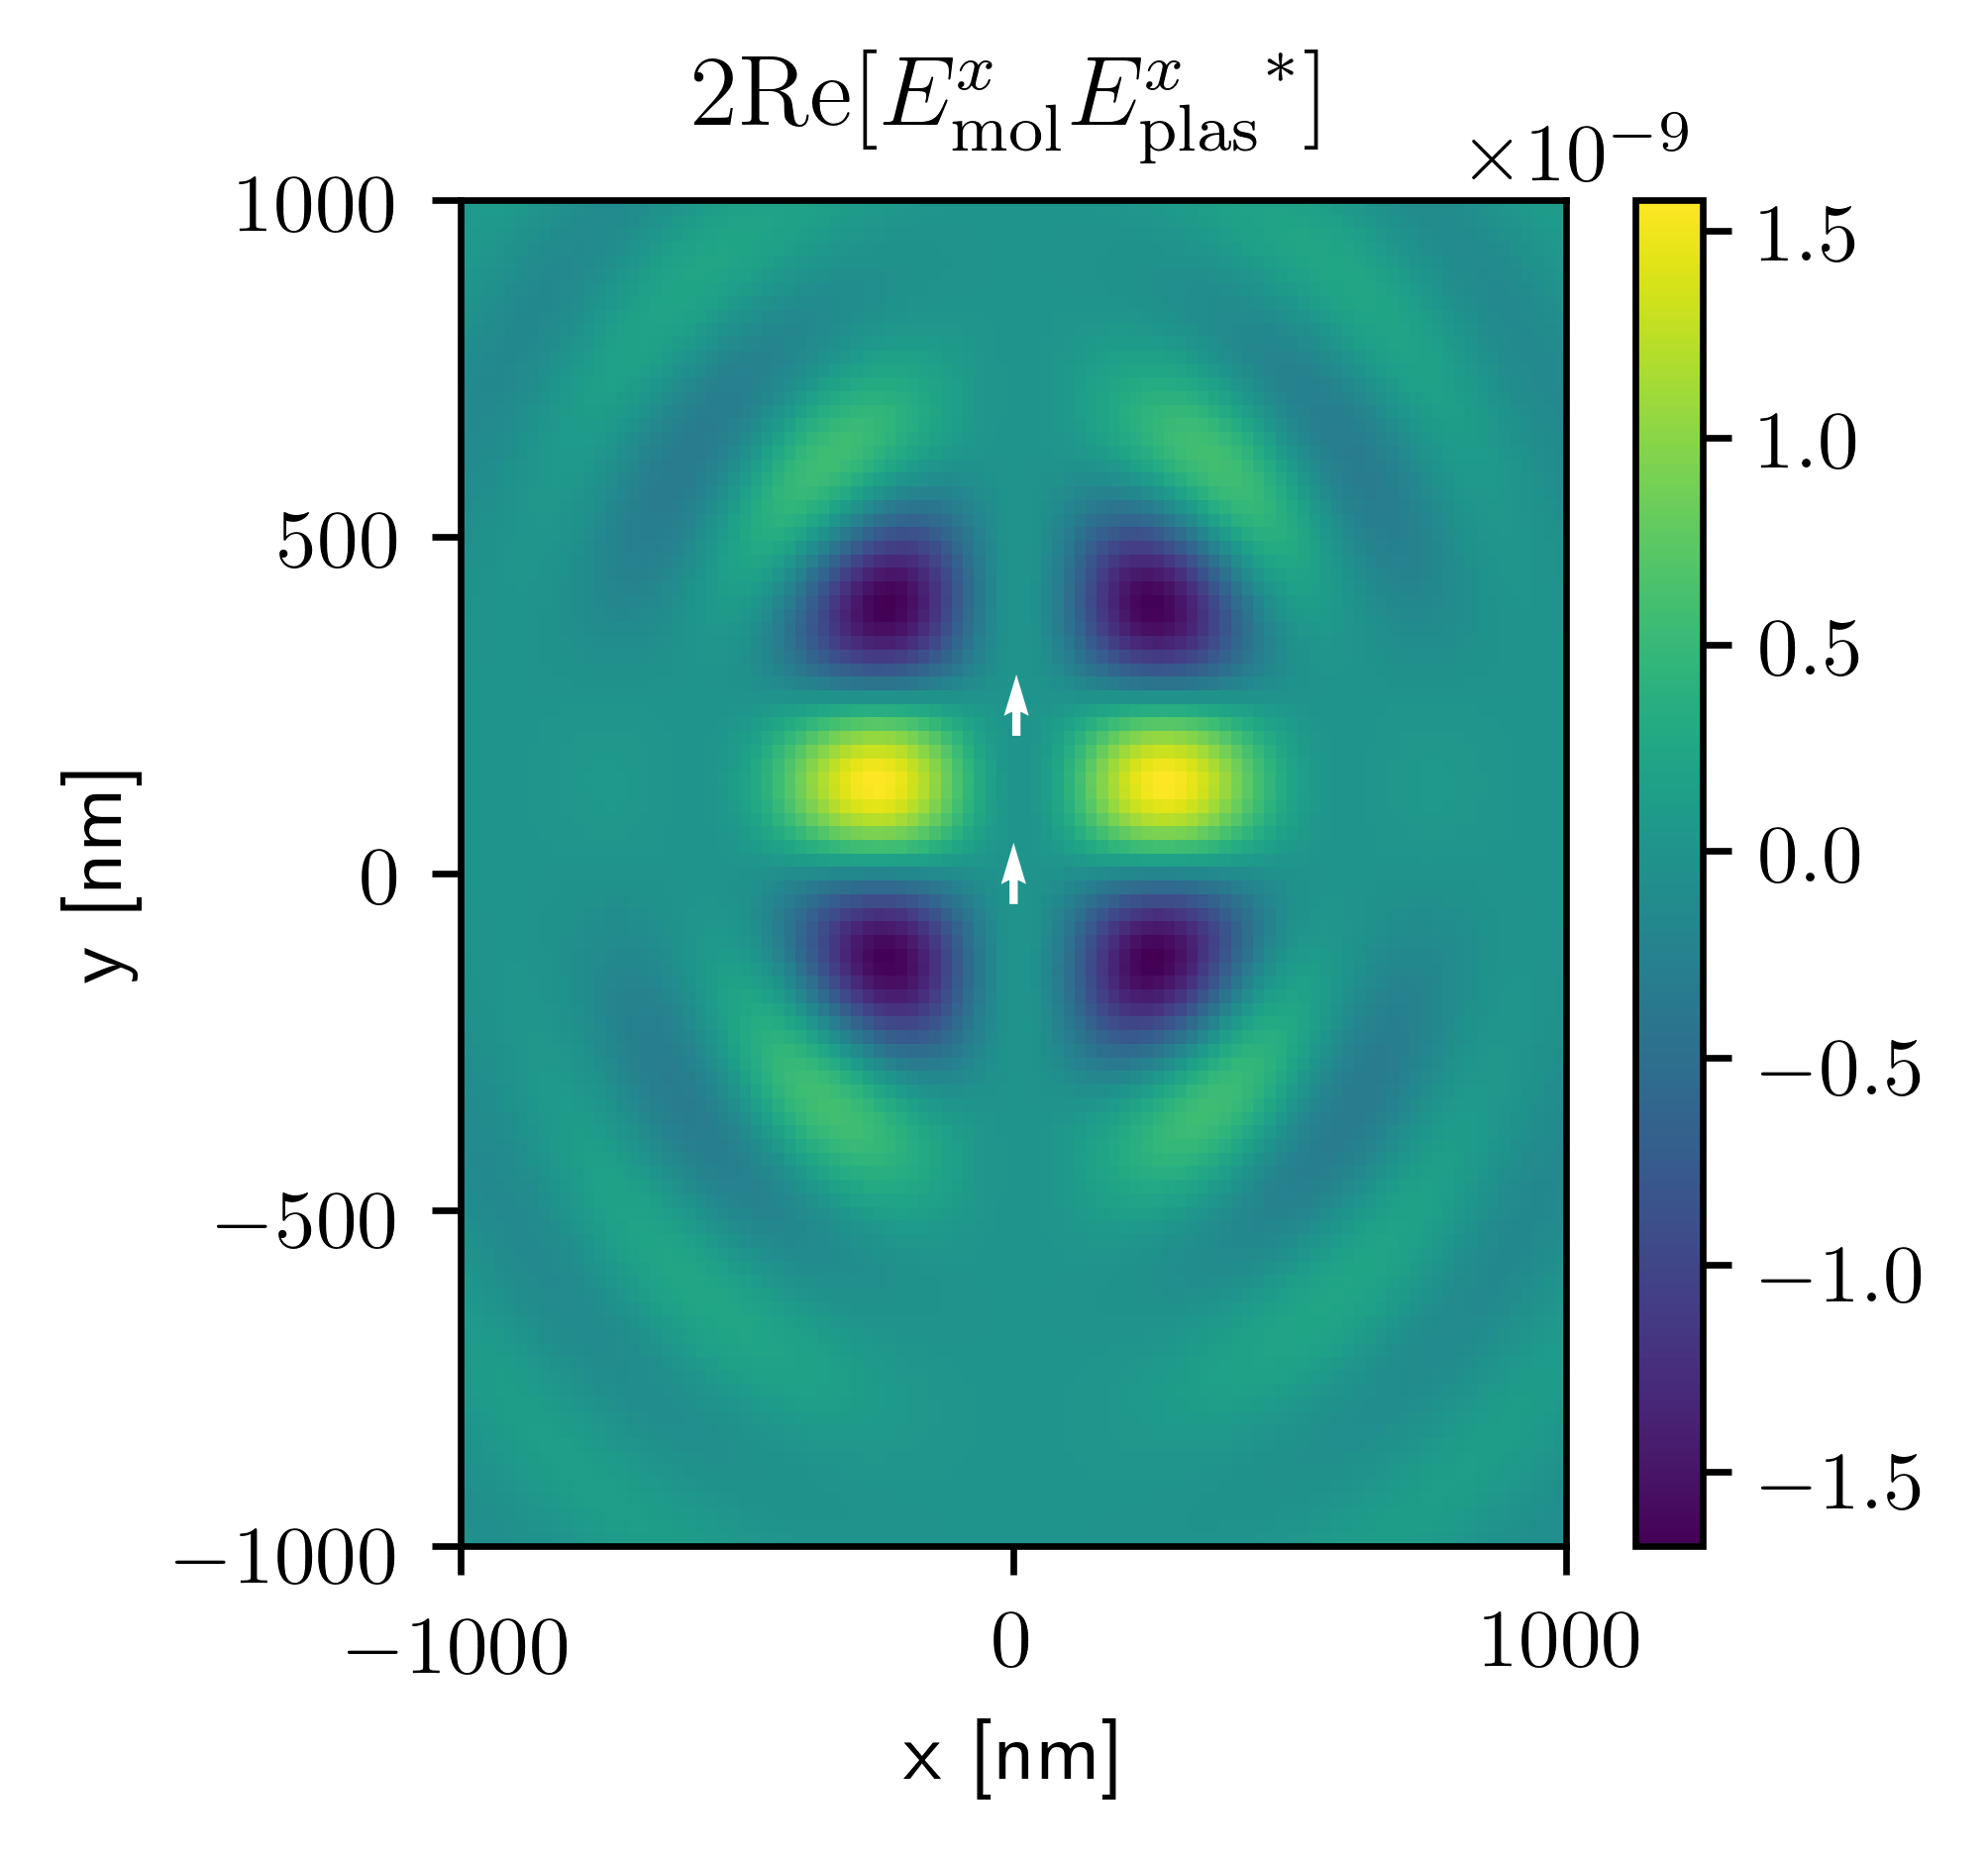

In [28]:
plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,2*(np.imag(plas_E[0,0])*np.imag(mol_E[0,0])
                                  +np.real(plas_E[0,0])*np.real(mol_E[0,0])
                                 ).reshape((100,100)))
plt.colorbar()
plt.title(r'$2\mathrm{Re}[E^x_\mathrm{mol}{E^x_\mathrm{plas}}^*]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
# plt.axis('equal')
plt.quiver([0,5],[0,250],[0,0],[1,1], color='white',pivot='middle')

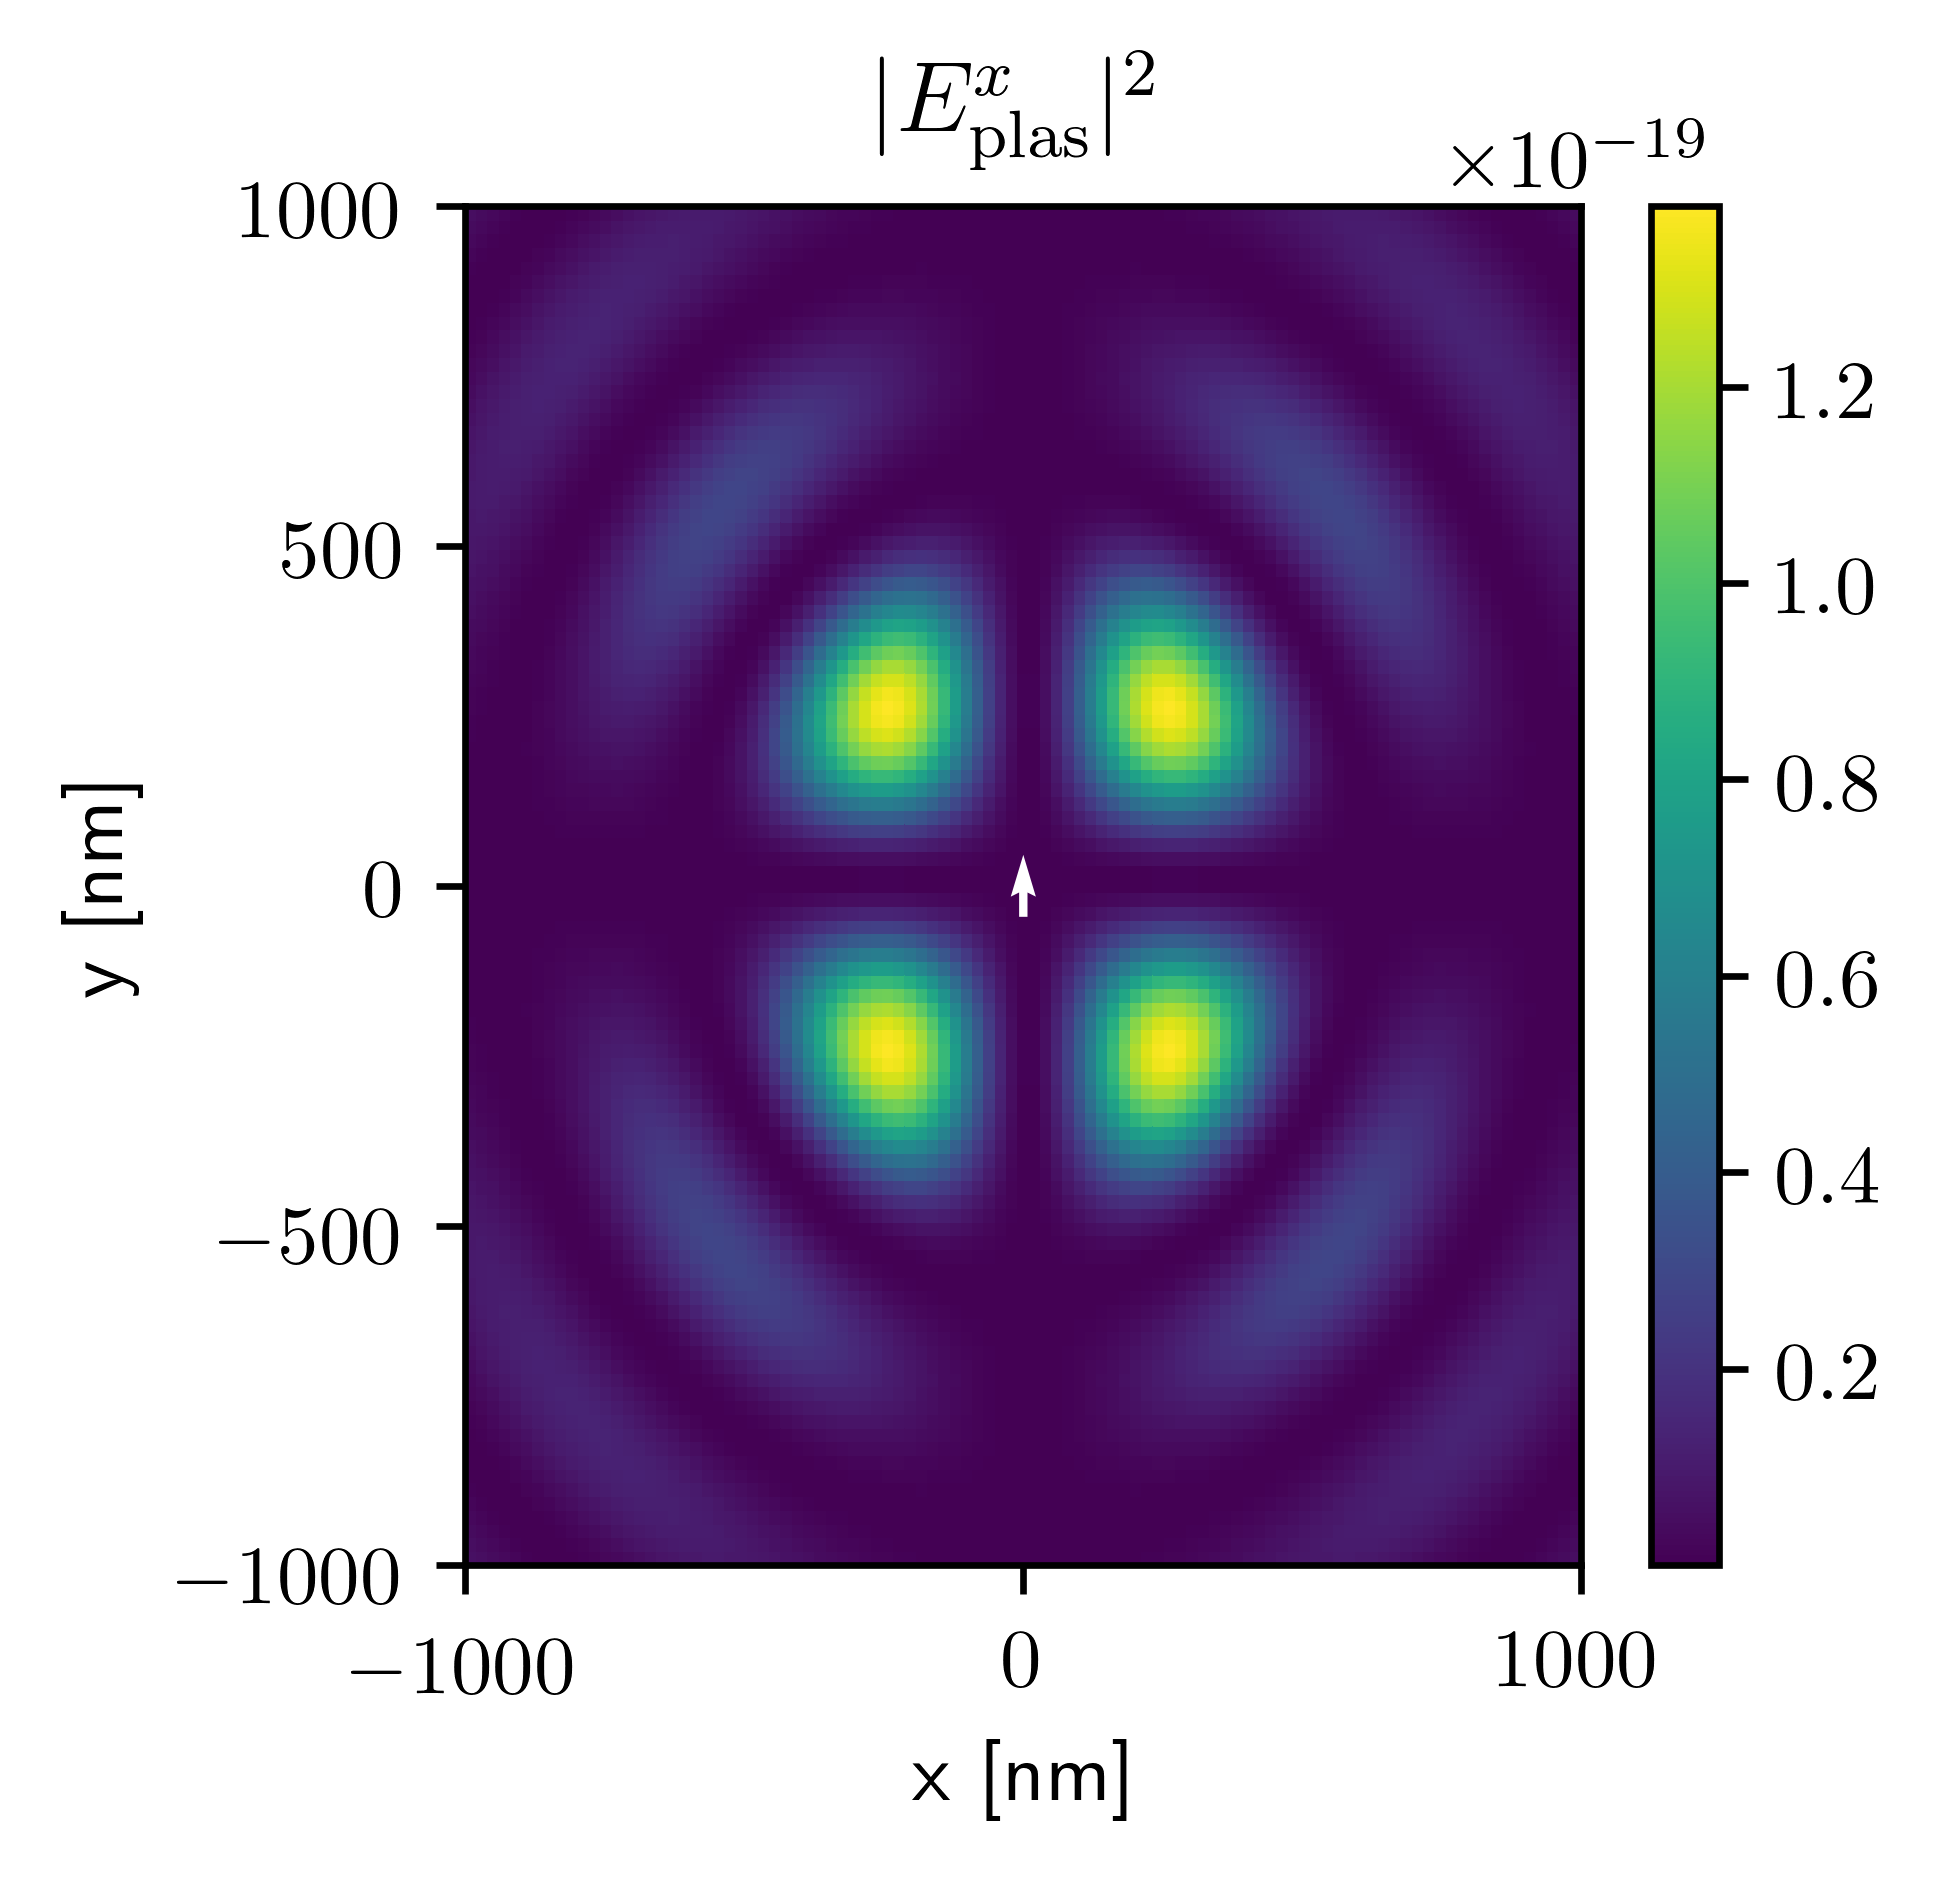

In [29]:

plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,(np.real(plas_E[0,0])*np.imag(plas_E[0,0])).reshape((100,100)))
plt.title(r'$|E^x_\mathrm{plas}|^2$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
ax = plt.gca()
# ax.axis('equal')
# plt.colorbar()
# plot_limits = [-1000,1000, -1000, 1000]
# ax.axis(plot_limits)
plt.colorbar()
plt.quiver(0,0,0,1, color='white',pivot='middle')

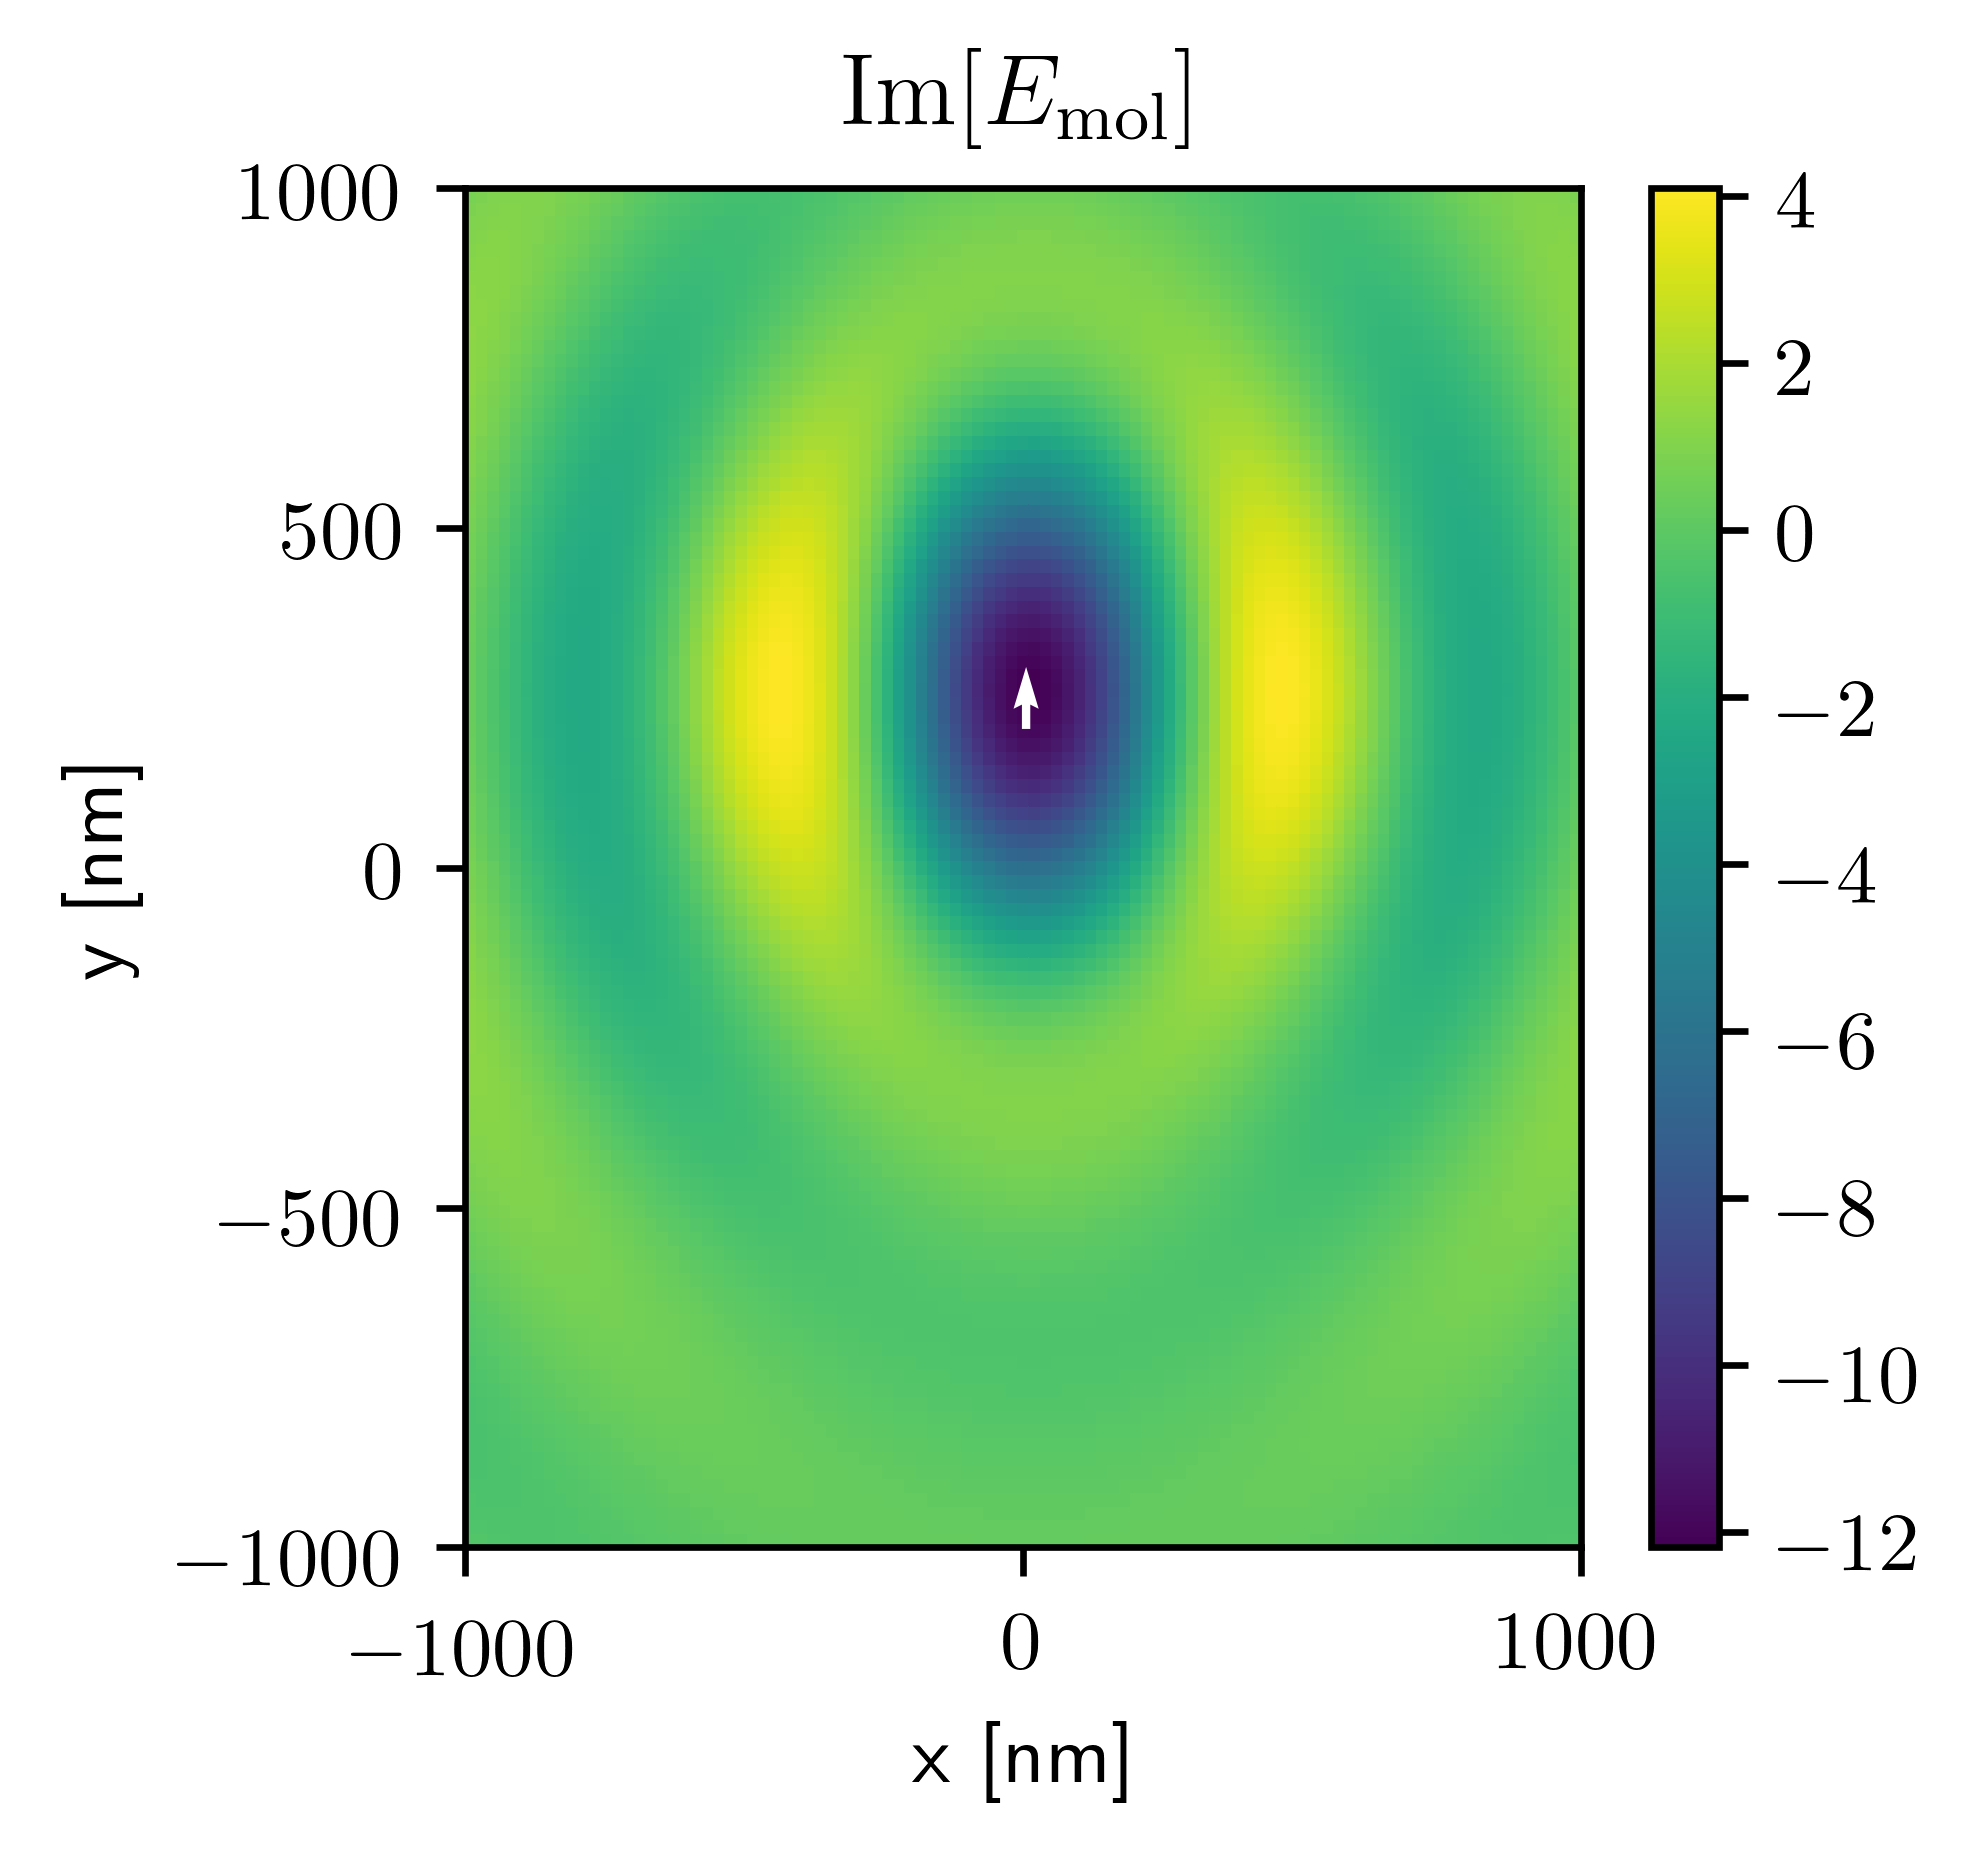

In [30]:
plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,np.imag((mol_E[1,0]).reshape((100,100))))
plt.colorbar()
plt.title(r'$\mathrm{Im}[E_\mathrm{mol}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([5],[250],[0],[1], color='white',pivot='middle')


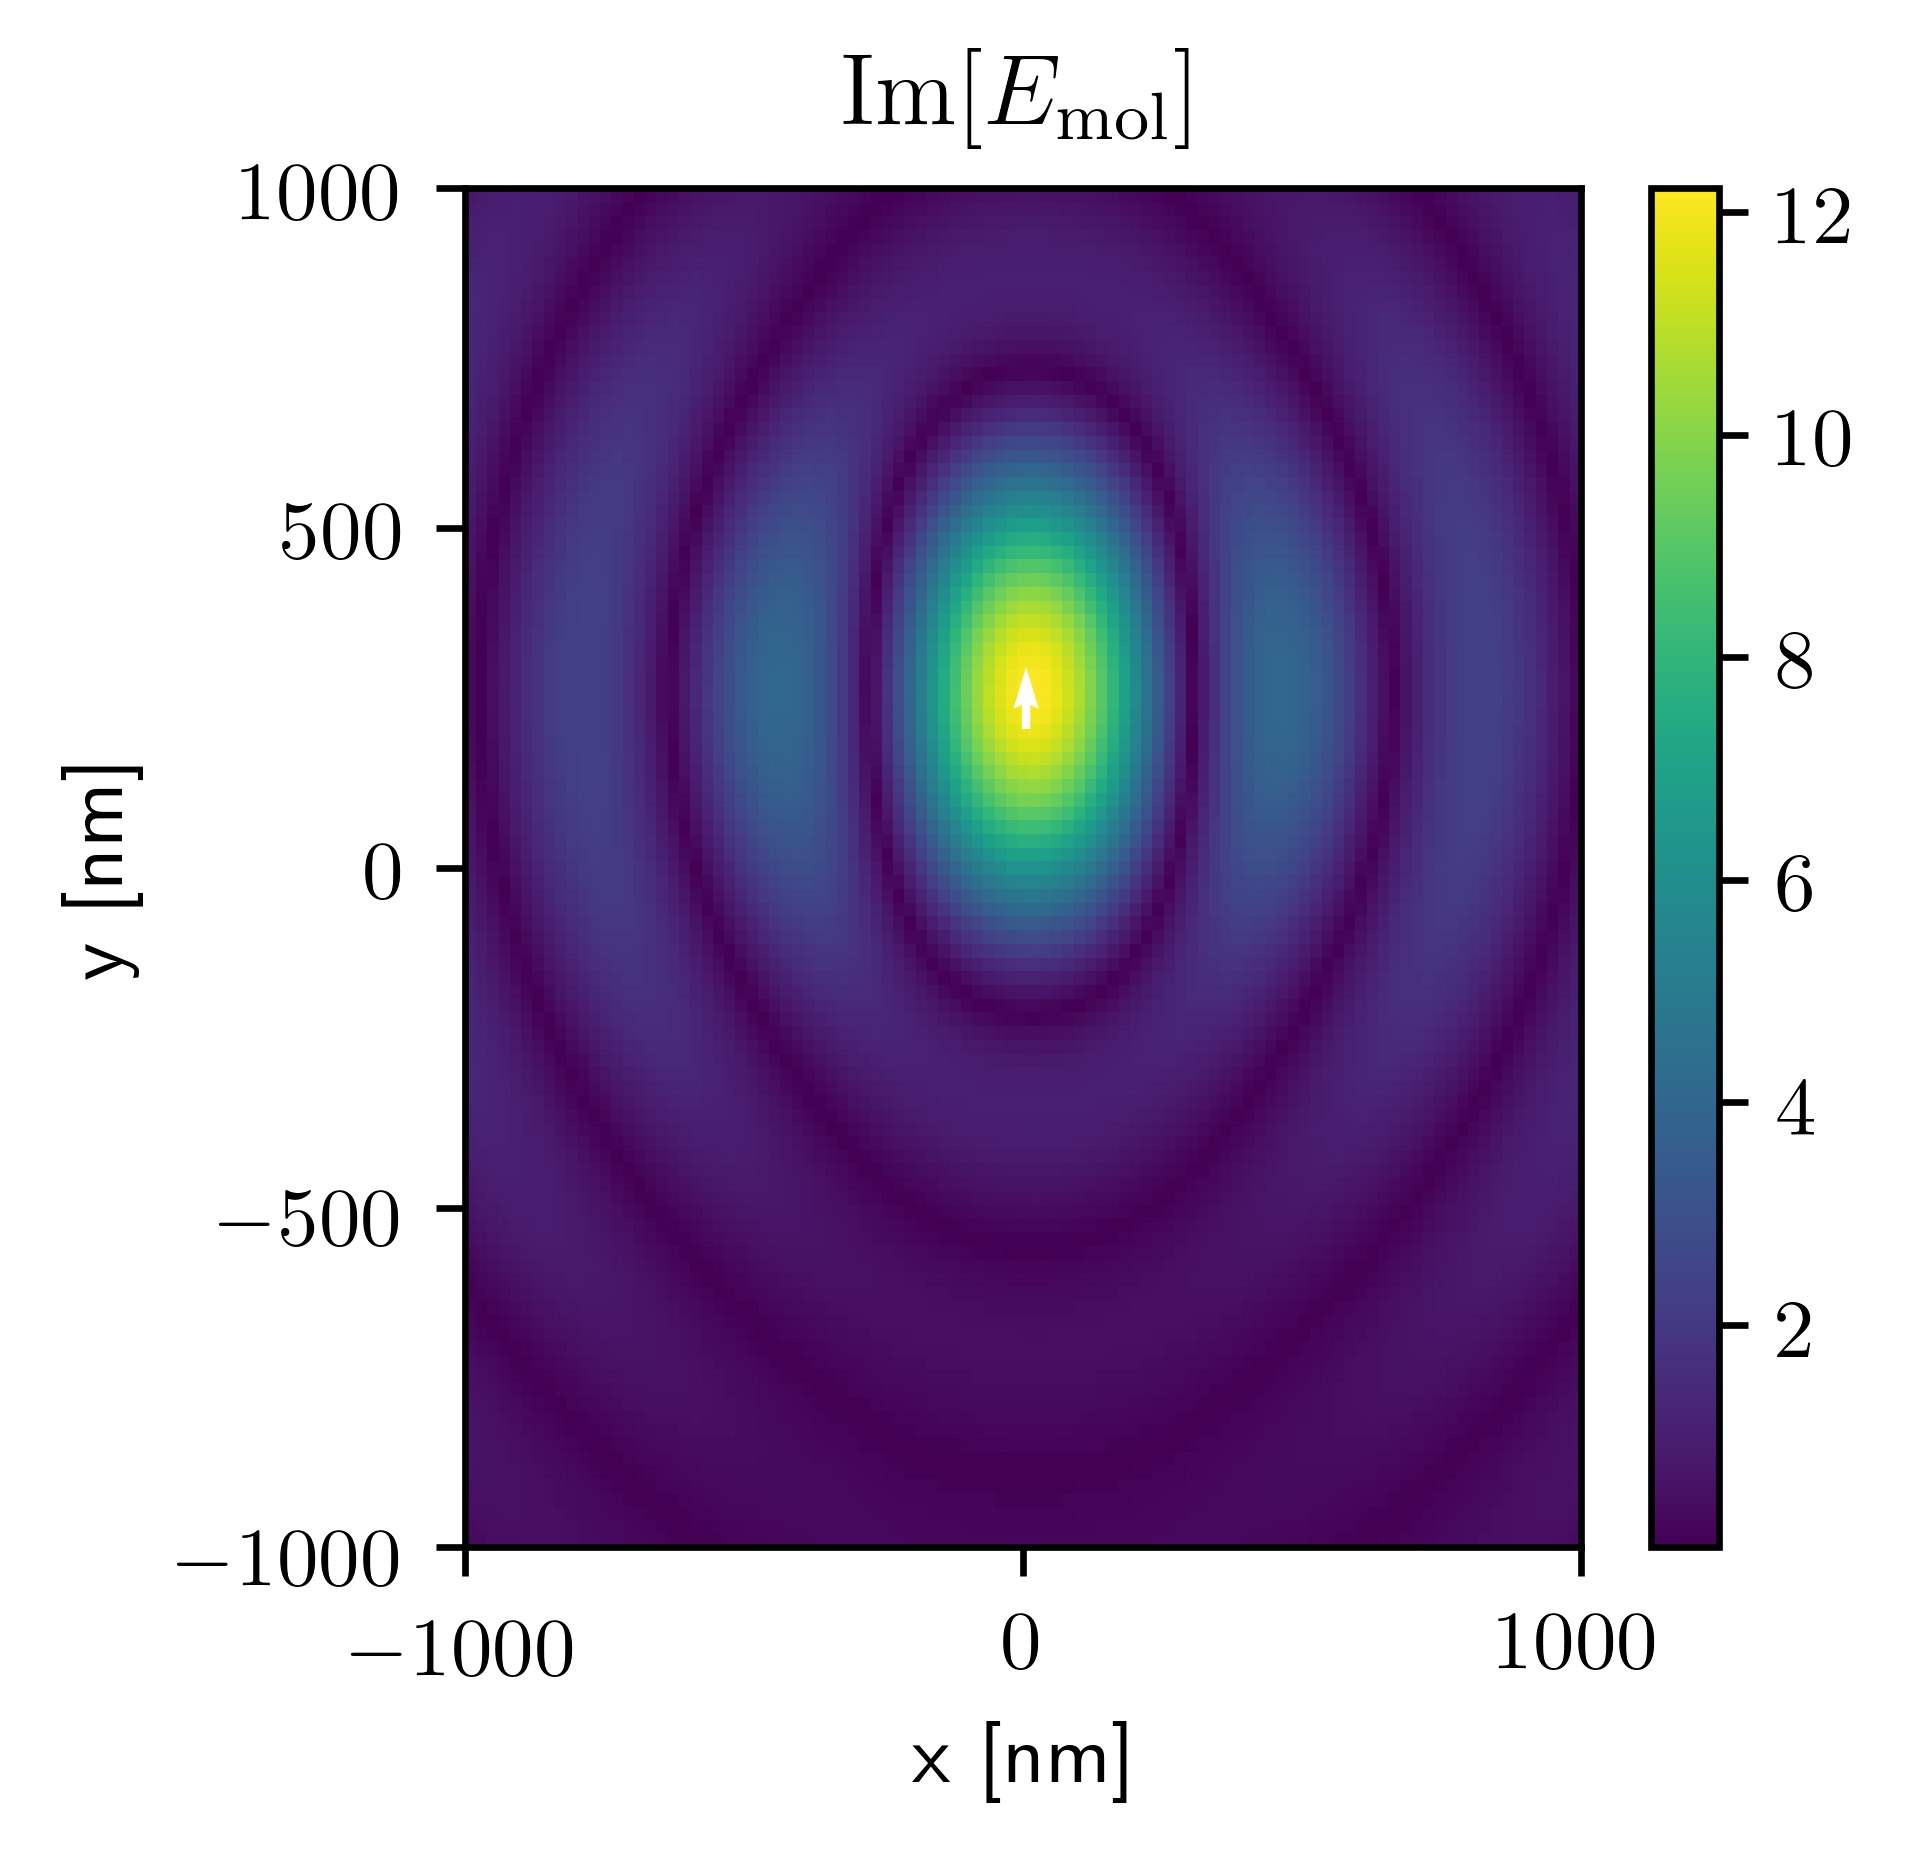

In [31]:
plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,np.abs((mol_E[1,0]).reshape((100,100))))
plt.colorbar()
plt.title(r'$\mathrm{Im}[E_\mathrm{mol}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([5],[250],[0],[1], color='white',pivot='middle')


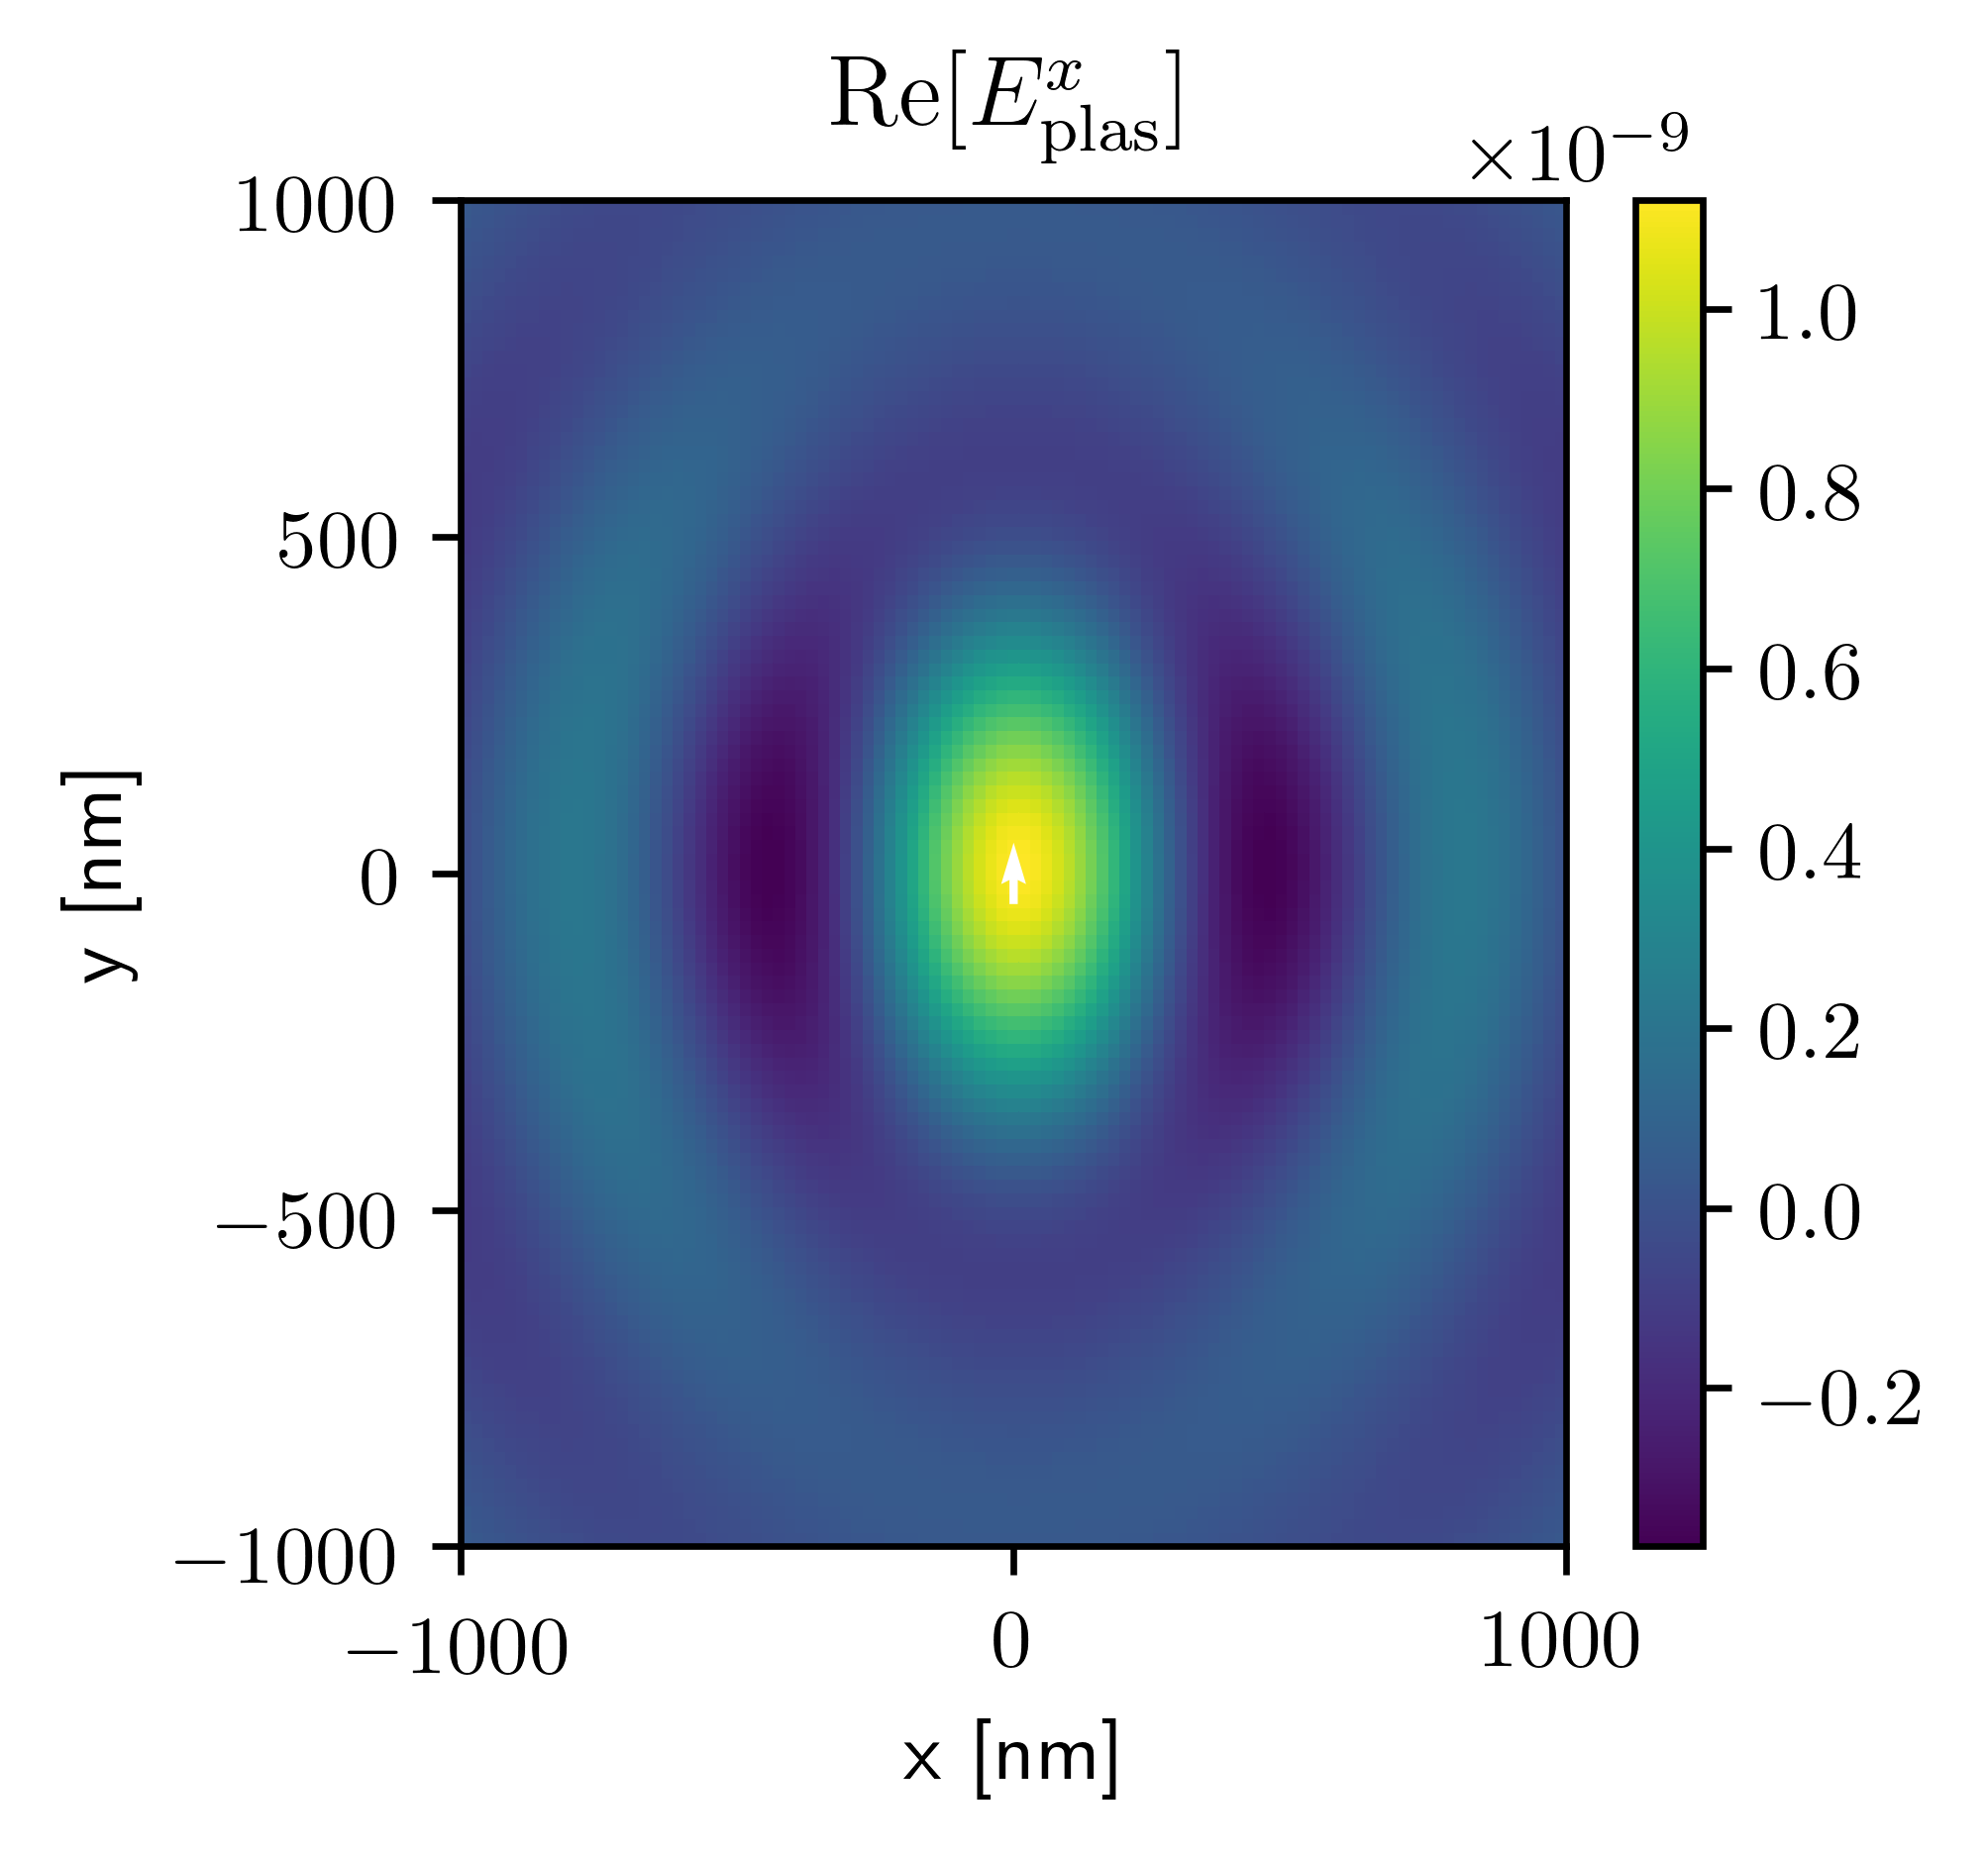

In [32]:

plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,np.real((plas_E[1,0]).reshape((100,100))))
plt.colorbar()
plt.title(r'$\mathrm{Re}[E^x_\mathrm{plas}]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
plt.quiver([0],[0],[0],[1], color='white',pivot='middle')

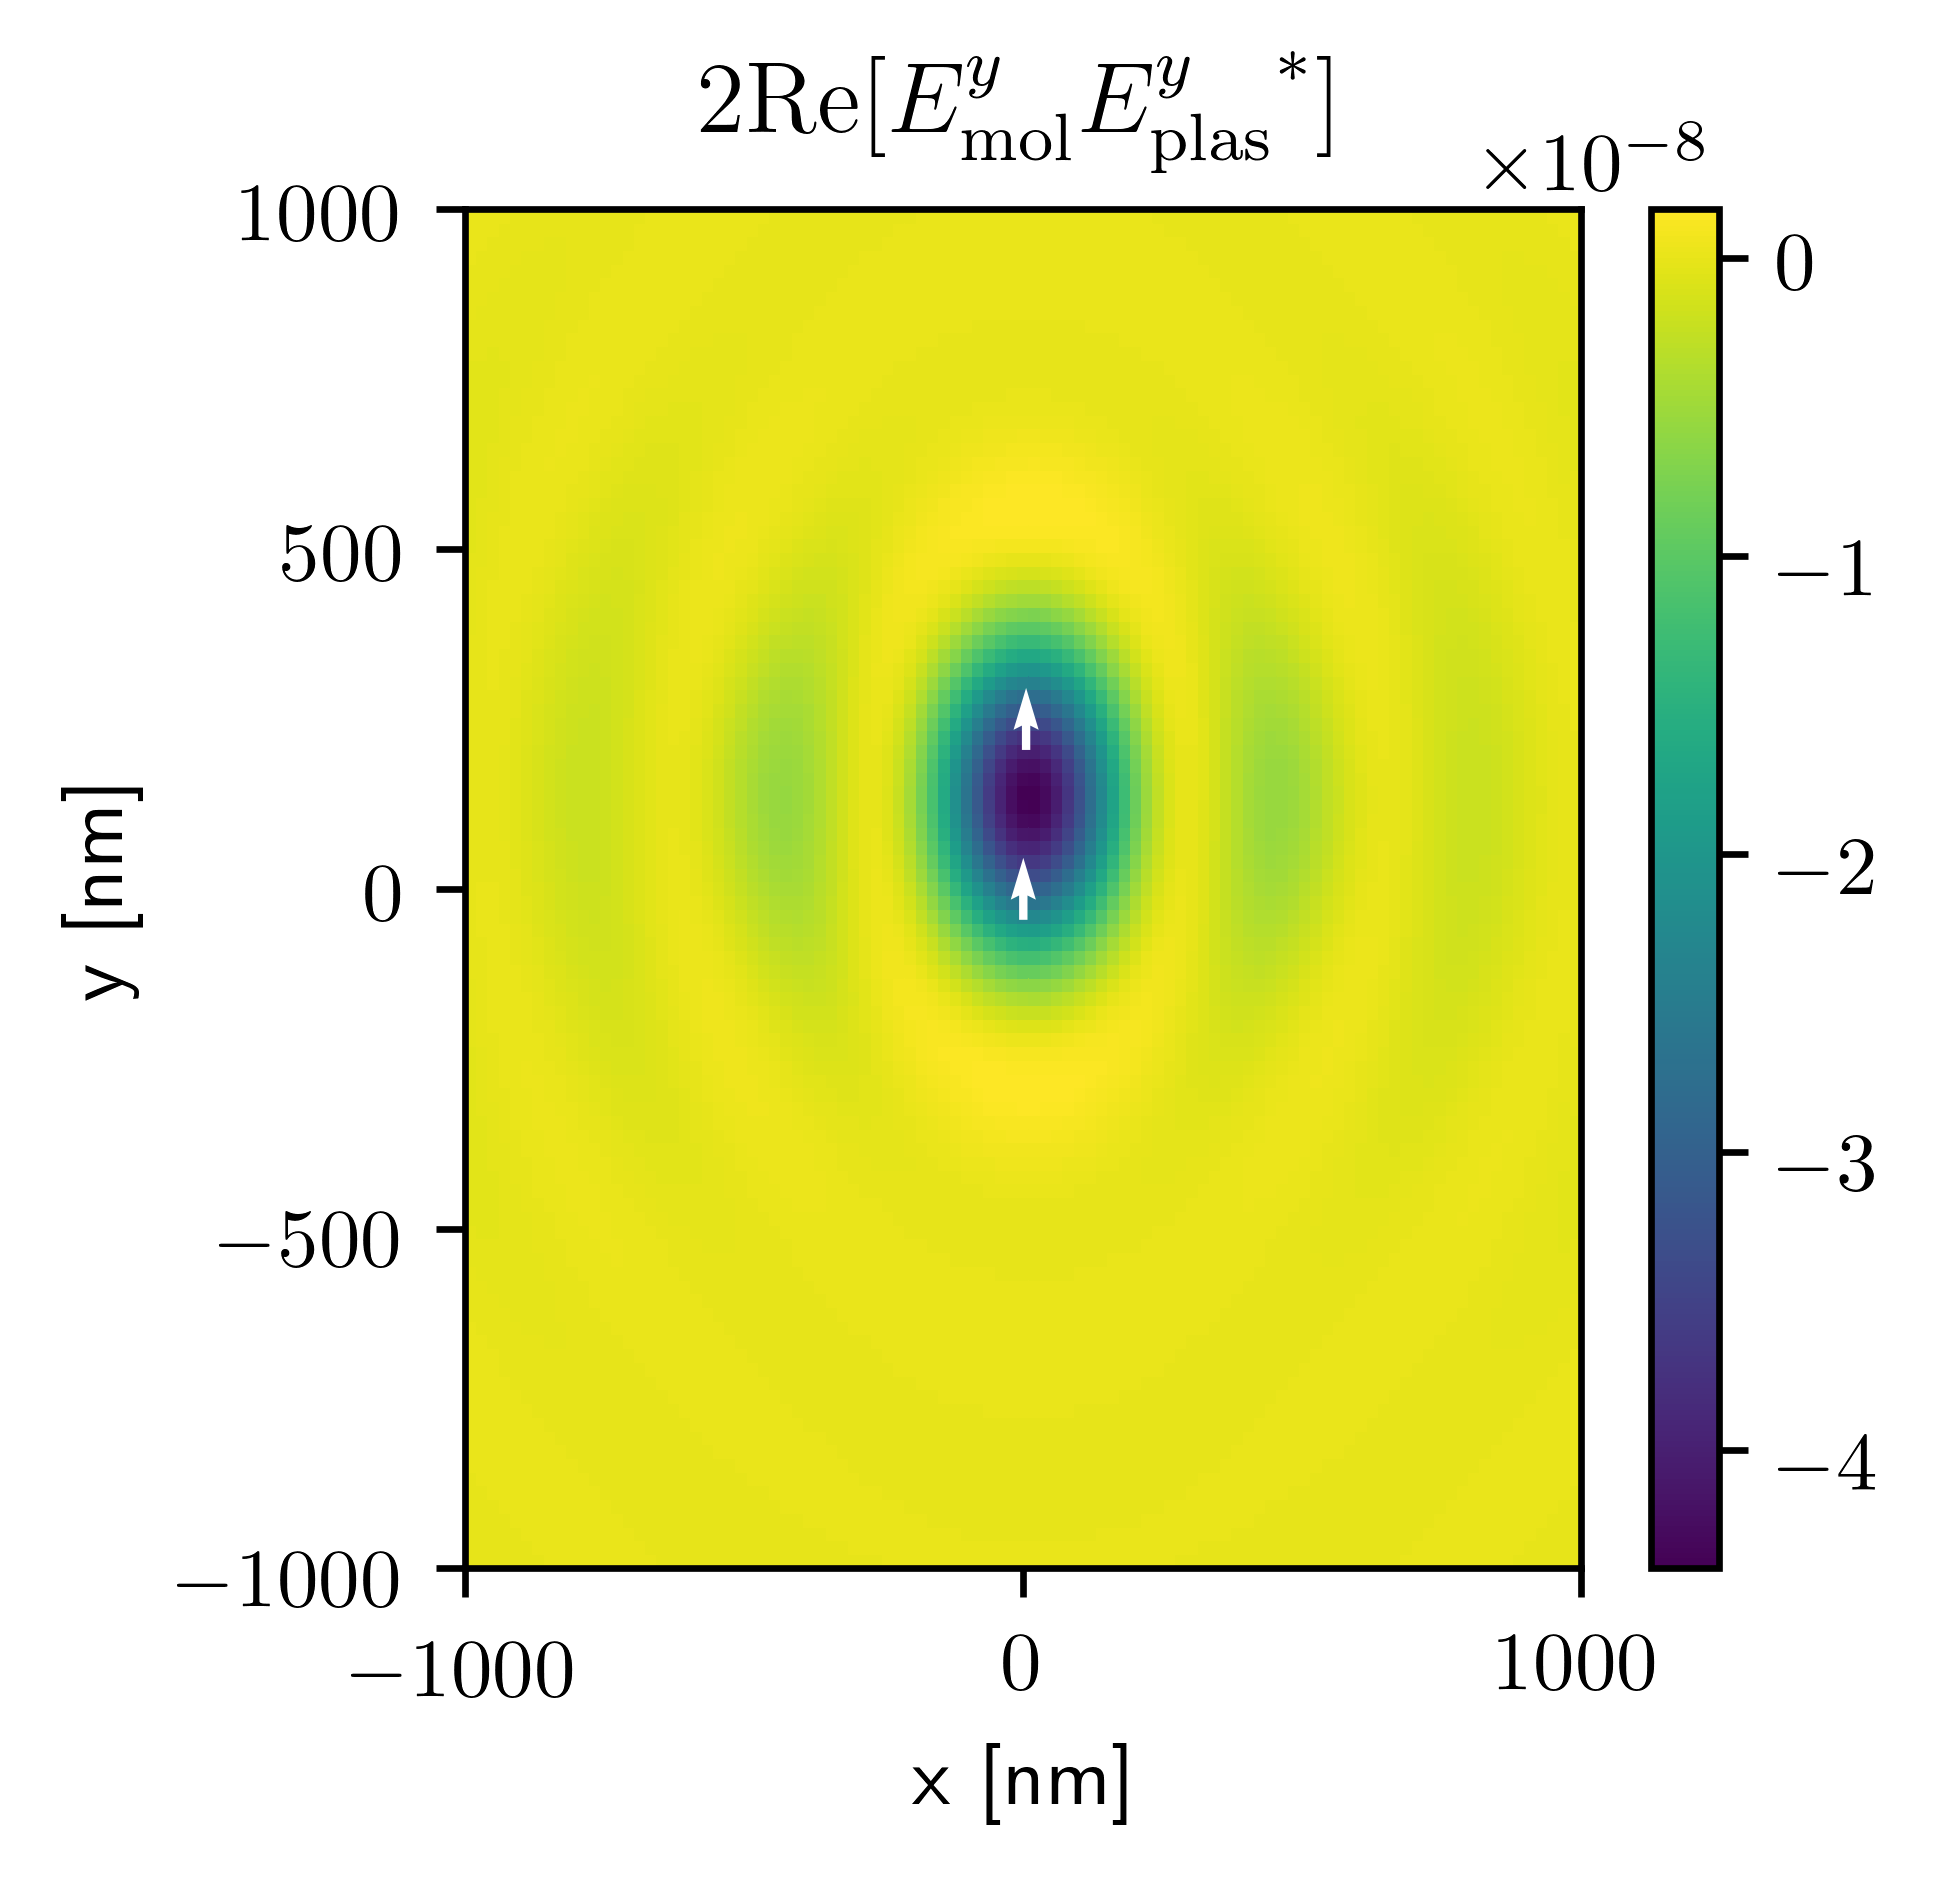

In [33]:
plt.figure(figsize=(3,3),dpi=600)
plt.pcolor(eye[1]/nm,eye[2]/nm,2*(np.imag(plas_E[1,0])*np.imag(mol_E[1,0])
                                  +np.real(plas_E[1,0])*np.real(mol_E[1,0])
                                 ).reshape((100,100)))
plt.colorbar()
plt.title(r'$2\mathrm{Re}[E^y_\mathrm{mol}{E^y_\mathrm{plas}}^*]$')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
# plt.axis('equal')
plt.quiver([0,5],[0,250],[0,0],[1,1], color='white',pivot='middle')

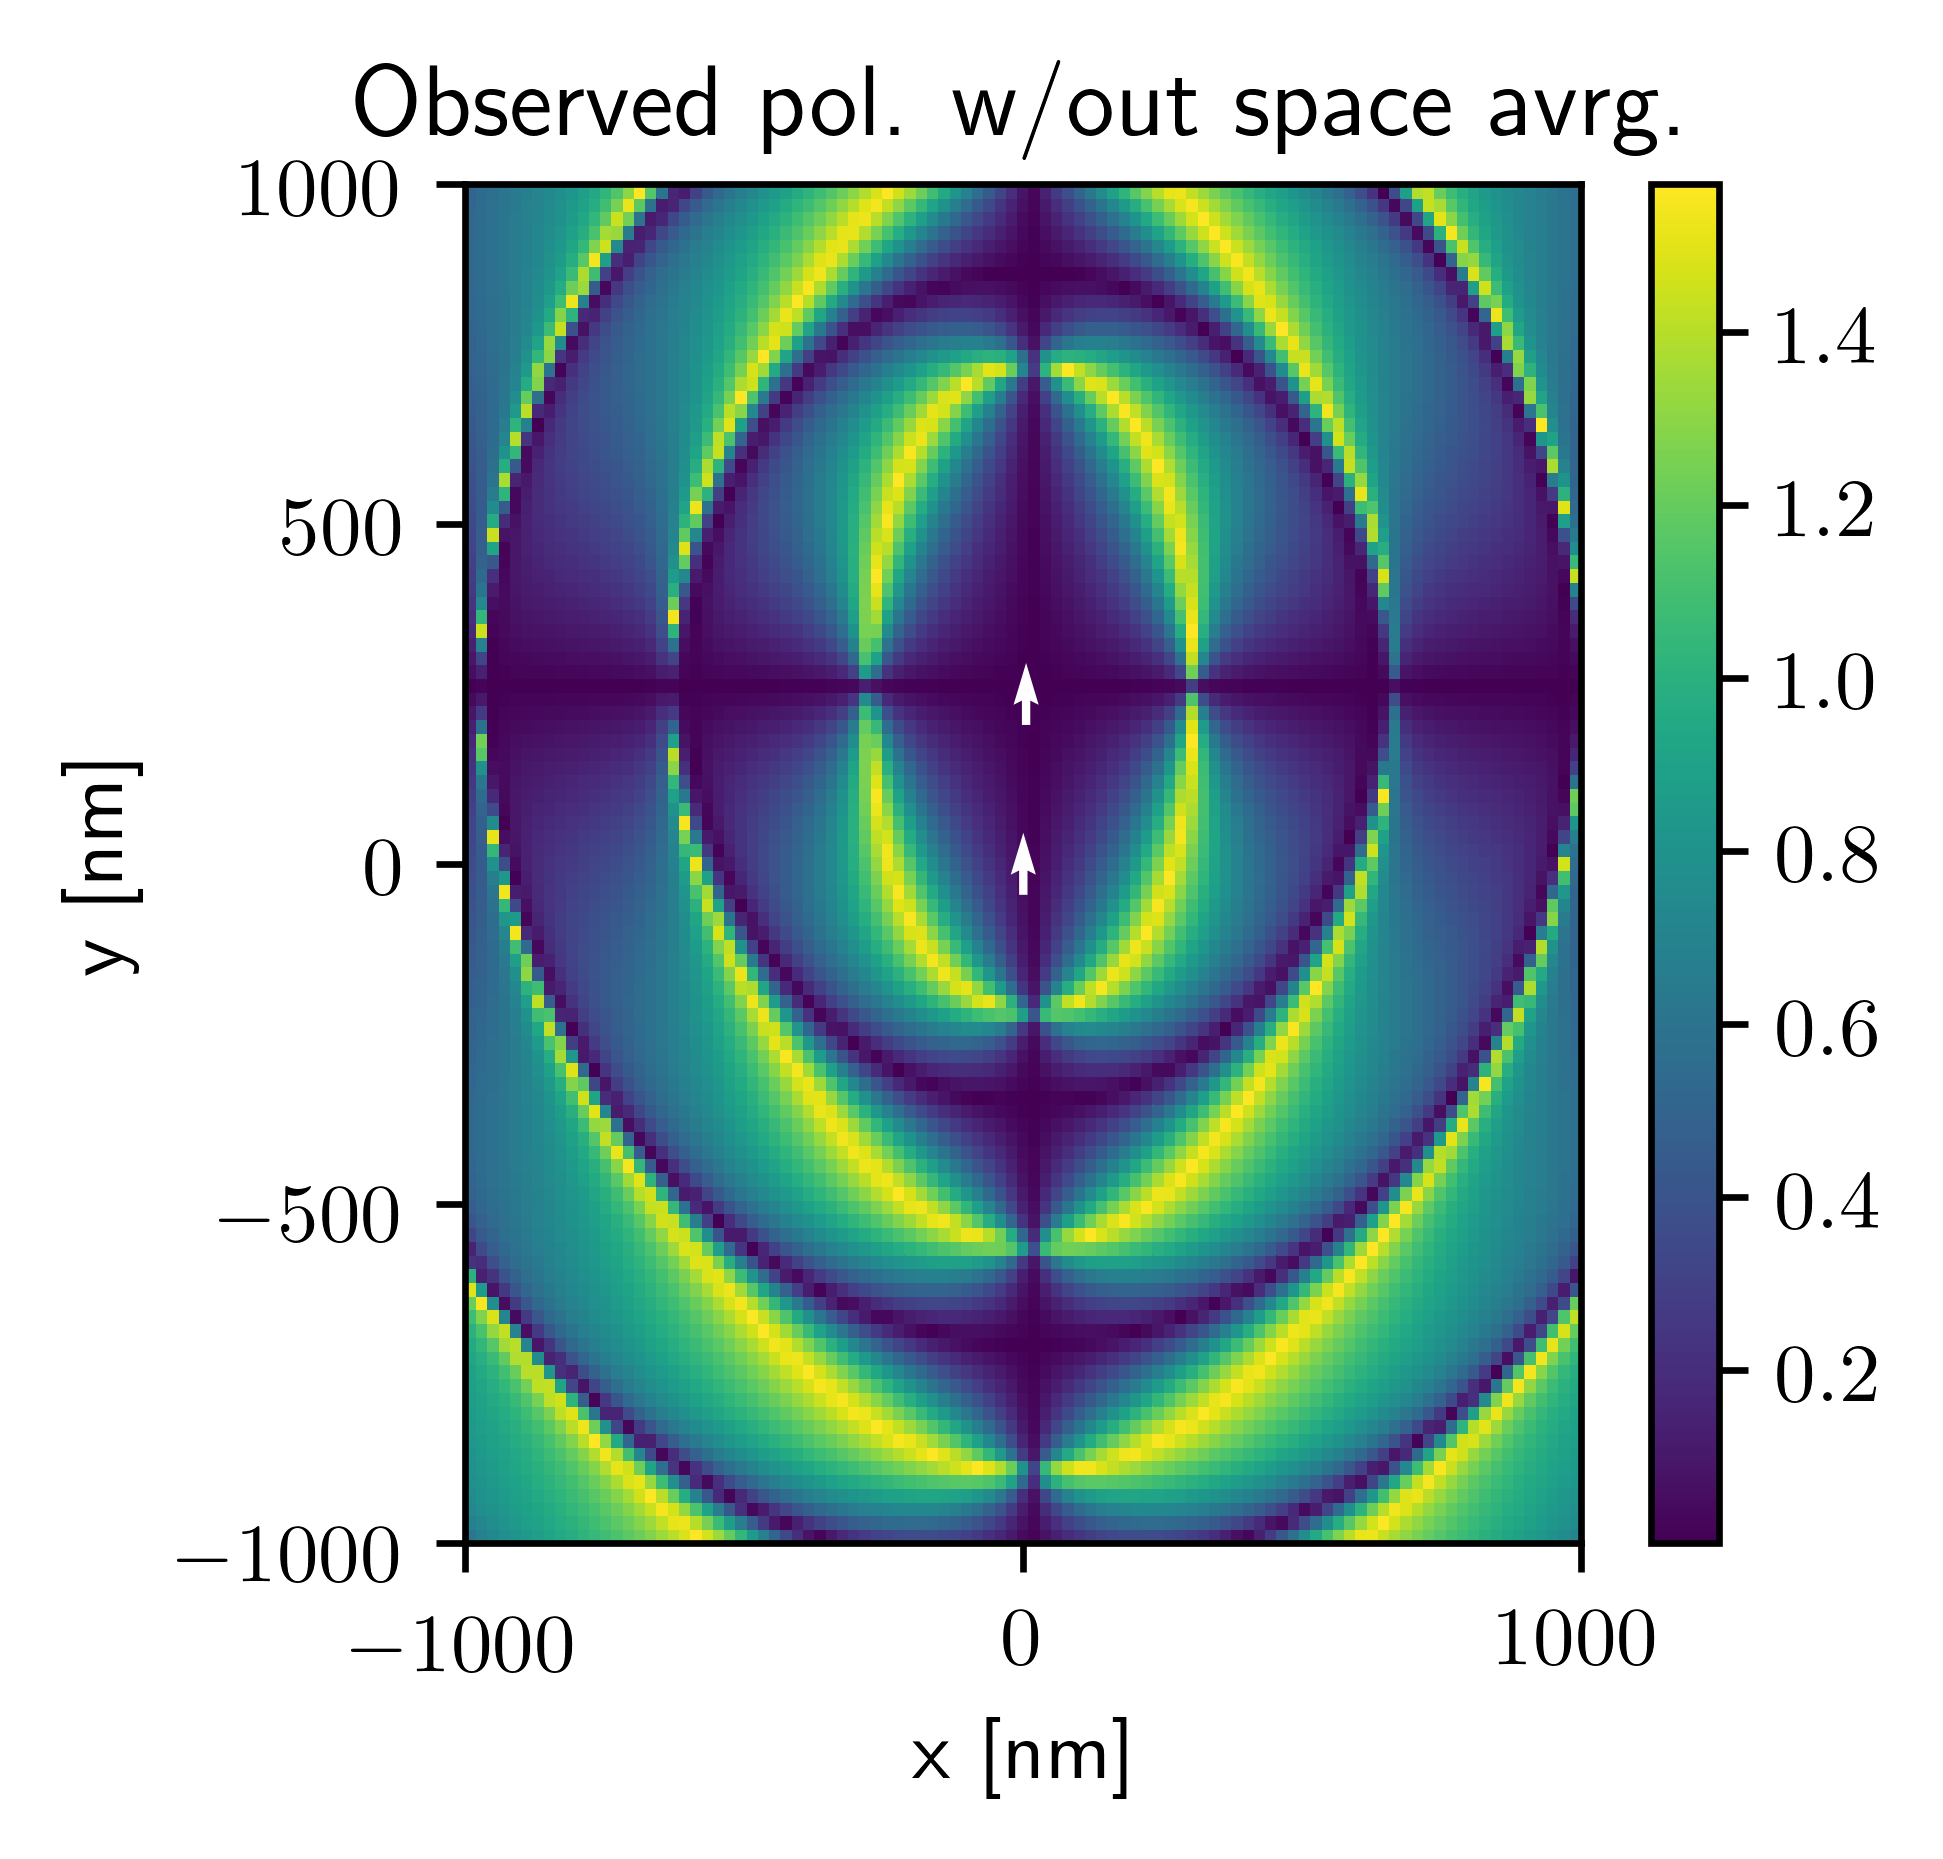

In [34]:
plt.figure(figsize=(3,3),dpi=600)
Iy = np.abs(plas_E[0,0] + mol_E[0,0])**2.
Ix = np.abs(plas_E[1,0] + mol_E[1,0])**2.
angle_of_x = np.arctan(Iy**0.5/Ix**0.5)
plt.pcolor(eye[1]/nm,eye[2]/nm,(angle_of_x).reshape((100,100)))
plt.colorbar()
plt.title(r'Observed pol. w/out space avrg.')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
# plt.axis('equal')
plt.quiver([0,5],[0,250],[0,0],[1,1], color='white',pivot='middle')

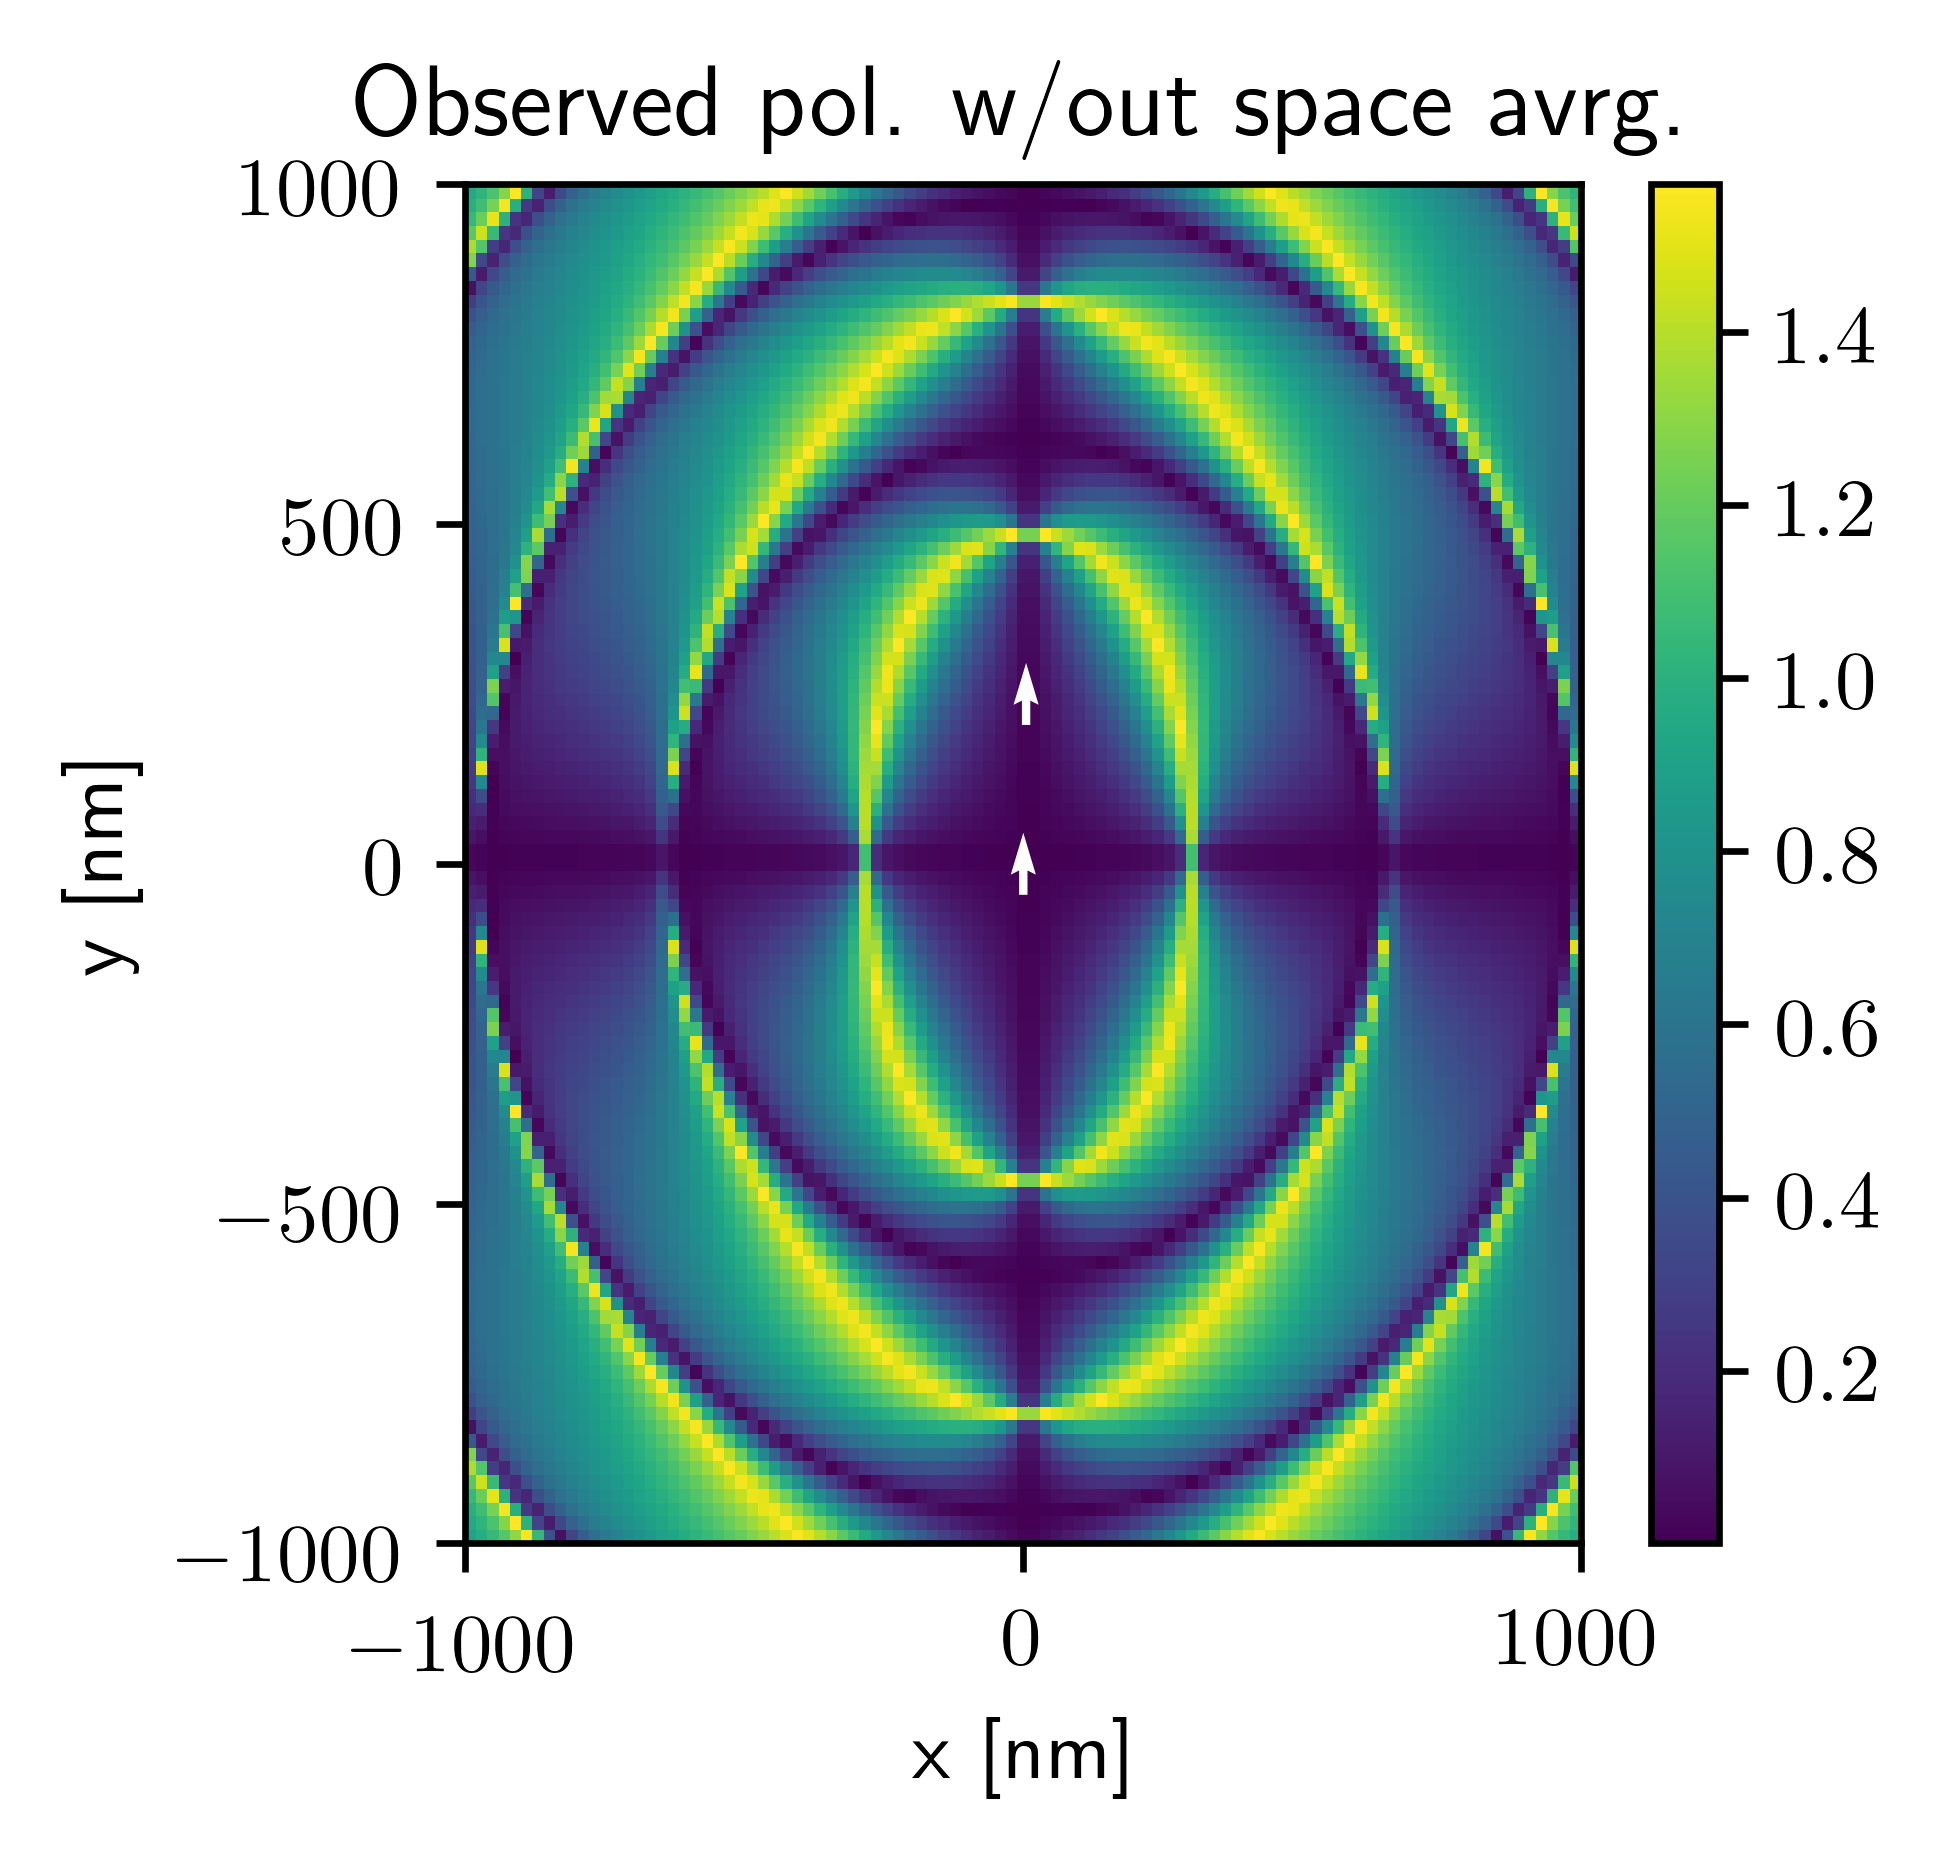

In [35]:
plt.figure(figsize=(3,3),dpi=600)
Iy = np.abs(plas_E[0,0])**2.
Ix = np.abs(plas_E[1,0])**2.
angle_of_x = np.arctan(Iy**0.5/Ix**0.5)
plt.pcolor(eye[1]/nm,eye[2]/nm,(angle_of_x).reshape((100,100)))
plt.colorbar()
plt.title(r'Observed pol. w/out space avrg.')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
# plt.axis('equal')
plt.quiver([0,5],[0,250],[0,0],[1,1], color='white',pivot='middle')

In [36]:
angle_of_x.sum()/angle_of_x.shape 

array([0.60475022])

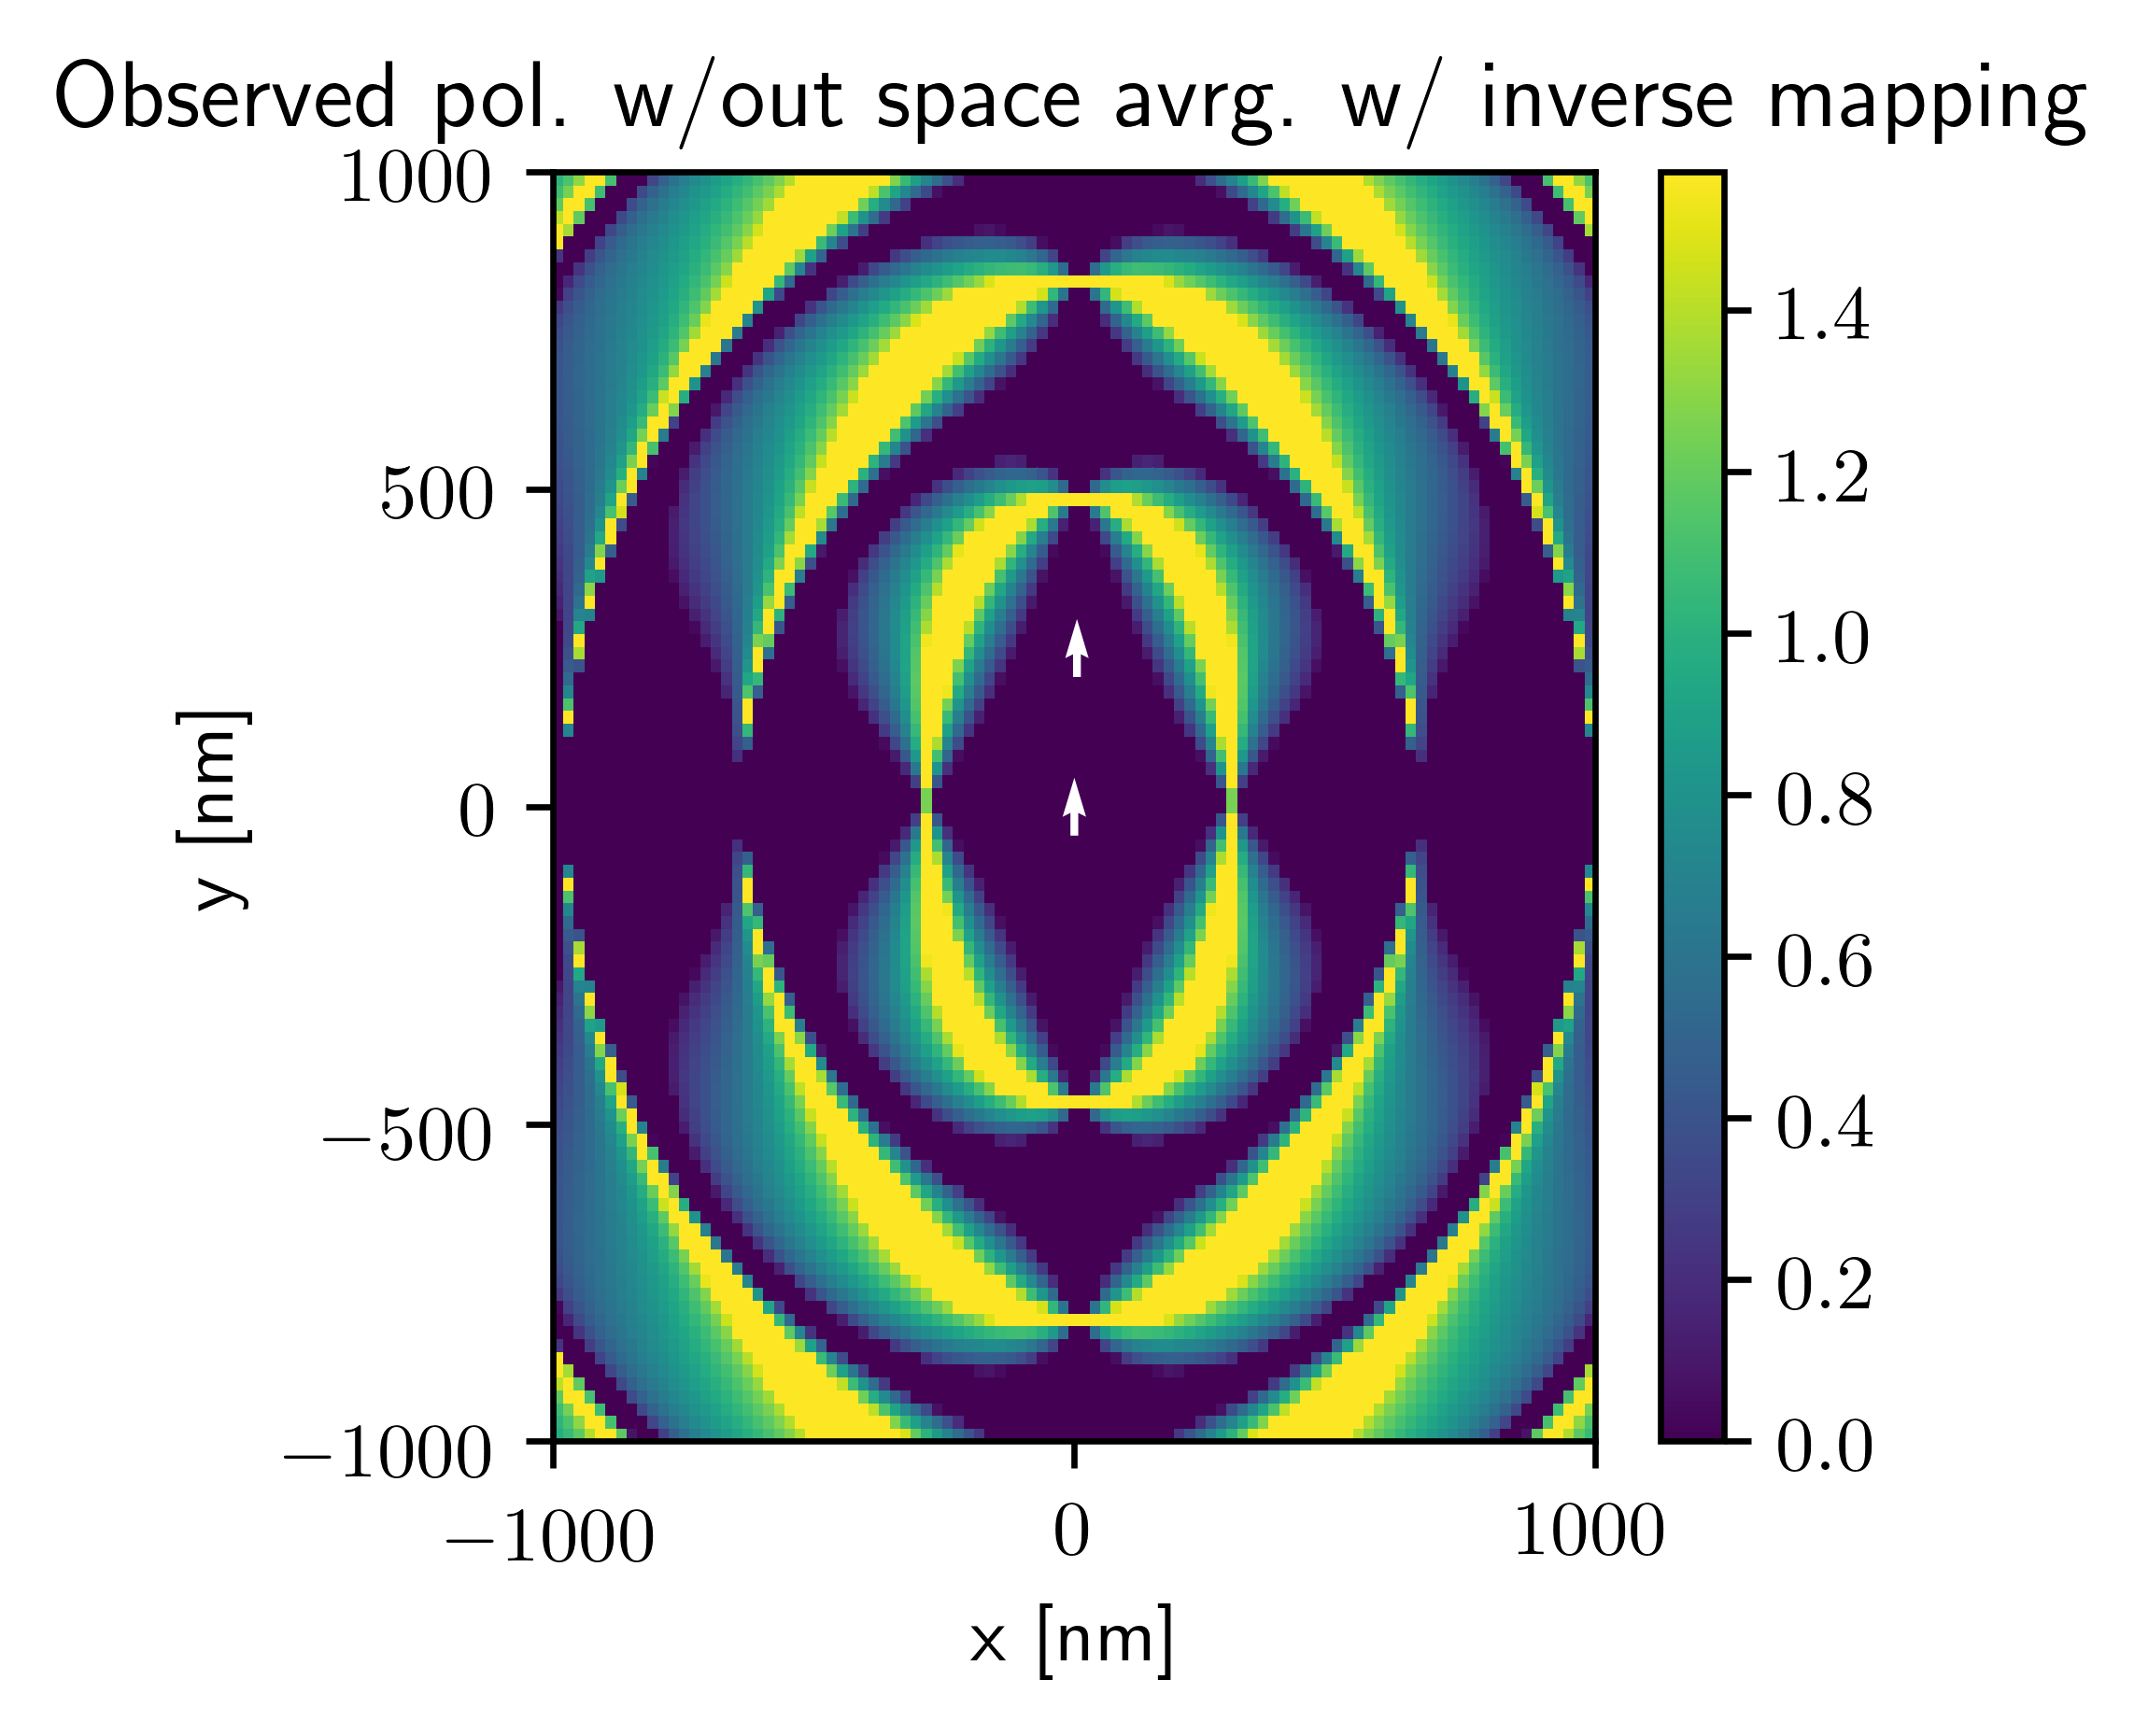

In [37]:
plt.figure(figsize=(3,3),dpi=600)
Iy = np.abs(plas_E[0,0])**2.
Ix = np.abs(plas_E[1,0])**2.
angle_of_x = np.arctan(Iy**0.5/Ix**0.5)
plt.pcolor(eye[1]/nm,eye[2]/nm,(f_inv(angle_of_x)).reshape((100,100)))
plt.colorbar()
plt.title(r'Observed pol. w/out space avrg. w/ inverse mapping')
plt.xlabel(r'x [nm]')
plt.ylabel(r'y [nm]')
# plt.axis('equal')
plt.quiver([0,5],[0,250],[0,0],[1,1], color='white',pivot='middle')